# load some Packages

In [ ]:
import math
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

OUT_DIR = "figures"
os.makedirs(OUT_DIR, exist_ok=True)

from openpyxl import load_workbook
def format_excel_with_filters_and_freeze(path):
    wb = load_workbook(path)
    for ws in wb.worksheets:
        # Determine the full data range
        max_row = ws.max_row
        max_col = ws.max_column
        if max_col == 0 or max_row == 0:
            continue
        # A1:Z1000 style range for autofilter
        data_range = f"A1:{ws.cell(row=max_row, column=max_col).coordinate}"
        # Apply filter dropdowns
        ws.auto_filter.ref = data_range
        # Freeze the top row: freezes everything above row 2 (so row 1 stays visible)
        ws.freeze_panes = "A2"
    wb.save(path)
    print(f"Formatted workbook: {path}")


# Growth Profile Analysis

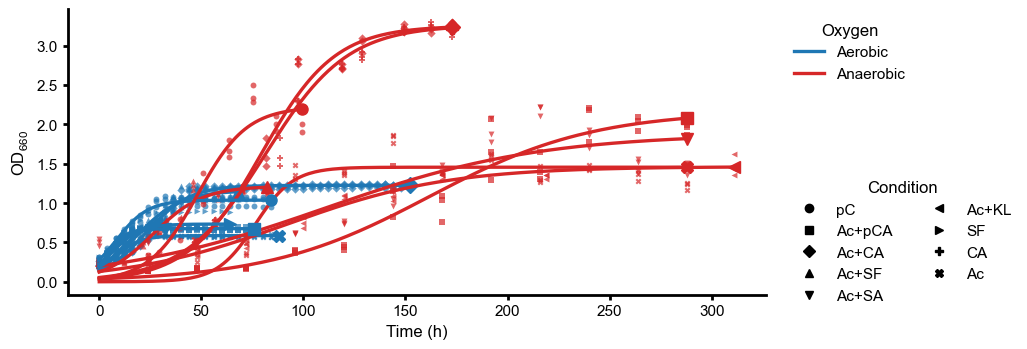

Per-replicate plot index: growth_curve_fits/reps/plot_index.csv
Per-replicate parameter table: growth_curve_fits/longitudinal_logistic_fit_per_replicate.csv
Overlay figure (mean curves): growth_curve_fits/all_conditions_fits_mean_curves_with_scatter.png


In [42]:
# Plots for per-replicate logistic fits + summary overlay
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
from matplotlib.lines import Line2D

# ----------------------------
# Config
# ----------------------------
XLSX_PATH    = "growth_curve_fits/OD660_Data_use.xlsx"
SHEET        = "Longitudinal_Data"   # exact sheet name
OUT_PER      = "growth_curve_fits/longitudinal_logistic_fit_per_replicate.csv"
OUT_SUM      = "growth_curve_fits/longitudinal_logistic_summary.csv"
FALLBACK_CSV = "growth_curve_fits/OD660_Data_use_fallback.csv"  # adjust if needed

# ----------------------------
# Load data
# ----------------------------
if os.path.exists(XLSX_PATH):
    try:
        df = pd.read_excel(XLSX_PATH, sheet_name=SHEET)
    except Exception:
        df = pd.read_csv(FALLBACK_CSV)
else:
    df = pd.read_csv(FALLBACK_CSV)

# Standardize and clean column names
rename_map = {"Time (h)": "Time_h", "OD 660": "OD660", "Replicates": "Replicate"}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

for col in ["Time_h", "OD660"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["Condition", "Oxygen", "Replicate", "Time_h", "OD660"])
df = df[df["OD660"] > 0]

# Normalize Ac naming if needed (ensure "Ac")
df["Condition"] = df["Condition"].replace({
    "Acetate": "Ac",
    "Ac_ae": "Ac",
    "Ac_an": "Ac",
})

# ----------------------------
# Logistic model
# ----------------------------
def logistic(t, A, mu, t0):
    """Three-parameter logistic growth model."""
    return A / (1.0 + np.exp(-mu * (t - t0)))


def fit_logistic(group):
    """Fit logistic model to a single (Condition, Oxygen, Replicate) group."""
    d = group.sort_values("Time_h")
    t = d["Time_h"].to_numpy(dtype=float)
    y = d["OD660"].to_numpy(dtype=float)

    if len(t) < 5:
        return None

    # Initial guesses
    ymax = np.nanmax(y)
    A0 = float(ymax * 1.05) if np.isfinite(ymax) else 1.0
    t0_0 = float(np.median(t))

    eps = 1e-9
    y_clip = np.clip(y, eps, A0 - eps)
    with np.errstate(divide="ignore", invalid="ignore"):
        logit = np.log(y_clip / (A0 - y_clip))
        mu0 = np.nanmedian(np.diff(logit) / np.diff(t)) if len(t) >= 3 else np.nan

    if (not np.isfinite(mu0)) or mu0 <= 0:
        mu0 = 0.02  # conservative default

    lower = [1e-6, 1e-6, -np.inf]
    upper = [10.0 * max(1.0, ymax), 5.0, np.inf]

    try:
        popt, pcov = curve_fit(
            logistic,
            t,
            y,
            p0=[A0, mu0, t0_0],
            bounds=(lower, upper),
            maxfev=20000,
        )
        yhat = logistic(t, *popt)
        ss_res = float(np.sum((y - yhat) ** 2))
        ss_tot = float(np.sum((y - np.mean(y)) ** 2) + 1e-12)
        r2 = 1.0 - ss_res / ss_tot
        return {"params": popt, "r2": r2}
    except Exception:
        return None


# ----------------------------
# Per-replicate plots
# ----------------------------
out_dir = "growth_curve_fits/reps"
os.makedirs(out_dir, exist_ok=True)


def safe_name(s):
    s = str(s)
    s = re.sub(r"[^A-Za-z0-9_.-]+", "_", s)
    return s.strip("_") or "plot"


plot_index = []
fit_records = []  # store fit parameters

for (cond, oxy, rep), group in df.groupby(["Condition", "Oxygen", "Replicate"]):
    fit = fit_logistic(group)
    if fit is None:
        continue

    A, mu, t0 = fit["params"]
    r2 = fit["r2"]

    # Grid for smooth fit curve
    t = group["Time_h"].to_numpy(dtype=float)
    t_grid = np.linspace(t.min(), t.max(), 200)
    y_grid = logistic(t_grid, A, mu, t0)

    # Figure per replicate
    fig, ax = plt.subplots(figsize=(4.0, 3.0))
    ax.scatter(group["Time_h"], group["OD660"], label="Observed", s=15, alpha=0.7)
    ax.plot(t_grid, y_grid, label="Logistic fit", linewidth=1.3)

    ax.set_xlabel("Time (h)", fontsize=9)
    ax.set_ylabel("OD$_{660}$", fontsize=9)
    ax.set_title(
        f"{cond} | {oxy} | Rep {rep}\n"
        rf"$\mu={mu:.4f}\,\mathrm{{h^{{-1}}}},\ A={A:.3f},\ t_0={t0:.2f}\,\mathrm{{h}},\ R^2={r2:.3f}$",
        fontsize=9,
    )
    ax.tick_params(axis="both", labelsize=8)
    ax.legend(fontsize=7, frameon=False)

    # Remove top/right spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    fname = f"{safe_name(cond)}__{safe_name(oxy)}__rep{safe_name(rep)}.png"
    fpath = os.path.join(out_dir, fname)
    fig.tight_layout()
    fig.savefig(fpath, dpi=300)
    plt.close(fig)

    plot_index.append(
        {
            "Condition": cond,
            "Oxygen": oxy,
            "Replicate": rep,
            "file": fpath,
            "mu_per_hr": mu,
            "A": A,
            "t0_h": t0,
            "R2": r2,
        }
    )

    fit_records.append(
        {
            "Condition": cond,
            "Oxygen": oxy,
            "Replicate": rep,
            "mu_per_hr": mu,
            "A": A,
            "t0_h": t0,
            "R2": r2,
        }
    )

# Index of per-replicate plots
plot_index_df = pd.DataFrame(plot_index)
plot_index_csv = os.path.join(out_dir, "plot_index.csv")
plot_index_df.to_csv(plot_index_csv, index=False)

# Table of fit parameters
fit_df = pd.DataFrame(fit_records)
fit_df.to_csv(OUT_PER, index=False)

# ----------------------------
# Mean-curve overlay across conditions WITH SCATTER
# ----------------------------

from matplotlib.lines import Line2D

# Oxygen colors (fixed by you)
O2_COLORS = {
    "Aerobic":   "#1f77b4",  # blue
    "Anaerobic": "#d62728",  # red
}

def norm_o2_label(oxy):
    s = str(oxy).strip().lower()
    return "Aerobic" if s.startswith("aerobic") else "Anaerobic"

if fit_df.empty:
    raise ValueError("fit_df is empty; no successful logistic fits found.")

# FINAL substrate order (Ac last)
COND_ORDER = [
    "pC",
    "Ac+pCA",
    "Ac+CA",
    "Ac+SF",
    "Ac+SA",
    "Ac+KL",
    "SF",
    "CA",
    "Ac",      # Acetate LAST
]

COND_MARKERS = {
    "pC":     "o",
    "Ac+pCA": "s",
    "Ac+CA":  "D",
    "Ac+SF":  "^",
    "Ac+SA":  "v",
    "Ac+KL":  "<",
    "SF":     ">",
    "CA":     "P",
    "Ac":     "X",   # Acetate marker
}

fig_scale= 0.8
fig, ax = plt.subplots(figsize=(6.5*2*fig_scale, 4.5*fig_scale))

# ----------------------------
# Plot SCATTER + MEAN CURVES
# ----------------------------
for (cond, oxy), sub in fit_df.groupby(["Condition", "Oxygen"]):

    if cond not in COND_MARKERS:
        continue

    # Mean parameters
    mu_mean = sub["mu_per_hr"].mean()
    A_mean  = sub["A"].mean()
    t0_mean = sub["t0_h"].mean()

    o2_lab = norm_o2_label(oxy)
    color  = O2_COLORS[o2_lab]
    marker = COND_MARKERS[cond]

    # Scatter: pull all replicate points
    mask  = (df["Condition"] == cond) & (df["Oxygen"] == oxy)
    df_sub = df.loc[mask]

    # ------------------------------------------------------------------
    # SCATTER POINTS (light, but substrate-marked and oxygen-colored)
    # ------------------------------------------------------------------
    ax.scatter(
        df_sub["Time_h"],
        df_sub["OD660"],
        color=color,
        marker=marker,
        alpha=0.7,
        s=18,
        linewidths=0,
        zorder=1,
    )

    # ------------------------------------------------------------------
    # MEAN LOGISTIC CURVE
    # ------------------------------------------------------------------
    if df_sub.empty:
        continue

    t_grid = np.linspace(df_sub["Time_h"].min(), df_sub["Time_h"].max(), 200)
    y_grid = logistic(t_grid, A_mean, mu_mean, t0_mean)

    ax.plot(
        t_grid,
        y_grid,
        color=color,
        linewidth=2.4,
        marker=marker,
        markersize=8,
        markevery=[-1],  # marker only at end
        label=f"{cond} {o2_lab}",
        zorder=3,
    )

# ----------------------------
# Axis styling
# ----------------------------
ax.set_xlabel("Time (h)", fontsize=12)
ax.set_ylabel("OD$_{660}$", fontsize=12)
# ax.set_title("Logistic growth fits across conditions", fontsize=10)
ax.tick_params(axis="both", labelsize=11)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# ----------------------------
# Legends: Oxygen + Condition
# ----------------------------
# Oxygen legend (line color only)
o2_handles = [
    Line2D([0], [0], color=O2_COLORS["Aerobic"],   linewidth=2.4),
    Line2D([0], [0], color=O2_COLORS["Anaerobic"], linewidth=2.4),
]
o2_labels = ["Aerobic", "Anaerobic"]

legend_o2 = ax.legend(
    o2_handles,
    o2_labels,
    title="Oxygen",
    fontsize=11,
    title_fontsize=12,
    bbox_to_anchor=(1.02, 1.0),
    loc="upper left",
    frameon=False,
)
ax.add_artist(legend_o2)

# Condition legend (marker only)
cond_handles = [
    Line2D([0], [0], marker=COND_MARKERS[c], linestyle="None", color="black", markersize=6)
    for c in COND_ORDER
]

legend_cond = ax.legend(
    cond_handles,
    COND_ORDER,
    title="Condition",
    fontsize=11,
    title_fontsize=12,
    bbox_to_anchor=(1.02, 0.45),
    loc="upper left",
    frameon=False,
    ncol=2,
)

fig.tight_layout()
out_all = "growth_curve_fits/all_conditions_fits_mean_curves_with_scatter.png"
fig.savefig(out_all, dpi=300)
# plt.close(fig)
plt.show()

print("Per-replicate plot index:", plot_index_csv)
print("Per-replicate parameter table:", OUT_PER)
print("Overlay figure (mean curves):", out_all)


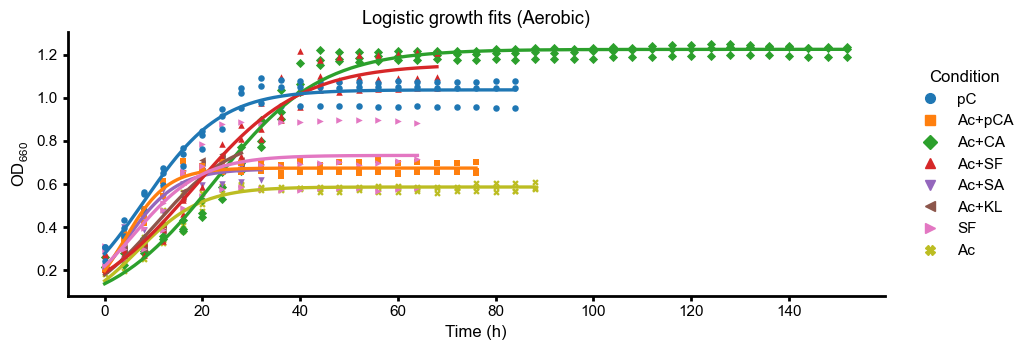

Aerobic overlay saved: growth_curve_fits/all_Aerobic_fits_mean_curves_with_scatter.png


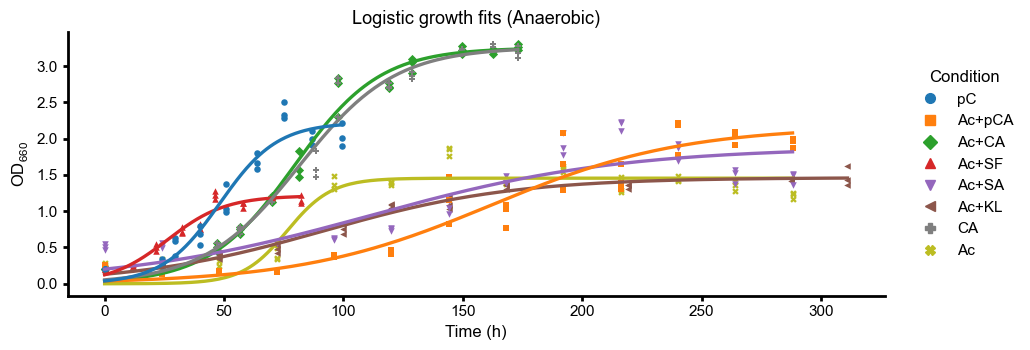

Anaerobic overlay saved: growth_curve_fits/all_Anaerobic_fits_mean_curves_with_scatter.png
Per-replicate plot index: growth_curve_fits/reps/plot_index.csv
Per-replicate parameter table: growth_curve_fits/longitudinal_logistic_fit_per_replicate.csv
Aerobic overlay: growth_curve_fits/all_Aerobic_fits_mean_curves_with_scatter.png
Anaerobic overlay: growth_curve_fits/all_Anaerobic_fits_mean_curves_with_scatter.png


In [46]:
# Plots for per-replicate logistic fits + summary overlay
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
from matplotlib.lines import Line2D

# ----------------------------
# Config
# ----------------------------
XLSX_PATH    = "growth_curve_fits/OD660_Data_use.xlsx"
SHEET        = "Longitudinal_Data"   # exact sheet name
OUT_PER      = "growth_curve_fits/longitudinal_logistic_fit_per_replicate.csv"
OUT_SUM      = "growth_curve_fits/longitudinal_logistic_summary.csv"
FALLBACK_CSV = "growth_curve_fits/OD660_Data_use_fallback.csv"  # adjust if needed

# ----------------------------
# Load data
# ----------------------------
if os.path.exists(XLSX_PATH):
    try:
        df = pd.read_excel(XLSX_PATH, sheet_name=SHEET)
    except Exception:
        df = pd.read_csv(FALLBACK_CSV)
else:
    df = pd.read_csv(FALLBACK_CSV)

# Standardize and clean column names
rename_map = {"Time (h)": "Time_h", "OD 660": "OD660", "Replicates": "Replicate"}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

for col in ["Time_h", "OD660"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["Condition", "Oxygen", "Replicate", "Time_h", "OD660"])
df = df[df["OD660"] > 0]

# Normalize Ac naming if needed (ensure "Ac")
df["Condition"] = df["Condition"].replace({
    "Acetate": "Ac",
    "Ac_ae": "Ac",
    "Ac_an": "Ac",
})

# ----------------------------
# Logistic model
# ----------------------------
def logistic(t, A, mu, t0):
    """Three-parameter logistic growth model."""
    return A / (1.0 + np.exp(-mu * (t - t0)))


def fit_logistic(group):
    """Fit logistic model to a single (Condition, Oxygen, Replicate) group."""
    d = group.sort_values("Time_h")
    t = d["Time_h"].to_numpy(dtype=float)
    y = d["OD660"].to_numpy(dtype=float)

    if len(t) < 5:
        return None

    # Initial guesses
    ymax = np.nanmax(y)
    A0 = float(ymax * 1.05) if np.isfinite(ymax) else 1.0
    t0_0 = float(np.median(t))

    eps = 1e-9
    y_clip = np.clip(y, eps, A0 - eps)
    with np.errstate(divide="ignore", invalid="ignore"):
        logit = np.log(y_clip / (A0 - y_clip))
        mu0 = np.nanmedian(np.diff(logit) / np.diff(t)) if len(t) >= 3 else np.nan

    if (not np.isfinite(mu0)) or mu0 <= 0:
        mu0 = 0.02  # conservative default

    lower = [1e-6, 1e-6, -np.inf]
    upper = [10.0 * max(1.0, ymax), 5.0, np.inf]

    try:
        popt, pcov = curve_fit(
            logistic,
            t,
            y,
            p0=[A0, mu0, t0_0],
            bounds=(lower, upper),
            maxfev=20000,
        )
        yhat = logistic(t, *popt)
        ss_res = float(np.sum((y - yhat) ** 2))
        ss_tot = float(np.sum((y - np.mean(y)) ** 2) + 1e-12)
        r2 = 1.0 - ss_res / ss_tot
        return {"params": popt, "r2": r2}
    except Exception:
        return None


# ----------------------------
# Per-replicate plots
# ----------------------------
out_dir = "growth_curve_fits/reps"
os.makedirs(out_dir, exist_ok=True)


def safe_name(s):
    s = str(s)
    s = re.sub(r"[^A-Za-z0-9_.-]+", "_", s)
    return s.strip("_") or "plot"


plot_index = []
fit_records = []  # store fit parameters

for (cond, oxy, rep), group in df.groupby(["Condition", "Oxygen", "Replicate"]):
    fit = fit_logistic(group)
    if fit is None:
        continue

    A, mu, t0 = fit["params"]
    r2 = fit["r2"]

    # Grid for smooth fit curve
    t = group["Time_h"].to_numpy(dtype=float)
    t_grid = np.linspace(t.min(), t.max(), 200)
    y_grid = logistic(t_grid, A, mu, t0)

    # Figure per replicate
    fig, ax = plt.subplots(figsize=(4.0, 3.0))
    ax.scatter(group["Time_h"], group["OD660"], label="Observed", s=15, alpha=0.7)
    ax.plot(t_grid, y_grid, label="Logistic fit", linewidth=1.3)

    ax.set_xlabel("Time (h)", fontsize=9)
    ax.set_ylabel("OD$_{660}$", fontsize=9)
    ax.set_title(
        f"{cond} | {oxy} | Rep {rep}\n"
        rf"$\mu={mu:.4f}\,\mathrm{{h^{{-1}}}},\ A={A:.3f},\ t_0={t0:.2f}\,\mathrm{{h}},\ R^2={r2:.3f}$",
        fontsize=9,
    )
    ax.tick_params(axis="both", labelsize=8)
    ax.legend(fontsize=7, frameon=False)

    # Remove top/right spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    fname = f"{safe_name(cond)}__{safe_name(oxy)}__rep{safe_name(rep)}.png"
    fpath = os.path.join(out_dir, fname)
    fig.tight_layout()
    fig.savefig(fpath, dpi=300)
    plt.close(fig)

    plot_index.append(
        {
            "Condition": cond,
            "Oxygen": oxy,
            "Replicate": rep,
            "file": fpath,
            "mu_per_hr": mu,
            "A": A,
            "t0_h": t0,
            "R2": r2,
        }
    )

    fit_records.append(
        {
            "Condition": cond,
            "Oxygen": oxy,
            "Replicate": rep,
            "mu_per_hr": mu,
            "A": A,
            "t0_h": t0,
            "R2": r2,
        }
    )

# Index of per-replicate plots
plot_index_df = pd.DataFrame(plot_index)
plot_index_csv = os.path.join(out_dir, "plot_index.csv")
plot_index_df.to_csv(plot_index_csv, index=False)

# Table of fit parameters
fit_df = pd.DataFrame(fit_records)
fit_df.to_csv(OUT_PER, index=False)

# ----------------------------
# Shared settings for overlays
# ----------------------------

# Oxygen colors (fixed)
O2_COLORS = {
    "Aerobic":   "#1f77b4",  # blue
    "Anaerobic": "#d62728",  # red
}

def norm_o2_label(oxy):
    s = str(oxy).strip().lower()
    return "Aerobic" if s.startswith("aerobic") else "Anaerobic"

if fit_df.empty:
    raise ValueError("fit_df is empty; no successful logistic fits found.")

# FINAL substrate order (Ac last)
COND_ORDER = [
    "pC",
    "Ac+pCA",
    "Ac+CA",
    "Ac+SF",
    "Ac+SA",
    "Ac+KL",
    "SF",
    "CA",
    "Ac",      # Acetate LAST
]

COND_MARKERS = {
    "pC":     "o",
    "Ac+pCA": "s",
    "Ac+CA":  "D",
    "Ac+SF":  "^",
    "Ac+SA":  "v",
    "Ac+KL":  "<",
    "SF":     ">",
    "CA":     "P",
    "Ac":     "X",   # Acetate marker
}

fig_scale = 0.8

# ----------------------------
# Helper to plot one oxygen regime
# ----------------------------
# ----------------------------
# Color palette for conditions (not oxygen)
# ----------------------------
palette = sns.color_palette("tab10", len(COND_ORDER))
condition_colors = {cond: palette[i] for i, cond in enumerate(COND_ORDER)}


def plot_overlay_for_regime(target_o2_label, outfile_png):
    """
    target_o2_label: "Aerobic" or "Anaerobic"
    """
    fig, ax = plt.subplots(figsize=(6.5 * 2 * fig_scale, 4.5 * fig_scale))

    # Filter fit_df rows belonging to this regime
    sub_fit = fit_df.copy()
    sub_fit["O2_label"] = sub_fit["Oxygen"].apply(norm_o2_label)
    sub_fit = sub_fit[sub_fit["O2_label"] == target_o2_label]

    # ----------------------------
    # SCATTER + MEAN CURVES
    # ----------------------------
    for (cond, oxy), sub in sub_fit.groupby(["Condition", "Oxygen"]):

        if cond not in COND_MARKERS:
            continue

        marker = COND_MARKERS[cond]
        color  = condition_colors[cond]

        # Mean logistic params
        mu_mean = sub["mu_per_hr"].mean()
        A_mean  = sub["A"].mean()
        t0_mean = sub["t0_h"].mean()

        # Get scatter data
        mask   = (df["Condition"] == cond) & (df["Oxygen"] == oxy)
        df_sub = df.loc[mask]

        # Scatter points
        ax.scatter(
            df_sub["Time_h"],
            df_sub["OD660"],
            color=color,
            marker=marker,
            # alpha=0.5,
            s=22,
            linewidths=0,
            zorder=1,
        )

        # Plot mean logistic curve
        if df_sub.empty:
            continue

        t_grid = np.linspace(df_sub["Time_h"].min(), df_sub["Time_h"].max(), 200)
        y_grid = logistic(t_grid, A_mean, mu_mean, t0_mean)

        ax.plot(
            t_grid,
            y_grid,
            color=color,
            linewidth=2.4,
            label=f"{cond}",
            zorder=3,
        )

    # ----------------------------
    # Axis styling
    # ----------------------------
    ax.set_xlabel("Time (h)", fontsize=12)
    ax.set_ylabel("OD$_{660}$", fontsize=12)
    ax.set_title(f"Logistic growth fits ({target_o2_label})", fontsize=13)
    ax.tick_params(axis="both", labelsize=11)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # ----------------------------
    # Condition legend (marker + color)
    # ----------------------------
    present_conditions = [c for c in COND_ORDER if c in sub_fit["Condition"].unique()]

    cond_handles = [
        Line2D(
            [0],
            [0],
            marker=COND_MARKERS[c],
            linestyle="None",
            color=condition_colors[c],
            markersize=7,
        )
        for c in present_conditions
    ]

    legend_cond = ax.legend(
        cond_handles,
        present_conditions,
        title="Condition",
        fontsize=11,
        title_fontsize=12,
        bbox_to_anchor=(1.02, 0.5),
        loc="center left",
        frameon=False,
        ncol=1,
    )

    fig.tight_layout()
    fig.savefig(outfile_png, dpi=600)
    plt.show()

    print(f"{target_o2_label} overlay saved:", outfile_png)



# ----------------------------
# Generate two separate figures: Aerobic and Anaerobic
# ----------------------------

# out_aer = "growth_curve_fits/all_Aerobic_fits_mean_curves_with_scatter.png"
# out_an  = "growth_curve_fits/all_Anaerobic_fits_mean_curves_with_scatter.png"

out_aer = "figures/FigS1A_all_Aerobic_fits_mean_curves_with_scatter.png"
out_an  = "figures/FigS1B_all_Anaerobic_fits_mean_curves_with_scatter.png"

plot_overlay_for_regime("Aerobic", out_aer)
plot_overlay_for_regime("Anaerobic", out_an)

print("Per-replicate plot index:", plot_index_csv)
print("Per-replicate parameter table:", OUT_PER)
print("Aerobic overlay:", out_aer)
print("Anaerobic overlay:", out_an)


# Get Figure 1 other elements

In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager as fm
from pathlib import Path
from scipy.cluster.hierarchy import linkage
import seaborn as sns

# ---------------------------------------------------------------------
# 0. Font & global style
# ---------------------------------------------------------------------
arial_path = "data/arial.ttf"
arial_font = fm.FontProperties(fname=arial_path)

fm.fontManager.addfont(arial_path)
rcParams["font.family"] = arial_font.get_name()

mpl.rcParams.update({
    "font.family": "Arial",
    "mathtext.default": "regular",
    "axes.linewidth": 1.5,
    "lines.linewidth": 1.5,
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "figure.dpi": 300,
})

def _journal_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    # ax.yaxis.set_ticks_position("left")
    # ax.xaxis.set_ticks_position("bottom")
    # ax.tick_params(width=1.5, length=4)

# ---------------------------------------------------------------------
# Condition ordering and meta labels
# ---------------------------------------------------------------------
COND_ORDER = [
    # Aerobic
    "pC_ae", "Ac+pCA_ae", "Ac+CA_ae", "Ac+SF_ae",
    "Ac+SA_ae", "Ac+KL_ae", "SF_ae", "Ac_ae",
    # Anaerobic
    "pC_an", "Ac+pCA_an", "Ac+CA_an", "Ac+SF_an",
    "Ac+SA_an", "Ac+KL_an", "CA_an", "Ac_an",
]

COND_META = {
    "pC_ae":      ("pC",      "Aerobic"),
    "Ac+pCA_ae":  ("Ac+pCA",  "Aerobic"),
    "Ac+CA_ae":   ("Ac+CA",   "Aerobic"),
    "Ac+SF_ae":   ("Ac+SF",   "Aerobic"),
    "Ac+SA_ae":   ("Ac+SA",   "Aerobic"),
    "Ac+KL_ae":   ("Ac+KL",   "Aerobic"),
    "SF_ae":      ("SF",      "Aerobic"),
    "Ac_ae":      ("Acetate", "Aerobic"),
    "pC_an":      ("pC",      "Anaerobic"),
    "Ac+pCA_an":  ("Ac+pCA",  "Anaerobic"),
    "Ac+CA_an":   ("Ac+CA",   "Anaerobic"),
    "Ac+SF_an":   ("Ac+SF",   "Anaerobic"),
    "Ac+SA_an":   ("Ac+SA",   "Anaerobic"),
    "Ac+KL_an":   ("Ac+KL",   "Anaerobic"),
    "CA_an":      ("CA",      "Anaerobic"),
    "Ac_an":      ("Acetate", "Anaerobic"),
}

# ---------------------------------------------------------------------
# 1. Data loading (OmniProt block)
# ---------------------------------------------------------------------
ProteomicsDataFile = "data/proteomics_data.xlsx"

df = pd.read_excel(ProteomicsDataFile, sheet_name="Sheet1")

feat_df = df.iloc[:, 5:1862].copy()
X = feat_df.to_numpy(dtype=np.float32)
feature_names = feat_df.columns.astype(str)
feature_names_upper = feature_names.str.upper()

y = df[["GR_mean", "GR_sd"]].to_numpy(dtype=np.float32)
y_meta = df[["Condition", "Oxygen", "Replicate",
             "Condition_key", "Condition_key_rep"]]

n_samples, n_features = X.shape
print("Data loaded: X.shape =", X.shape, ", y.shape =", y.shape)

cond_keys = y_meta["Condition_key"].to_numpy()
all_groups = pd.unique(cond_keys)

name_to_idx = {name: i for i, name in enumerate(feature_names_upper)}

# ---------------------------------------------------------------------
# 2. Build proteome matrix: mean per condition (proteins x conditions)
# ---------------------------------------------------------------------
matrix = feat_df.copy()
matrix["Condition_key"] = y_meta["Condition_key"]

proteome_mean = (
    matrix.groupby("Condition_key")
          .mean()
          .T   # rows: proteins, columns: conditions
)

proteome_no_growth = proteome_mean.copy()

# Reorder columns to desired condition order (subset if needed)
available_conds = [c for c in COND_ORDER if c in proteome_no_growth.columns]
proteome_no_growth = proteome_no_growth[available_conds]

# ---------------------------------------------------------------------
# 3. Column-normalized z-score (per condition)
# ---------------------------------------------------------------------
col_z = proteome_no_growth.sub(proteome_no_growth.mean(axis=0), axis=1)
col_z = col_z.div(proteome_no_growth.std(axis=0), axis=1)

# ---------------------------------------------------------------------
# 4. Clustering and clustermap
# ---------------------------------------------------------------------
row_link = linkage(col_z, method="ward", metric="euclidean")
col_link = linkage(col_z.T, method="ward", metric="euclidean")

scale=1.8
figsize = (2.52*scale, 2.33*scale)

g = sns.clustermap(
    col_z,
    row_linkage=row_link,
    col_linkage=col_link,
    cmap="viridis",
    figsize=figsize,
    xticklabels=True,
    yticklabels=False,
    dendrogram_ratio=(0.05, 0.05),
    cbar_kws={"label": "Column-normalized z-score"},
    # cbar_pos=(0.86, 0.25, 0.03, 0.50),  # x, y, width, height
    cbar_pos=None,   # TURN OFF DEFAULT COLORBAR
)

ax = g.ax_heatmap
_journal_axes(ax)

# ---------------------------------------------------------------------
# Custom colorbar placement (Nature-style)
# ---------------------------------------------------------------------
# Heatmap image object
heatmap = g.ax_heatmap.collections[0]

# New axes for colorbar - tuned for 2.52 × 2.33 in panel
cbar_ax = g.fig.add_axes([0.84+0.01, 0.70, 0.025, 0.20])
# [left, bottom, width, height] in figure coordinates

cbar = g.fig.colorbar(heatmap, cax=cbar_ax)
cbar.ax.set_ylabel(
    "Column-normalized z-score",
    rotation=270,
    labelpad=7,
    fontsize=7
)
cbar.ax.tick_params(labelsize=6, width=1.0, length=3)

# ---------------------------------------------------------------------
# 4a. Fix xticks to align with heatmap cells
# ---------------------------------------------------------------------
SHAP_COLS = g.data2d.columns.tolist()
ncols = len(SHAP_COLS)

# Cell centers at 0.5, 1.5, ..., (ncols-0.5)
xtick_positions = np.arange(ncols) + 0.5
ax.set_xticks(xtick_positions)

short_labels = [COND_META.get(c, (c, ""))[0] for c in SHAP_COLS]
ax.set_xticklabels(short_labels, rotation=45, ha="right", fontsize=6)

ax.set_xlim(0, ncols)
ax.set_xlabel("Condition", fontsize=7)
ax.set_ylabel("Proteins", fontsize=7)

ax.spines["left"].set_visible(False)

ax.tick_params(left=False)  # no tick marks on the left

# ---------------------------------------------------------------------
# 4b. Aerobic / Anaerobic grouping that respects clustering order
# ---------------------------------------------------------------------
aer_idx = [i for i, c in enumerate(SHAP_COLS)
           if COND_META.get(c, ("", ""))[1] == "Aerobic"]
ana_idx = [i for i, c in enumerate(SHAP_COLS)
           if COND_META.get(c, ("", ""))[1] == "Anaerobic"]

if aer_idx and ana_idx:
    groups = {
        "Aerobic": {
            "mid": (min(aer_idx) + max(aer_idx) + 1) / 2.0,  # in cell-space
            "end": max(aer_idx) + 1.0,                       # right edge
        },
        "Anaerobic": {
            "mid": (min(ana_idx) + max(ana_idx) + 1) / 2.0,
            "end": max(ana_idx) + 1.0,
        },
    }

    # Sort groups by mid-position, so left/right follows clustering
    ordered = sorted(groups.keys(), key=lambda gname: groups[gname]["mid"])
    left_group, right_group = ordered[0], ordered[1]

    # Twin axis for group labels
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks([groups[left_group]["mid"], groups[right_group]["mid"]])
    ax2.set_xticklabels(ordered, fontsize=7, fontweight="bold")
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("outward", 20))
    ax2.tick_params(length=0)
    ax2.spines["bottom"].set_visible(False)

    # Separator line at the boundary between the two groups
    sep_pos = groups[left_group]["end"]
    ax.axvline(sep_pos, color="k", linewidth=2.0, zorder=10)



# ---------------------------------------------------------------------
# 5. Layout and save
# ---------------------------------------------------------------------
g.fig.subplots_adjust(top=0.95, bottom=0.28, left=0.22, right=0.80)

out_dir = Path("figures/")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "Fig1D_Proteome_Heatmap_Clustered_ColumnNorm.png"

g.savefig(out_path, dpi=300, bbox_inches="tight")
print("Saved figure to:", out_path)

plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager as fm
from matplotlib.lines import Line2D
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# =====================================================================
# 0. Global plotting style (match OmniProt figures)
# =====================================================================

arial_path = "data/arial.ttf"
arial_font = fm.FontProperties(fname=arial_path)

fm.fontManager.addfont(arial_path)
rcParams["font.family"] = arial_font.get_name()

mpl.rcParams.update({
    "font.family": "Arial",
    "mathtext.default": "regular",
    "axes.linewidth": 1.5,
    "lines.linewidth": 1.5,
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "figure.dpi": 300,
})

def _journal_axes_pca(ax):
    """
    Apply journal-style axes: left & bottom spines only,
    consistent tick styling.
    """
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    ax.tick_params(width=1.5, length=4)


# =====================================================================
# 1. Condition metadata: mapping Condition_key -> (substrate, oxygen)
# =====================================================================

COND_ORDER = [
    "pC_ae", "Ac+pCA_ae", "Ac+CA_ae", "Ac+SF_ae",
    "Ac+SA_ae", "Ac+KL_ae", "SF_ae", "Ac_ae",
    "pC_an", "Ac+pCA_an", "Ac+CA_an", "Ac+SF_an",
    "Ac+SA_an", "Ac+KL_an", "CA_an", "Ac_an",
]

# (short substrate label, oxygen regime)
COND_META = {
    "pC_ae":      ("pC",      "Aerobic"),
    "Ac+pCA_ae":  ("Ac+pCA",  "Aerobic"),
    "Ac+CA_ae":   ("Ac+CA",   "Aerobic"),
    "Ac+SF_ae":   ("Ac+SF",   "Aerobic"),
    "Ac+SA_ae":   ("Ac+SA",   "Aerobic"),
    "Ac+KL_ae":   ("Ac+KL",   "Aerobic"),
    "SF_ae":      ("SF",      "Aerobic"),
    "Ac_ae":      ("Acetate", "Aerobic"),
    "pC_an":      ("pC",      "Anaerobic"),
    "Ac+pCA_an":  ("Ac+pCA",  "Anaerobic"),
    "Ac+CA_an":   ("Ac+CA",   "Anaerobic"),
    "Ac+SF_an":   ("Ac+SF",   "Anaerobic"),
    "Ac+SA_an":   ("Ac+SA",   "Anaerobic"),
    "Ac+KL_an":   ("Ac+KL",   "Anaerobic"),
    "CA_an":      ("CA",      "Anaerobic"),
    "Ac_an":      ("Acetate", "Anaerobic"),
}

# Oxygen regime encoded by POINT COLOR
O2_COLORS = {
    "Aerobic":   "#1f77b4",  # blue
    "Anaerobic": "#d62728",  # red
}


# =====================================================================
# 2. Data loading (same OmniProt block)
# =====================================================================

ProteomicsDataFile = "data/proteomics_data.xlsx"

df = pd.read_excel(ProteomicsDataFile, sheet_name="Sheet1")

# Proteomic features: same slice as in your OmniProt pipeline
feat_df = df.iloc[:, 5:1862].copy()
X = feat_df.to_numpy(dtype=np.float32)
feature_names = feat_df.columns.astype(str)

# Growth targets (not used here) and metadata
y = df[["GR_mean", "GR_sd"]].to_numpy(dtype=np.float32)
y_meta = df[["Condition", "Oxygen", "Replicate",
             "Condition_key", "Condition_key_rep"]]

n_samples, n_features = X.shape
print(f"Data loaded: X.shape = {X.shape}, y.shape = {y.shape}")

# Condition_key and Oxygen codes per sample
cond_keys = y_meta["Condition_key"].to_numpy()
oxy_codes = y_meta["Oxygen"].to_numpy()


# =====================================================================
# 3. PCA on sample-level proteomes
# =====================================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

expl_var = pca.explained_variance_ratio_ * 100.0
pc1_var, pc2_var = expl_var[0], expl_var[1]

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Condition_key": cond_keys,
    "Oxygen_raw": oxy_codes,
})

oxygen_map = {
    "ae": "Aerobic",
    "an": "Anaerobic",
    "Aerobic": "Aerobic",
    "Anaerobic": "Anaerobic",
}
pca_df["Oxygen_label"] = pca_df["Oxygen_raw"].map(oxygen_map)

# Map Condition_key to short substrate label
pca_df["Substrate_short"] = pca_df["Condition_key"].map(
    lambda ck: COND_META[ck][0]
)


# =====================================================================
# 4. Marker assignment: same substrate  same marker
# =====================================================================

cond_names_for_markers = [
    ck for ck in COND_ORDER if ck in pca_df["Condition_key"].unique()
]
short_labels = [COND_META[ck][0] for ck in cond_names_for_markers]

unique_short = []
for sl in short_labels:
    if sl not in unique_short:
        unique_short.append(sl)

# Enforce a sensible legend order (CA before Acetate)
SUBSTRATE_ORDER = [
    "pC", "Ac+pCA", "Ac+CA", "Ac+SF",
    "Ac+SA", "Ac+KL", "SF", "CA", "Acetate",
]

unique_short = sorted(
    unique_short,
    key=lambda s: SUBSTRATE_ORDER.index(s) if s in SUBSTRATE_ORDER else len(SUBSTRATE_ORDER)
)


MARKERS = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "d", "h", "H", "*", "8"]

short2marker = {
    sl: MARKERS[i % len(MARKERS)]
    for i, sl in enumerate(unique_short)
}


# =====================================================================
# 5. PCA plot: replicates (O2 color + substrate marker) + centroids
# =====================================================================

scale = 1.0  # for on-screen; set to 1 for exact 2.52 x 2.33 inches
figsize = (3.33 * scale, 3.43 * scale)

fig, ax = plt.subplots(figsize=figsize)

# --- 5a. Scatter replicates ----
for _, row in pca_df.iterrows():
    cond  = row["Condition_key"]
    oxy   = row["Oxygen_label"]
    short = row["Substrate_short"]

    color  = O2_COLORS.get(oxy, "gray")
    marker = short2marker.get(short, "o")

    ax.scatter(
        row["PC1"],
        row["PC2"],
        s=30,
        marker=marker,
        facecolor=color,
        edgecolor="black",
        linewidth=0.9,
        alpha=0.9,
        zorder=3,
    )

# --- 5b. Condition centroids (mean PC1/PC2 per Condition_key) ----
centroids = (
    pca_df.groupby("Condition_key")[["PC1", "PC2"]]
          .mean()
          .reset_index()
)

for _, row in centroids.iterrows():
    ax.scatter(
        row["PC1"],
        row["PC2"],
        s=1,
        facecolor="black",
        edgecolor="black",
        linewidth=.01,
        zorder=4,
    )
    # ax.text(
    #     row["PC1"],
    #     row["PC2"],
    #     row["Condition_key"],
    #     fontsize=6,
    #     ha="center",
    #     va="center",
    #     zorder=5,
    # )

_journal_axes_pca(ax)

ax.set_xlabel(f"PC1 ({pc1_var:.1f}% variance)", fontsize=8)
ax.set_ylabel(f"PC2 ({pc2_var:.1f}% variance)", fontsize=8)


# =====================================================================
# 6. Legends: Oxygen (color) + Substrate (marker)
# =====================================================================

# Oxygen legend (color)
oxy_handles = []
for oxy_label in ["Aerobic", "Anaerobic"]:
    oxy_handles.append(
        Line2D(
            [], [],
            marker="o",
            markersize=6,
            linestyle="None",
            markerfacecolor=O2_COLORS[oxy_label],
            markeredgecolor="black",
            markeredgewidth=0.8,
            label=oxy_label,
        )
    )

legend_oxy = ax.legend(
    handles=oxy_handles,
    title="Oxygen",
    fontsize=6,
    title_fontsize=6,
    loc="upper right",
    frameon=False,
)
ax.add_artist(legend_oxy)

# Substrate legend (marker shapes only)
substrate_handles = []
for sl in unique_short:
    substrate_handles.append(
        Line2D(
            [], [],
            marker=short2marker[sl],
            markersize=6,
            linestyle="None",
            markerfacecolor="white",
            markeredgecolor="black",
            markeredgewidth=0.8,
            label=sl,
        )
    )

legend_sub = ax.legend(
    handles=substrate_handles,
    title="Substrates (LBPs)",
    fontsize=6,
    ncols=2,
    title_fontsize=6,
    loc="lower right",
    frameon=False,
)

fig.tight_layout()


# =====================================================================
# 7. Save figure
# =====================================================================

out_dir = Path("figures")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "Fig1E_Proteome_PCA_Conditions.png"

fig.savefig(out_path, dpi=300, bbox_inches="tight")
print("Saved PCA figure to:", out_path)

plt.show()


In [ ]:
import pandas as pd

# Path to your file
xlsx_path =  "results/output.xlsx" 

# Load the sheet
df = pd.read_excel(xlsx_path, sheet_name="pan_condition")
df = df[df['consensus_pass']]

# Check unique labels
print("Quadrant labels found:", df["quad"].unique())

# Count of each quadrant
quad_counts = df["quad"].value_counts().sort_index()

print("\nCounts per quadrant:")
print(quad_counts)

# If you want percentages too:
quad_percent = (df["quad"].value_counts(normalize=True) * 100).round(2)

print("\nPercent per quadrant:")
print(quad_percent)


# Run LOOCV of OmniProt pipeline

## Utilities

In [ ]:
# -------------------------
# -------------------------
# Utilities
# -------------------------
# -------------------------
# ---- Standard library
import os
import sys
import math
import re
import random
import warnings
from math import sqrt
from typing import Any, Optional, Sequence, Dict, Union, Callable, Tuple
from collections import defaultdict, Counter
from pathlib import Path

# ---- Core numerics & utils
import numpy as np
import pandas as pd
import shap
from joblib import Parallel, delayed
from scipy.stats import (
    ttest_ind,
    ttest_ind_from_stats,
    mannwhitneyu,
    pearsonr,
    spearmanr,
    truncnorm,
    f_oneway,
)
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# ---- Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib as mpl
from matplotlib.lines import Line2D

# ---- Excel I/O
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage  # Pillow-backed

# ---- Scikit-learn
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.dummy import DummyRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import ElasticNetCV, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import LeaveOneOut, GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

# ---- PyTorch / skorch (neural nets)
import torch
import torch.nn as nn
from skorch import NeuralNetRegressor
from skorch.dataset import ValidSplit, Dataset
from skorch.callbacks import LRScheduler, GradientNormClipping, EarlyStopping
from skorch.helper import predefined_split

# ---- Optuna (HPO)
import optuna
from optuna.samplers import TPESampler

# ---- Project helpers
# from functions_repo import *

# ============================================
# Reproducibility & GPU-determinism hints
# ============================================
RANDOM_STATE = 42
# Ensure deterministic CUDA math (where applicable)
os.environ.setdefault("PYTHONHASHSEED", "42")
os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")
os.environ.setdefault("NVIDIA_TF32_OVERRIDE", "0")
# Local seed utility (kept to preserve original behavior; later import of set_seed
# from functions_repo intentionally shadows this definition, as in the source code.)
def set_seed(seed=42):
    # RNG seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Deterministic kernels (raises if a non-deterministic op is used)
    torch.use_deterministic_algorithms(True)
    # cuDNN: no autotune; fixed choices
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # Turn TF32 OFF everywhere (important on A100/H100; harmless on V100)
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False
    # Prefer stable FP32 matmul route (avoid "highest" which may pick TF32-like paths)
    try:
        torch.set_float32_matmul_precision("highest")
    except Exception:
        pass
    # (Optional) stabilize CPU math if you ever eval on CPU
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    os.environ.setdefault("OMP_NUM_THREADS", "32")
    os.environ.setdefault("MKL_NUM_THREADS", "32")
    os.environ.setdefault("OPENBLAS_NUM_THREADS", "32")
    try:
        torch.set_num_threads(int(os.environ.get("OMP_NUM_THREADS", "32")))
    except Exception:
        pass
    # Guardrails: hard-assert nothing flipped TF32 back on
    assert not torch.backends.cuda.matmul.allow_tf32, "TF32 still ON for cuBLAS!"
    assert not torch.backends.cudnn.allow_tf32, "TF32 still ON for cuDNN!"

set_seed(42)


def _canon_acc2kegg(acc2kegg_df: pd.DataFrame) -> pd.DataFrame:
    """Standardize AccessionToKEGG to columns: UniProt, KEGG."""
    df = acc2kegg_df.copy()
    rename = {}
    for c in df.columns:
        cl = str(c).lower()
        if "uniprot" in cl or "accession" in cl:
            rename[c] = "UniProt"
        elif "kegg" in cl:
            rename[c] = "KEGG"
    if rename:
        df = df.rename(columns=rename)
    if "UniProt" not in df.columns or "KEGG" not in df.columns:
        if len(df.columns) >= 2:
            df = df.rename(columns={df.columns[0]: "UniProt", df.columns[1]: "KEGG"})
        else:
            raise ValueError("AccessionToKEGG must have at least two columns (UniProt, KEGG).")
    df["UniProt"] = df["UniProt"].astype(str).str.strip()
    df["KEGG"]    = df["KEGG"].astype(str).str.strip()
    df = df.dropna(subset=["UniProt"]).drop_duplicates()
    return df[["UniProt","KEGG"]].reset_index(drop=True)

def _build_to_uniprot_map(acc2kegg_df: pd.DataFrame) -> dict:
    """Dict that maps either UniProt or KEGG -> UniProt."""
    df = _canon_acc2kegg(acc2kegg_df)
    m = {}
    for _, r in df.iterrows():
        up = str(r["UniProt"]).strip()
        kg = str(r["KEGG"]).strip()
        if up:
            m[up] = up
        if kg and kg.lower() != "nan":
            m[kg] = up
    return m


def loocv_with_anchor_indices(cond_keys, always_train_keys):
    """
    Yields (train_idx, test_idx) where test is the FULL set of indices
    for one non-anchor Condition_key (i.e., all 5 replicates).
    """
    N = len(cond_keys)
    # All unique condition groups present in the data
    all_groups = pd.unique(cond_keys)
    # Candidate test groups = all groups except anchors (anchors must always remain in train)
    candidate_test_groups = [g for g in all_groups if g not in always_train_keys]
    for g in candidate_test_groups:
        # indices for the held-out test condition (all replicates)
        test_idx = np.where(cond_keys == g)[0]
        # everything else is train
        train_idx = np.setdiff1d(np.arange(N), test_idx)
        # sanity: anchors are not in test and remain in train
        assert not np.any(np.isin(cond_keys[test_idx], list(always_train_keys))), "Anchor leaked into test!"
        anchor_idx = np.where(np.isin(cond_keys, list(always_train_keys)))[0]
        assert np.all(np.isin(anchor_idx, train_idx)), "Anchor missing from train!"
        yield train_idx, test_idx

# Helpful for the percentage-accuracy metric to avoid division-by-zero
EPS = 1e-12

def augment_labels_normal(X_train, y_train, K=5, rng=42, min_gr=0.0, truncated=True, eps=1e-12, return_indices=False):
    """
    X_train : (N, d)
    y_train : (N, 2) with [:,0]=GR_mean (mu), [:,1]=GR_sd (sd)

    Returns:
      X_all : (N + N*K, d)  -> originals first, then all augmented rows
      y_all : (N + N*K, 2)  -> for augmented: [:,0] are sampled GRs, [:,1] keeps sd
      (opt) idx_orig : slice or array of indices for originals (0..N-1)
      (opt) idx_aug  : slice or array of indices for augmented (N..N+N*K-1)
    """
    rs = np.random.RandomState(rng)

    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.float64)
    mu = y_train[:, 0]
    sd = np.maximum(y_train[:, 1], eps)  # avoid sd=0
    N = mu.shape[0]

    if K <= 0:
        # nothing to augment; just return originals
        if return_indices:
            return X_train, y_train.astype(np.float32), np.arange(N), np.array([], dtype=int)
        return X_train, y_train.astype(np.float32)

    if truncated:
        # vectorized truncated normal: shape (N, K)
        a = ((min_gr - mu) / sd)[:, None]                 # (N,1)
        b = np.full((N, 1), np.inf, dtype=np.float64)     # (N,1)
        loc = mu[:, None]                                 # (N,1)
        scale = sd[:, None]                               # (N,1)
        Ys = truncnorm.rvs(a, b, loc=loc, scale=scale, size=(N, K), random_state=rs)
    else:
        # plain normal, then clamp at min_gr
        noise = rs.normal(loc=0.0, scale=sd[:, None], size=(N, K))  # (N,K)
        Ys = np.maximum(mu[:, None] + noise, min_gr)

    # Build augmented block (all augmented AFTER originals)
    X_aug = np.repeat(X_train, K, axis=0)  # (N*K, d)
    y_aug = np.stack([Ys.ravel(), np.repeat(sd, K)], axis=1).astype(np.float32)  # (N*K, 2)

    # Concatenate: originals first, augmented after
    X_all = np.vstack([X_train, X_aug]).astype(np.float32)
    y_all = np.vstack([y_train.astype(np.float32), y_aug]).astype(np.float32)

    if return_indices:
        idx_orig = np.arange(0, N, dtype=int)
        idx_aug  = np.arange(N, N + N*K, dtype=int)
        return X_all, y_all, idx_orig, idx_aug
    return X_all, y_all

# === extra utilities ===
def _internal_split_sizes(n_train_fold, valid_frac=0.2):
    # Mirrors ValidSplit(0.2) rounding and guarantees at least 1 valid sample
    n_valid = max(1, int(round(valid_frac * n_train_fold)))
    n_train_internal = n_train_fold - n_valid
    return n_train_internal, n_valid

def percent_accuracy(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    den = np.maximum(np.abs(y_true), eps)           # elementwise
    rel_err = np.abs((y_true - y_pred) / den)
    return (1.0 - np.mean(rel_err)) * 100.0

def percent_accuracy_scalar(y_true_scalar, y_pred_scalar, eps=1e-12):
    den = max(abs(float(y_true_scalar)), eps)       # scalar
    rel_err = abs(float(y_true_scalar) - float(y_pred_scalar)) / den
    return (1.0 - rel_err) * 100.0

def smape(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.maximum(denom, eps)  # avoid 0/0
    return 100.0 * np.mean(np.abs(y_true - y_pred) / denom)

# --------- pick k random non-anchor conditions for validation (single split) ----------
def make_random_group_valid(train_idx, cond_keys, always_train_keys, k=2, rng=42):
    """
    From the outer train set, choose k condition groups (non-anchors) as validation.
    Returns (inner_train_idx, inner_valid_idx, chosen_groups).
    Assumes: global 'cond_keys' and 'always_train_keys' are defined.
    """
    rs = np.random.RandomState(rng)

    train_groups = cond_keys[train_idx]
    non_anchor_groups = np.unique(train_groups[~np.isin(train_groups, list(always_train_keys))])

    if len(non_anchor_groups) == 0:
        # No eligible groups -> no validation
        return train_idx, np.array([], dtype=int), []

    k_eff = min(k, len(non_anchor_groups))
    chosen = rs.choice(non_anchor_groups, size=k_eff, replace=False)

    valid_mask = np.isin(cond_keys[train_idx], chosen)
    inner_valid_idx = train_idx[valid_mask]
    inner_train_idx = np.setdiff1d(train_idx, inner_valid_idx)

    return inner_train_idx, inner_valid_idx, chosen.tolist()


# --------- LOOCV with single random-k-group validation per outer fold ----------
def loocv_scores(pipe, X, y,  cond_keys, always_train_keys, k_valid_groups=2, rng=42, K_AUG=200):
    mse_scores, rmse_scores, mae_scores, acc_scores, smape_scores = [], [], [], [], []
    y_pred_all = np.zeros(y.shape[0], dtype=float)
    fold_info = []

    # ----- condition-level accumulators -----
    cond_mse_scores, cond_rmse_scores, cond_mae_scores = [], [], []
    cond_pred_dict, cond_true_dict = {}, {}

    def _cv(a, eps=1e-12):
        a = np.asarray(a, float)
        if a.size <= 1:
            return 0.0
        m = float(np.mean(a))
        s = float(np.std(a, ddof=1))
        return s / (m + eps)

    for fold_idx, (train_idx, test_idx) in enumerate(loocv_with_anchor_indices(cond_keys, always_train_keys), start=1):
        # ----- single inner split: randomly pick k groups for validation -----
        inner_train_idx, inner_valid_idx, valid_groups = make_random_group_valid(
            train_idx, cond_keys, always_train_keys, k=k_valid_groups, rng=rng
        )

        X_train, y_train = X[inner_train_idx], y[inner_train_idx]
        # ===== augment labels on the train partition only =====
        X_train_aug, y_train_aug = augment_labels_normal(
            X_train, y_train, K=K_AUG, rng=rng, min_gr=0.0, truncated=True
        )

        fold_pipe = clone(pipe)

        # Inject validation for EarlyStopping (exactly like ValidSplit but predefined)
        if inner_valid_idx.size > 0:
            X_valid, y_valid = X[inner_valid_idx], y[inner_valid_idx]
            valid_ds = Dataset(X_valid.astype(np.float32, copy=False),
                               y_valid.astype(np.float32, copy=False))
            fold_pipe.set_params(
                net__train_split=predefined_split(valid_ds),
                net__callbacks=[LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', factor=0.5, patience=5, min_lr=1e-6, cooldown=0),
                                GradientNormClipping(1.0),
                                EarlyStopping(patience=50, monitor='valid_loss', load_best=True)],
                net__criterion__min_var=1e-4,
                net__iterator_train__shuffle=False,
                net__iterator_train__num_workers=0,
                net__iterator_valid__shuffle=False,
                net__iterator_valid__num_workers=0,
            )
        else:
            fold_pipe.set_params(
                net__train_split=None, net__callbacks=[],
                net__iterator_train__shuffle=False,
                net__iterator_train__num_workers=0,
                net__iterator_valid__shuffle=False,
                net__iterator_valid__num_workers=0,
            )
            
        set_seed(42)
        # >>> minimal but critical change: use augmented data <<<
        fold_pipe.fit(X_train_aug, y_train_aug)

        # ===== outer test with the trained model =====
        X_test, y_test = X[test_idx], y[test_idx]
        y_pred = fold_pipe.predict(X_test).ravel()
        y_true_vec = y_test[:, 0].ravel()   # GR_mean per replicate
        y_sd_vec   = y_test[:, 1].ravel()   # provided true SD per replicate (identical within condition)

        # ---------- replicate-level metrics ----------
        mse_rep  = mean_squared_error(y_true_vec, y_pred)
        rmse_rep = np.sqrt(mse_rep)
        mae_rep  = mean_absolute_error(y_true_vec, y_pred)
        mse_scores.append(mse_rep); rmse_scores.append(rmse_rep)
        mae_scores.append(mae_rep)

        # store replicate predictions
        y_pred_all[test_idx] = y_pred

        # ================= condition-level metrics via per-condition means =================
        conds_in_fold = np.unique(cond_keys[test_idx])
        for group_name in conds_in_fold:
            loc = np.where(cond_keys[test_idx] == group_name)[0]
            y_true_c = y_true_vec[loc]
            y_pred_c = y_pred[loc]
            y_sd_c   = y_sd_vec[loc]

            # per-condition means
            y_true_scalar = float(np.mean(y_true_c))
            y_pred_mean   = float(np.mean(y_pred_c))

            # metrics based on condition means
            cond_mse  = (y_pred_mean - y_true_scalar) ** 2
            cond_rmse = np.sqrt(cond_mse)
            cond_mae  = abs(y_pred_mean - y_true_scalar)
            cond_mse_scores.append(cond_mse)
            cond_rmse_scores.append(cond_rmse)
            cond_mae_scores.append(cond_mae)
            
            # store per-condition means (the fold where this condition is tested provides its estimate)
            cond_pred_dict[group_name] = y_pred_mean
            cond_true_dict[group_name] = y_true_scalar
        # =====================================================================

        # ----- robust inspection (best epoch / valid loss / ES flag) -----
        net = fold_pipe.named_steps['net']
        # print("skorch device:", net.device)   # should say 'cuda'
        epochs_run = len(net.history)
        early_stopped = epochs_run < net.max_epochs

        best_epoch = None
        best_valid_loss = None
        if epochs_run > 0 and 'valid_loss' in net.history[0]:
            try:
                best_row = min(net.history, key=lambda r: r.get('valid_loss', float('inf')))
                best_epoch = best_row.get('epoch')
                best_valid_loss = best_row.get('valid_loss')
            except ValueError:
                pass
        try:
            es = next(cb for name, cb in net.callbacks_ if isinstance(cb, EarlyStopping))
            best_epoch = getattr(es, 'best_epoch_', best_epoch)
            best_valid_loss = getattr(es, 'best_score_', best_valid_loss)
        except StopIteration:
            pass

        fold_info.append({
            "fold": fold_idx,
            "outer_test_idx": int(test_idx[0]),
            "outer_test_cond": str(conds_in_fold[0]),
            "n_train_fold": int(len(train_idx)),
            "n_train_internal": int(len(inner_train_idx)),
            "n_valid_internal": int(len(inner_valid_idx)),
            "valid_groups": list(valid_groups),
            "epochs_run": epochs_run,
            "best_epoch": None if best_epoch is None else int(best_epoch),
            "best_valid_loss": None if best_valid_loss is None else float(best_valid_loss),
            "early_stopped": bool(early_stopped),
        })

        import gc, torch
        del fold_pipe
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # ---------- replicate-level summary ----------
    replicate_summary = {
        'MSE_mean':  float(np.mean(mse_scores)),  'MSE_sd':  float(np.std(mse_scores)),
        'RMSE_mean': float(np.mean(rmse_scores)), 'RMSE_sd': float(np.std(rmse_scores)),
        'MAE_mean':  float(np.mean(mae_scores)),  'MAE_sd':  float(np.std(mae_scores)),
        'y_pred_all': y_pred_all,
        'fold_info': fold_info,
    }

    # ---------- condition-level summary (+ Spearman on condition means) ----------
    COND_MSE_mean  = float(np.mean(cond_mse_scores));  COND_MSE_sd  = float(np.std(cond_mse_scores))
    COND_RMSE_mean = float(np.mean(cond_rmse_scores)); COND_RMSE_sd = float(np.std(cond_rmse_scores))
    
    cond_names = list(cond_true_dict.keys())
    true_vec   = np.array([cond_true_dict[k] for k in cond_names]) if cond_names else np.array([])
    pred_vec   = np.array([cond_pred_dict[k] for k in cond_names]) if cond_names else np.array([])
    if true_vec.size > 1 and pred_vec.size > 1:
        spearman_rho, spearman_p = spearmanr(true_vec, pred_vec)
        pearson_r, pearson_p = pearsonr(true_vec, pred_vec)
    else:
        spearman_rho, spearman_p = np.nan, np.nan
        pearson_r, pearson_p = np.nan, np.nan

    return {
        **replicate_summary,
        'COND_MSE_mean':  COND_MSE_mean,   'COND_MSE_sd':  COND_MSE_sd,
        'COND_RMSE_mean': COND_RMSE_mean,  'COND_RMSE_sd': COND_RMSE_sd,
        'COND_SPEARMAN_R': float(spearman_rho),
        'COND_SPEARMAN_P': float(spearman_p),
        'COND_PEARSON_R': float(pearson_r),
        'COND_PEARSON_P': float(pearson_p),

        # expose per-condition means and CVs for inspection
        'COND_MEAN_TRUE': cond_true_dict,
        'COND_MEAN_PRED': cond_pred_dict,
    }

def print_summary(name, summary, y, show_condition_level=True):
    """
    Pretty-print LOOCV results (safe ASCII only) with optional condition-level
    metrics and CV diagnostics.
    """
    import numpy as np
    from scipy.stats import pearsonr

    # Use GR_mean if y has two columns; otherwise use y as-is
    y_true = np.asarray(y)
    if y_true.ndim == 2 and y_true.shape[1] >= 1:
        y_true = y_true[:, 0]
    y_true = y_true.ravel()
    y_pred_all = np.asarray(summary.get('y_pred_all', []))

    # Safe Pearson (mask non-finite and size-align)
    mask = np.isfinite(y_true) & np.isfinite(y_pred_all) & (np.arange(y_true.size) < y_pred_all.size)
    if mask.sum() >= 2:
        r, p = pearsonr(y_true[mask], y_pred_all[mask])
    else:
        r, p = np.nan, np.nan

    # ---------------- Replicate-level prints ----------------
    print(f"\n=== {name} (LOOCV) ===")
        # ---------------- Condition-level metrics ----------------
    if show_condition_level and 'COND_MSE_mean' in summary:
        print("\n-- Condition-level (means over replicates) --")
        print(f"RMSE:  {summary.get('COND_RMSE_mean', float('nan')):.6f} +/- {summary.get('COND_RMSE_sd', float('nan')):.6f}")
        if 'COND_SPEARMAN_R' in summary:
            print(f"Spearman (cond means): {summary.get('COND_SPEARMAN_R', float('nan')):.4f} "
                  f"(p={summary.get('COND_SPEARMAN_P', float('nan')):.3g})")
        if 'COND_PEARSON_R' in summary:
            print(
                f"Pearson (cond means):  {summary.get('COND_PEARSON_R', float('nan')):.4f} "
                f"(p={summary.get('COND_PEARSON_P', float('nan')):.3g})"
            )


## Run code

In [ ]:
# =====================================================================
# IMPORTS & REPRODUCIBILITY
# =====================================================================

# ---- Standard library
import os
import sys
import math
import re
import random
import warnings
from math import sqrt
from typing import Any, Optional, Sequence, Dict, Union, Callable, Tuple
from collections import defaultdict, Counter
from pathlib import Path

# ---- Core numerics & utils
import numpy as np
import pandas as pd
import shap
from joblib import Parallel, delayed
from scipy.stats import (
    ttest_ind,
    ttest_ind_from_stats,
    mannwhitneyu,
    pearsonr,
    spearmanr,
    truncnorm,
    f_oneway,
)
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# ---- Plotting
import matplotlib
# matplotlib.use('Agg')  # Use a non-interactive backend
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib as mpl
from matplotlib.lines import Line2D

# ---- Excel I/O
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage  # Pillow-backed

# ---- Scikit-learn
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.dummy import DummyRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import ElasticNetCV, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import LeaveOneOut, GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

# ---- PyTorch / skorch (neural nets)
import torch
import torch.nn as nn
from skorch import NeuralNetRegressor
from skorch.dataset import ValidSplit, Dataset
from skorch.callbacks import LRScheduler, GradientNormClipping, EarlyStopping
from skorch.helper import predefined_split

# ---- Optuna (HPO)
import optuna
from optuna.samplers import TPESampler

# ---- Project helpers
# from functions_repo import *

# ============================================
# Reproducibility & GPU-determinism hints
# ============================================
RANDOM_STATE = 42
# Ensure deterministic CUDA math (where applicable)
os.environ.setdefault("PYTHONHASHSEED", "42")
os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")
os.environ.setdefault("NVIDIA_TF32_OVERRIDE", "0")
# Local seed utility (kept to preserve original behavior; later import of set_seed
# from functions_repo intentionally shadows this definition, as in the source code.)
def set_seed(seed=42):
    # RNG seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Deterministic kernels (raises if a non-deterministic op is used)
    torch.use_deterministic_algorithms(True)
    # cuDNN: no autotune; fixed choices
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # Turn TF32 OFF everywhere (important on A100/H100; harmless on V100)
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False
    # Prefer stable FP32 matmul route (avoid "highest" which may pick TF32-like paths)
    try:
        torch.set_float32_matmul_precision("highest")
    except Exception:
        pass
    # (Optional) stabilize CPU math if you ever eval on CPU
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    os.environ.setdefault("OMP_NUM_THREADS", "32")
    os.environ.setdefault("MKL_NUM_THREADS", "32")
    os.environ.setdefault("OPENBLAS_NUM_THREADS", "32")
    try:
        torch.set_num_threads(int(os.environ.get("OMP_NUM_THREADS", "32")))
    except Exception:
        pass
    # Guardrails: hard-assert nothing flipped TF32 back on
    assert not torch.backends.cuda.matmul.allow_tf32, "TF32 still ON for cuBLAS!"
    assert not torch.backends.cudnn.allow_tf32, "TF32 still ON for cuDNN!"
# Quick manifest to verify settings actually stuck in this process
def repro_manifest():
    import platform
    man = {
        "python": platform.python_version(),
        "torch": torch.__version__,
        "cuda_toolkit": torch.version.cuda,
        "cudnn": torch.backends.cudnn.version(),
        "gpu": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu",
        "allow_tf32_cuda": torch.backends.cuda.matmul.allow_tf32,
        "allow_tf32_cudnn": torch.backends.cudnn.allow_tf32,
        "deterministic_flag": True,
        "cublas_workspace_config": os.environ.get("CUBLAS_WORKSPACE_CONFIG"),
        "nvidia_tf32_override": os.environ.get("NVIDIA_TF32_OVERRIDE"),
    }
    print(man)
    return man

set_seed(42)
repro_manifest()

# Expect:
# 'allow_tf32_cuda': False
# 'allow_tf32_cudnn': False
# 'cublas_workspace_config': ':4096:8'

TO_RUN = True

# Main Input Files
ProteomicsDataFile= "data/proteomics_data.xlsx"                  
Kegg2UniprotFile = "data/Kegg2Accession_pathway.xlsx"       


cond_cols = [
     "Ac+CA_ae","Ac+CA_an","Ac+KL_ae","ANCHOR:Ac_ae","ANCHOR:Ac_an","Ac+KL_an",
     "Ac+SA_ae","Ac+SA_an","Ac+SF_ae","Ac+SF_an","Ac+pCA_ae","Ac+pCA_an",
     "CA_an","SF_ae","pC_ae","pC_an"
    ]

# Exact condition order used for columns in the heatmap
COND_ORDER = [
    # Aerobic
    "pC_ae", "Ac+pCA_ae", "Ac+CA_ae", "Ac+SF_ae",
    "Ac+SA_ae", "Ac+KL_ae", "SF_ae", 
    "ANCHOR:Ac_ae",	

    # Anaerobic
    "pC_an", "Ac+pCA_an", "Ac+CA_an", "Ac+SF_an",
    "Ac+SA_an", "Ac+KL_an", "CA_an",
    "ANCHOR:Ac_an",
]


# Mapping of condition short labels and O2 group (for top/bottom headers)
COND_META = {
    "pC_ae":     ("pC",    "Aerobic"),
    "Ac+pCA_ae": ("Ac+pCA","Aerobic"),
    "Ac+CA_ae":  ("Ac+CA", "Aerobic"),
    "Ac+SF_ae":  ("Ac+SF", "Aerobic"),
    "Ac+SA_ae":  ("Ac+SA", "Aerobic"),
    "Ac+KL_ae":  ("Ac+KL", "Aerobic"),
    "SF_ae":     ("SF",    "Aerobic"),
    "ANCHOR:Ac_ae":     ("Control",    "Aerobic"),
    "pC_an":     ("pC",    "Anaerobic"),
    "Ac+pCA_an": ("Ac+pCA","Anaerobic"),
    "Ac+CA_an":  ("Ac+CA", "Anaerobic"),
    "Ac+SF_an":  ("Ac+SF", "Anaerobic"),
    "Ac+SA_an":  ("Ac+SA", "Anaerobic"),
    "Ac+KL_an":  ("Ac+KL", "Anaerobic"),
    "CA_an":     ("CA",    "Anaerobic"),
    "ANCHOR:Ac_an":     ("Control",    "Anaerobic"),
}
   
 
SHAP_COLS = [
        # Aerobic
        "pC_ae", "Ac+pCA_ae", "Ac+CA_ae", "Ac+SF_ae", "Ac+SA_ae", "Ac+KL_ae", "SF_ae", "ANCHOR:Ac_ae",
        # Anaerobic
        "pC_an", "Ac+pCA_an", "Ac+CA_an", "Ac+SF_an", "Ac+SA_an", "Ac+KL_an", "CA_an", "ANCHOR:Ac_an",
    ]
 
aero = ["pC_ae","Ac+pCA_ae","Ac+CA_ae","Ac+SF_ae","Ac+SA_ae","Ac+KL_ae","SF_ae","ANCHOR:Ac_ae"]
ana  = ["pC_an","Ac+pCA_an","Ac+CA_an","Ac+SF_an","Ac+SA_an","Ac+KL_an","CA_an","ANCHOR:Ac_an"]
fc_cols = ["Ac+CA_ae","Ac+CA_an","Ac+KL_ae","Ac+KL_an","Ac+SA_ae","Ac+SA_an",
            "Ac+SF_ae","Ac+SF_an","Ac+pCA_ae","Ac+pCA_an","CA_an","SF_ae","pC_ae","pC_an"
        ]

# =====================================================================
#  DATA LOADING
# =====================================================================
# ============ Load your data ============
df = pd.read_excel(ProteomicsDataFile, sheet_name='Sheet1')

# Features (assuming columns 5-1861 are omics features)
X = df.iloc[:, 5:1862].to_numpy(dtype=np.float32)
# Targets (both GR_mean and GR_sd)
y = df[["GR_mean", "GR_sd"]].to_numpy(dtype=np.float32)
y_meta = df[['Condition', 'Oxygen', 'Replicate', 'Condition_key','Condition_key_rep']]

n_samples, n_features = X.shape
print(f"Data: X.shape={X.shape}, y.shape={y.shape}, y_meta.shape={y_meta.shape}")

# --- Anchored condition-level LOOCV (test = whole condition of 5 replicates) ---
always_train_keys = {"Ac_ae", "Ac_an"}  # anchors that must stay in train
cond_keys = y_meta["Condition_key"].to_numpy()   # shape (N,), e.g., 'Ac+CA_ae', ...
N = len(cond_keys)
# All unique condition groups present in the data
all_groups = pd.unique(cond_keys)
# Candidate test groups = all groups except anchors (anchors must always remain in train)
candidate_test_groups = [g for g in all_groups if g not in always_train_keys]


# =====================================================================
#  MODEL DEFINITION
# =====================================================================
set_seed(42)
print("Torch device available:", "cuda" if torch.cuda.is_available() else "cpu")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Torch device:", device)

class GaussianNLLWithObservedSigma(nn.Module):
    """Expects y_true of shape (N, 2): [:,0]=target mean, [:,1]=target sd."""
    def __init__(self, min_var=1e-8):
        super().__init__()
        self.min_var = min_var
    def forward(self, y_pred, y_true):
        target = y_true[:, 0]
        sd     = y_true[:, 1].clamp_min(0.0)
        var    = (sd ** 2).clamp_min(self.min_var)
        diff2  = (y_pred - target) ** 2
        nll    = 0.5 * (torch.log(var) + diff2 / var)
        return nll.mean()

class DeclineMLP(nn.Module):
    def __init__(self, in_dim, n_layers=1, hidden_start=64, decay=0.5, pdrop=0.0):
        super().__init__()
        n_layers = int(max(1, n_layers))
        layers = []
        last = in_dim
        width = int(hidden_start)
        for _ in range(n_layers):
            layers += [nn.Linear(last, width), nn.ReLU()]
            if pdrop > 0:
                layers += [nn.Dropout(pdrop)]
            last = width
            width = max(2, int(width * decay))
        layers += [nn.Linear(last, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, X):
        return self.net(X).squeeze(-1)


# =====================================================================
#  BUILDERS & FACTORIES
# =====================================================================
# (Optional) Optuna trial  pipeline (CPU target to keep picklable)
def build_pipe_from_trial_decline(trial, n_features: int):
    #set_seed(42)
    n_layers     = trial.suggest_int("n_layers", 1, 8)
    hidden_start = trial.suggest_int("hidden_start", 16, max(16, int(n_features // 2)))
    decay        = trial.suggest_float("decay", 0.25, 0.75)
    pdrop        = trial.suggest_float("dropout", 0.0, 0.5)
    lr           = trial.suggest_float("lr", 1e-5, 5e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    max_epochs   = trial.suggest_int("max_epochs", 1000, 1000)

    net = NeuralNetRegressor(
        DeclineMLP,
        module__in_dim=int(n_features),
        module__n_layers=int(n_layers),
        module__hidden_start=int(hidden_start),
        module__decay=float(decay),
        module__pdrop=float(pdrop),
        max_epochs=int(max_epochs),
        lr=float(lr),
        optimizer=torch.optim.Adam,
        optimizer__weight_decay=float(weight_decay),
        batch_size=-1,
        device=device,                         # build on CPU - picklable
        train_split=None,
        callbacks=[],
        criterion=GaussianNLLWithObservedSigma,
        verbose=0,
    )
    return Pipeline([('sc', StandardScaler()), ('net', net)])

# Fixed-parameter, CPU factory (picklable for joblib 'loky')
def pipe_factory_cpu():
    #set_seed(42)
    net = NeuralNetRegressor(
        DeclineMLP,
        module__in_dim=n_features,
        module__n_layers=3,
        module__hidden_start=311,
        module__decay=0.38770789337563566,
        module__pdrop=0.11860258004613565,
        max_epochs=1000,
        lr=2.342687593995353e-04,
        optimizer=torch.optim.Adam,
        optimizer__weight_decay=1.4772395543233135e-06,
        batch_size=-1,
        device='cpu',
        train_split=None,
        callbacks=[],
        criterion=GaussianNLLWithObservedSigma,
        verbose=0,
    )
    return Pipeline([('sc', StandardScaler()), ('net', net)])

# Params  pipeline (deferred device binding)
def build_pipe_from_params_decline(p):
    # set_seed(42)
    net = NeuralNetRegressor(
        DeclineMLP,
        module__in_dim=n_features,
        module__n_layers=int(p["n_layers"]),
        module__hidden_start=int(p["hidden_start"]),
        module__decay=float(p["decay"]),
        module__pdrop=float(p["dropout"]),
        max_epochs=int(p["max_epochs"]),
        lr=float(p["lr"]),
        optimizer=torch.optim.Adam,
        optimizer__weight_decay=float(p["weight_decay"]),
        batch_size=-1,
        device=device,  # set below before use
        train_split=None,
        callbacks=[],
        criterion=GaussianNLLWithObservedSigma,
        verbose=0,
    )
    return Pipeline([('sc', StandardScaler()), ('net', net)])

# Top-level picklable factory (uses global `params`)
def pipe_factory():
    # Top-level, no lambdas, returns unfitted estimator; picklable for 'loky'
    return build_pipe_from_params_decline(params)


# =====================================================================
#  LOOCV EVALUATION (anchored)
# =====================================================================
params = {
    "n_layers": 3,
    "hidden_start": 311,
    "decay": 0.38770789337563566,
    "dropout": 0.11860258004613565,
    "lr": 2.342687593995353e-04,
    "weight_decay": 1.4772395543233135e-06,
    "max_epochs": 1000,
}

best_trial = optuna.trial.FixedTrial(params)
# ---- evaluate best with LOOCV and print summary ----
best_pipe = build_pipe_from_trial_decline(best_trial, n_features)
set_seed(42)
# best_sum = loocv_scores(best_pipe, X, y,  cond_keys, always_train_keys, K_AUG = 0)
# best_sum = loocv_scores(best_pipe, X, y,  cond_keys, always_train_keys, K_AUG = 1)
#best_sum = loocv_scores(best_pipe, X, y,  cond_keys, always_train_keys, K_AUG = 100)
KAUG_global=0
# KAUG_global=200

best_sum = loocv_scores(best_pipe, X, y,  cond_keys, always_train_keys, K_AUG = KAUG_global)

print_summary("Best FlexMLP (Optuna, LOOCV, reproducible)", best_sum, y)
for info in best_sum['fold_info']:
    print(
        f"Fold {info['fold']}: "
        f"train={info['n_train_internal']}, valid={info['n_valid_internal']}, "
        f"epochs_run={info['epochs_run']} (best@{info['best_epoch']}), "
        f"early_stopped={info['early_stopped']}"
    )


{'python': '3.10.18', 'torch': '2.4.1', 'cuda_toolkit': '11.8', 'cudnn': 90100, 'gpu': 'Tesla V100S-PCIE-32GB', 'allow_tf32_cuda': False, 'allow_tf32_cudnn': False, 'deterministic_flag': True, 'cublas_workspace_config': ':4096:8', 'nvidia_tf32_override': '0'}
Data: X.shape=(80, 1857), y.shape=(80, 2), y_meta.shape=(80, 5)
Torch device available: cuda
Torch device: cuda

=== Best FlexMLP (Optuna, LOOCV, reproducible) (LOOCV) ===
MSE:   0.001254 +/- 0.001087
RMSE:  0.031654 +/- 0.015877
MAE:   0.029866 +/- 0.016422
SMAPE (%): 39.19 +/- 32.12
Accuracy (%): 40.97 +/- 70.95
Pearson r (all LOOCV preds vs y): 0.4670 (p=1.26e-05)

-- Condition-level (means over replicates) --
MSE:   0.001130 +/- 0.001113
RMSE:  0.028280 +/- 0.018178
MAE:   0.028280 +/- 0.018178
SMAPE (%): 37.11 +/- 34.24
Accuracy (%): 43.27 +/- 72.40
Spearman (cond means): 0.8286 (p=0.000251)

-- Condition-level CV diagnostics --
Pred CV mean:      0.139060
True CV mean:      0.000000
True CV (from SD): 0.107497
CV shift (abs)

## Plot the predictions

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager as fm

arial_path = "data/arial.ttf"
arial_font = fm.FontProperties(fname=arial_path)

# Force everything to use your font
rcParams['font.family'] = arial_font.get_name()
fm.fontManager.addfont(arial_path)   # register this font globally

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

mpl.rcParams.update({
    'font.family': 'Arial',
    'axes.linewidth': 2.0,
    'lines.linewidth': 2.0,
    'xtick.major.width': 2.0,
    'ytick.major.width': 2.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.labelsize': 11,   # x-tick font size
    'ytick.labelsize': 11,   # keep y consistent
})

def _journal_axes(ax):
    # Only left & bottom axes visible, thicker spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(width=2.0, length=6)


import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

merged = pd.read_csv("data/GR_comparison.csv")

# ---------------------------------------------------------------------
# Sort and prepare merged dataframe
# ---------------------------------------------------------------------
merged = merged.sort_values("Condition_key").reset_index(drop=True)
conditions = merged["Condition_key"].tolist()
x = np.arange(len(conditions))

# Parse condition suffix for O2 (ae/an)
merged["base_cond"] = merged["Condition_key"].str.rsplit("_", n=1).str[0]
merged["suffix"] = merged["Condition_key"].str.rsplit("_", n=1).str[1]

# Map suffix -> oxygen label and color
O2_LABEL = {"ae": "Aerobic", "an": "Anaerobic"}
O2_COLORS = {
    "ae": "#1f77b4",  # blue
    "an": "#d62728",  # red
}

bar_colors = [O2_COLORS[suf] for suf in merged["suffix"]]

# ---------------------------------------------------------------------
# Journal-style settings
# ---------------------------------------------------------------------
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 11,
    "axes.titlesize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
})

# fig, ax = plt.subplots(figsize=(7.0, 3.5))
scale=1.2
fig, ax = plt.subplots(figsize=(4.48*scale, 3.43*scale))


# ---------------------------------------------------------------------
# Plot BARs (color-coded by O2 regime)
# ---------------------------------------------------------------------
bars = ax.bar(
    x,
    merged["GR_logistic_mean"],
    yerr=merged["GR_logistic_sd"],
    color=bar_colors,
    edgecolor="black",
    linewidth=1.2,
    capsize=3,
)

# ---------------------------------------------------------------------
# Axis formatting (clean + thick axes)
# ---------------------------------------------------------------------
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.8)
ax.spines["bottom"].set_linewidth(1.8)

ax.set_xticks(x)
ax.set_xticklabels(conditions, rotation=45, ha="right")

ax.set_ylabel(r"Growth rate (h$^{-1}$)")

# ---------------------------------------------------------------------
# Oxygen legend (color only)
# ---------------------------------------------------------------------
from matplotlib.lines import Line2D
oxy_handles = []
for suf, label in O2_LABEL.items():
    oxy_handles.append(
        Line2D(
            [], [], 
            marker="s",
            markersize=8,
            linestyle="None",
            markerfacecolor=O2_COLORS[suf],
            markeredgecolor="black",
            markeredgewidth=0.8,
            label=label,
        )
    )

ax.legend(
    handles=oxy_handles,
    title="Oxygen",
    frameon=False,
    loc="upper left",
)

# ---------------------------------------------------------------------
# Prepare for AE vs AN significance testing
# ---------------------------------------------------------------------
x_pos_map = {ck: i for i, ck in enumerate(conditions)}

def p_to_stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return "ns"

ymax = np.nanmax(merged["GR_logistic_mean"] + merged["GR_logistic_sd"])
y_span = ymax * 0.06

# ---------------------------------------------------------------------
# Compute significance analytically (deterministic Welch t-test)
# ---------------------------------------------------------------------
assumed_n = 3   # Adjust if you know actual replicate count

for base, subdf in merged.groupby("base_cond"):
    row_ae = subdf[subdf["suffix"] == "ae"]
    row_an = subdf[subdf["suffix"] == "an"]
    if len(row_ae) == 0 or len(row_an) == 0:
        continue

    mu_ae = row_ae["GR_logistic_mean"].values[0]
    sd_ae = row_ae["GR_logistic_sd"].values[0]
    mu_an = row_an["GR_logistic_mean"].values[0]
    sd_an = row_an["GR_logistic_sd"].values[0]

    # Welch t-test from summary stats
    se = np.sqrt((sd_ae**2)/assumed_n + (sd_an**2)/assumed_n)
    t_stat = (mu_ae - mu_an) / se

    df = (
        ((sd_ae**2)/assumed_n + (sd_an**2)/assumed_n)**2 /
        (((sd_ae**2)/assumed_n)**2/(assumed_n-1) +
         ((sd_an**2)/assumed_n)**2/(assumed_n-1))
    )

    p_val = stats.t.sf(abs(t_stat), df) * 2
    label = p_to_stars(p_val)

    ck_ae = f"{base}_ae"
    ck_an = f"{base}_an"
    if ck_ae not in x_pos_map or ck_an not in x_pos_map:
        continue

    x1, x2 = x_pos_map[ck_ae], x_pos_map[ck_an]

    y1 = mu_ae + sd_ae
    y2 = mu_an + sd_an
    y = max(y1, y2) + y_span

    # Bracket
    ax.plot(
        [x1, x1, x2, x2],
        [y, y + 0.4*y_span, y + 0.4*y_span, y],
        color="black",
        linewidth=1.1,
    )

    # Stars
    ax.text(
        (x1 + x2) / 2,
        y + 0.45*y_span,
        label,
        ha="center",
        va="bottom",
        fontsize=11,
    )

# Expand ylim to fit brackets
ax.set_ylim(top=ax.get_ylim()[1] * 1.20)

fig.tight_layout()

out_plot3 = "figures/Fig1C_GR_comparison_logistic_stats.png"
fig.savefig(out_plot3, dpi=300, bbox_inches="tight")

out_plot3


In [ ]:
# **=====================================================================**
# **ONE JOURNAL-QUALITY FIGURE: Condition-level model fitness**
# **=====================================================================**
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager as fm

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

arial_path = "data/arial.ttf"
arial_font = fm.FontProperties(fname=arial_path)

# Force everything to use your font
rcParams['font.family'] = arial_font.get_name()
fm.fontManager.addfont(arial_path)   # register this font globally

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

mpl.rcParams.update({
    'font.family': 'Arial',
    "font.weight": "bold",
    "font.size": 14,          # **Base font**
    'axes.linewidth': 2.0,
    'lines.linewidth': 2.0,
    'xtick.major.width': 2.0,
    'ytick.major.width': 2.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
})

def _journal_axes(ax):
    # Only left & bottom axes visible, thicker spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(width=2.0, length=6)


from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# **---------------------------------------------------------**
# **1. Condition-level true & predicted GR (means over replicates)**
# **---------------------------------------------------------**
cond_true_dict = best_sum['COND_MEAN_TRUE']
cond_pred_dict = best_sum['COND_MEAN_PRED']

# **Use biologically meaningful order, limited to conditions present**
cond_names = [c for c in COND_ORDER if c in cond_true_dict]

true_vec = np.array([cond_true_dict[c] for c in cond_names], dtype=float)
pred_vec = np.array([cond_pred_dict[c] for c in cond_names], dtype=float)
o2_labels = [COND_META[c][1] for c in cond_names]  # **"Aerobic" / "Anaerobic"**

print("Condition names:", cond_names)
print("Observed GR:", true_vec)
print("Predicted GR:", pred_vec)

# **---------------------------------------------------------**
# **2. Pearson correlation with bootstrap CI**
# **---------------------------------------------------------**
r_point, r_p = pearsonr(true_vec, pred_vec)

n_boot = 10_000
rng = np.random.default_rng(42)
boot_rs = []

for _ in range(n_boot):
    idx = rng.integers(0, len(true_vec), len(true_vec))
    r, _ = pearsonr(true_vec[idx], pred_vec[idx])
    boot_rs.append(r)

boot_rs = np.asarray(boot_rs)
r_ci_low = float(np.nanpercentile(boot_rs, 2.5))
r_ci_high = float(np.nanpercentile(boot_rs, 97.5))

print(f"Pearson r = {r_point:.3f}, p = {r_p:.3g}")
print(f"95% bootstrap CI = [{r_ci_low:.3f}, {r_ci_high:.3f}]")

# **---------------------------------------------------------**
# **3. Spearman correlation with bootstrap CI**
# **---------------------------------------------------------**
rho_point, rho_p = spearmanr(true_vec, pred_vec)

n_boot = 10_000
rng = np.random.default_rng(42)
boot_rhos = []

for _ in range(n_boot):
    idx = rng.integers(0, len(true_vec), len(true_vec))
    r, _ = spearmanr(true_vec[idx], pred_vec[idx])
    boot_rhos.append(r)

boot_rhos = np.asarray(boot_rhos)
rho_ci_low = float(np.nanpercentile(boot_rhos, 2.5))
rho_ci_high = float(np.nanpercentile(boot_rhos, 97.5))

print(f"Spearman rho = {rho_point:.3f}, p = {rho_p:.3g}")
print(f"95% bootstrap CI = [{rho_ci_low:.3f}, {rho_ci_high:.3f}]")


O2_COLORS = {
    "Aerobic":   "#1f77b4",  # **blue**
    "Anaerobic": "#d62728",  # **red**
}

# **Same marker for the same substrate across O2 regimes**
# **use short labels from COND_META (e.g., "pC", "Ac+CA", ...)**
short_labels = [COND_META[c][0] for c in cond_names]
unique_short = []
for sl in short_labels:
    if sl not in unique_short:
        unique_short.append(sl)

MARKERS = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "d", "h", "H", "*", "8"]
short2marker = {sl: MARKERS[i % len(MARKERS)] for i, sl in enumerate(unique_short)}

outdir = Path("figures/growth_plots")
outdir.mkdir(parents=True, exist_ok=True)

# **---------------------------------------------------------**
# **5. Single-panel figure: observed vs predicted GR**
# **---------------------------------------------------------**
scale = 1.3
fig, ax = plt.subplots(figsize=(4.48 * scale, 3.43 * scale))

# **Bold axes**
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.tick_params(width=1.3)

for c, y_obs, y_pred, ox in zip(cond_names, true_vec, pred_vec, o2_labels):
    short_label = COND_META[c][0]  # **same short name for ae/an**
    ax.scatter(
        y_obs,
        y_pred,
        s=70,
        marker=short2marker[short_label],
        facecolor=O2_COLORS[ox],
        edgecolor="black",
        linewidth=0.6,
    )

# **1:1 reference line**
minv = float(min(true_vec.min(), pred_vec.min()))
maxv = float(max(true_vec.max(), pred_vec.max()))
pad = 0.02 * (maxv - minv + 1e-12)
ax.plot(
    [minv - pad, maxv + pad],
    [minv - pad, maxv + pad],
    linestyle="--", color="0.4", linewidth=1
)

# ax.set_xlabel(r"Observed growth rate (h$^{-1}$)", fontsize=12, fontweight="bold")
# ax.set_ylabel(r"Predicted growth rate (h$^{-1}$)", fontsize=12, fontweight="bold")
ax.set_xlabel(r"Observed growth rate (h$^{-1}$)")
ax.set_ylabel(r"Predicted growth rate (h$^{-1}$)")
# **no title**
# ax.set_title("")

def format_p(p):
    if p < 1e-6:
        return r"p < 10^{-6}"
    elif p < 1e-4:
        return r"p < 10^{-4}"
    elif p < 0.001:
        return r"p < 0.001"
    else:
        return f"p = {p:.3f}"


# **Stats annotation (top-left) using LaTeX**
stats_text = (
    # rf"$\mathrm{{Pearson}}\ r = {r_point:.2f},\ p = {r_p:.3g}$" + "\n"
    # rf"$\mathrm{{Spearman}}\ \rho = {rho_point:.2f},\ p = {rho_p:.3g}$"
    # rf"$\ r = {r_point:.2f},\ p = {r_p:.3g}$" + "\n"
    # rf"$\rho = {rho_point:.2f},\ p = {rho_p:.3g}$"
    rf"$r = {r_point:.2f},\ {format_p(r_p)}$" + "\n"
    rf"$\rho = {rho_point:.2f},\ {format_p(rho_p)}$"
)
ax.text(
    0.44, 0.96,
    stats_text,
    transform=ax.transAxes,
    ha="left",
    va="top",
    # fontsize=11,
)

# **no grid**
# ax.grid(False)

# **---------------------------------------------------------**
# **6. Legends: colors for O2, markers for conditions**
# **---------------------------------------------------------**
# **O2 legend (color only)**
o2_handles = [
    plt.Line2D(
        [0], [0], marker="o", linestyle="none",
        markersize=6, markerfacecolor=O2_COLORS["Aerobic"],
        markeredgecolor="black", label="Aerobic"
    ),
    plt.Line2D(
        [0], [0], marker="o", linestyle="none",
        markersize=6, markerfacecolor=O2_COLORS["Anaerobic"],
        markeredgecolor="black", label="Anaerobic"
    ),
]
leg1 = ax.legend(
    handles=o2_handles,
    title=r"O$_2$ regime",
    frameon=False,
    loc="upper left",
)
# leg1.get_title().set_fontweight("bold")

# **Condition legend (marker only, neutral color), once per short label**
cond_handles = []
for sl in unique_short:
    cond_handles.append(
        plt.Line2D(
            [0], [0],
            marker=short2marker[sl],
            linestyle="none",
            markersize=5,
            markerfacecolor="white",
            markeredgecolor="black",
            label=sl,
        )
    )

leg2 = ax.legend(
    handles=cond_handles,
    title="Substrates (LBPs)",
    frameon=False,
    ncols=2,
    loc="lower right",
    borderaxespad=0.02,
)
# leg2.get_title().set_fontweight("bold")

ax.add_artist(leg1)  # **keep O2 legend on axes**

_journal_axes(ax)

# **---------------------------------------------------------**
# **7. Render & save**
# **---------------------------------------------------------**
plt.tight_layout()
plt.show()  # **Display in Jupyter / interactive**
fig.savefig(
    "figures/Fig1F_GR_model_fitness_O2_condshapes.png",
    dpi=300
)
# plt.close(fig)


# Write out each cluster level features and their exemplars including the sub-clusters

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# ================= User knobs (same as your snippet) =================
FDR_ALPHA = 0.05
EFFECT_SIGMA_MULT = 2.0
COVERAGE_TARGET = 0.80
USE_PARAMETRIC_BOOT = True
N_BOOT = 200
STABILITY_THRESH = 0.60
RNG_SEED = 42
# ====================================================================

def load_sheet(xlsx_path, sheet_name, required_cols=None, allow_missing=False):
    if not Path(xlsx_path).exists():
        if allow_missing:
            return None
        raise FileNotFoundError(f"File not found: {xlsx_path}")
    try:
        df = pd.read_excel(xlsx_path, sheet_name=sheet_name)
    except Exception as e:
        if allow_missing:
            return None
        raise ValueError(f"Failed reading '{sheet_name}' from '{xlsx_path}': {e}")
    if required_cols is not None:
        lc = {c.lower() for c in df.columns}
        need = {c.lower() for c in required_cols}
        if not need.issubset(lc):
            raise ValueError(
                f"Sheet '{sheet_name}' missing required cols.\nHave: {list(df.columns)}\nNeed: {required_cols}"
            )
        name_map = {}
        for want in required_cols:
            for have in df.columns:
                if have.lower() == want.lower():
                    name_map[have] = want
                    break
        df = df.rename(columns=name_map)
    return df

def attach_uniprot_from_kegg(assign_df, acc2k_df):
    out = assign_df.copy()
    out["feature"] = out["feature"].astype(str).str.strip()
    if acc2k_df is None or acc2k_df.empty:
        out["UniProt"] = np.nan
        out["Description"] = np.nan
        return out
    acc = acc2k_df.copy()
    acc["KEGG"] = acc["KEGG"].astype(str).str.strip()
    acc["UniProt"] = acc["UniProt"].astype(str).str.strip()
    acc = acc.drop_duplicates(subset=["KEGG"], keep="first")
    out = out.merge(acc[["KEGG", "UniProt", "Description"]],
                    left_on="feature", right_on="KEGG", how="left")
    return out.drop(columns=["KEGG"])

def choose_cluster_exemplar_fallback(group):
    if "local_exemplar" in group and group["local_exemplar"].notna().any():
        modes = group["local_exemplar"].dropna().astype(str)
        cnt = Counter(modes)
        top = sorted(cnt.items(), key=lambda x: (-x[1], list(modes).index(x[0])))[0][0]
        return top
    if "subcluster" in group.columns and (group["subcluster"] == 0).any():
        g0 = group[group["subcluster"] == 0]
        if g0["local_exemplar"].notna().any():
            return g0["local_exemplar"].dropna().astype(str).iloc[0]
    return str(group["feature"].iloc[0])

# ---------- Selection helpers (your logic, slightly wrapped) ----------

def bh_fdr(p):
    p = np.asarray(p, float)
    n = p.size
    order = np.argsort(p)
    ranks = np.empty_like(order)
    ranks[order] = np.arange(1, n + 1)
    q = p * n / ranks
    q_sorted = np.minimum.accumulate(q[order][::-1])[::-1]
    q_adj = np.empty_like(q)
    q_adj[order] = np.minimum(q_sorted, 1.0)
    return q_adj

def smallest_k_for_coverage(values_desc, target, total=None):
    v = np.clip(np.asarray(values_desc, float), 0.0, None)
    T = v.sum() if total is None else float(total)
    if T <= 0: return 0
    cum = np.cumsum(v)
    k = int((cum < target * T).sum() + 1)
    return min(k, v.size)

def select_from_summary(df,
                        coverage_target=COVERAGE_TARGET,
                        fdr_alpha=FDR_ALPHA,
                        effect_sigma_mult=EFFECT_SIGMA_MULT,
                        do_boot=USE_PARAMETRIC_BOOT,
                        n_boot=N_BOOT,
                        stab_thr=STABILITY_THRESH,
                        rng_seed=RNG_SEED):
    req = {"cluster","delta_RMSE_mean","delta_RMSE_sd","n_iters"}
    if not req.issubset(df.columns):
        raise ValueError(f"Missing columns. Have {list(df.columns)}, need {sorted(req)}")

    T = df.copy()
    T = T.dropna(subset=["cluster","delta_RMSE_mean","delta_RMSE_sd","n_iters"]).copy()
    T["cluster"] = pd.to_numeric(T["cluster"], errors="coerce").astype("Int64")
    T["n_iters"] = pd.to_numeric(T["n_iters"], errors="coerce")
    T["delta_RMSE_mean"] = pd.to_numeric(T["delta_RMSE_mean"], errors="coerce")
    T["delta_RMSE_sd"]   = pd.to_numeric(T["delta_RMSE_sd"], errors="coerce")
    T = T.sort_values("cluster").reset_index(drop=True)

    mu  = T["delta_RMSE_mean"].values.astype(float)
    sd  = T["delta_RMSE_sd"].values.astype(float)
    n   = np.maximum(1, T["n_iters"].values.astype(int))
    se  = sd / np.sqrt(n)

    try:
        from scipy.stats import norm
    except Exception as e:
        raise ImportError("SciPy is required for normal CDF (scipy.stats.norm). Please install scipy.") from e

    z   = np.divide(mu, se, out=np.zeros_like(mu), where=se>0)
    p   = 1.0 - norm.cdf(z)
    q   = bh_fdr(p)

    effect_thr_mean = effect_sigma_mult * se
    pass_effect = mu > effect_thr_mean
    pass_fdr    = q < fdr_alpha
    pass_both   = pass_fdr & pass_effect

    total_pos = np.clip(mu, 0.0, None).sum()
    idx_pass  = np.where(pass_both)[0]
    if idx_pass.size > 0:
        order_desc = idx_pass[np.argsort(mu[idx_pass])[::-1]]
        mu_pass_desc = mu[order_desc]
        k_cov = smallest_k_for_coverage(mu_pass_desc, coverage_target, total=total_pos)
        keep_by_cov_idx = set(order_desc[:k_cov])
    else:
        k_cov = 0
        keep_by_cov_idx = set()

    stab_freq = None
    final_mask = np.array([i in keep_by_cov_idx for i in range(T.shape[0])]) & pass_both

    if do_boot and idx_pass.size > 0 and n_boot > 0:
        rng = np.random.default_rng(rng_seed)
        sel_counts = np.zeros(T.shape[0], dtype=int)
        for _ in range(n_boot):
            mu_b = rng.normal(loc=mu, scale=se)
            z_b  = np.divide(mu_b, se, out=np.zeros_like(mu_b), where=se>0)
            p_b  = 1.0 - norm.cdf(z_b)
            q_b  = bh_fdr(p_b)
            pass_both_b = (q_b < fdr_alpha) & (mu_b > effect_sigma_mult * se)

            idx_b = np.where(pass_both_b)[0]
            if idx_b.size > 0:
                ord_b = idx_b[np.argsort(mu_b[idx_b])[::-1]]
                mu_b_desc = np.clip(mu_b[ord_b], 0.0, None)
                total_pos_b = np.clip(mu_b, 0.0, None).sum()
                k_b = smallest_k_for_coverage(mu_b_desc, coverage_target, total=total_pos_b)
                final_idx_b = set(ord_b[:k_b])
                for j in final_idx_b:
                    sel_counts[j] += 1

        stab = sel_counts / float(n_boot)
        stab_freq = pd.Series(stab, index=T["cluster"].astype(int).values, name="selection_freq")
        stable_mask = (stab >= stab_thr)
        final_mask = final_mask & stable_mask

    results = pd.DataFrame({
        "cluster": T["cluster"].astype(int),
        "delta_RMSE_mean": mu,
        "delta_RMSE_sd": sd,
        "n_iters": n,
        "SE_mean": se,
        "z_one_sided": z,
        "p_one_sided": p,
        "q_bh": q,
        "effect_thr_mean": effect_thr_mean,
        "pass_effect": pass_effect,
        "pass_fdr": pass_fdr,
        "pass_both": pass_both,
        "kept_by_coverage": np.array([i in keep_by_cov_idx for i in range(T.shape[0])]),
        "stable_ge_thresh": (stab_freq.reindex(T["cluster"].astype(int).values).values >= STABILITY_THRESH) if stab_freq is not None else np.nan,
        "final_selected": final_mask
    }).sort_values("delta_RMSE_mean", ascending=False).reset_index(drop=True)

    selected = results.loc[results["pass_both"], "cluster"].tolist()
    return results, selected, k_cov, stab_freq

# ----------------------- MAIN BUILDER -----------------------
def build_outputs_single_sheet(
    xlsx_path,                      # workbook with: Assignments, cluster_dRMSE_cond, feat_exemplars, shap_by_group
    assign_sheet="Assignments",
    cluster_drmse_sheet="cluster_dRMSE_cond",
    feat_exemplars_sheet="feat_exemplars",
    shap_by_group_sheet="shap_by_group",
    out_xlsx="MergedClusters.xlsx",
    acc2k_xlsx_path="data/Kegg2Accession_pathway.xlsx ",
    acc2k_sheet="MasterDict",
):
    """
    Writes FOUR sheets to 'MergedClusters.xlsx' while preserving:
      " the global sort defined on all_df
      " the exact column arrangements requested
    """
    # 1) Load Assignments
    required_assign = ["feature", "parent_cluster", "subcluster", "local_exemplar"]
    df_assign = load_sheet(xlsx_path, assign_sheet, required_assign, allow_missing=False)
    df_assign["parent_cluster"] = pd.to_numeric(df_assign["parent_cluster"], errors="coerce").astype("Int64")
    df_assign["subcluster"]     = pd.to_numeric(df_assign["subcluster"],     errors="coerce").astype("Int64")

    # 2) KEGGUniProt/Description mapping
    df_acc2k = load_sheet(
        acc2k_xlsx_path,
        acc2k_sheet,
        required_cols=["KEGG", "UniProt", "Description"],
        allow_missing=False,
    )
    df_members = attach_uniprot_from_kegg(df_assign, df_acc2k)

    # 3) feat_exemplars (use row index as parent_cluster key)
    df_ex = load_sheet(xlsx_path, feat_exemplars_sheet, required_cols=["exemplar"], allow_missing=False).copy()
    try:
        df_ex.index = pd.to_numeric(df_ex.index, errors="coerce").astype("Int64")
    except Exception:
        pass

    def pick_parent_exemplar_by_index(cluster_id, g):
        if pd.notna(cluster_id) and cluster_id in df_ex.index:
            val = df_ex.loc[cluster_id, "exemplar"]
            if pd.notna(val):
                return str(val).strip()
        return choose_cluster_exemplar_fallback(g)

    # 4) Compute parent_exemplar per parent_cluster
    rows = []
    for clus, g in df_members.groupby("parent_cluster", dropna=True, sort=True):
        g = g.copy()
        parent_exemplar = pick_parent_exemplar_by_index(int(clus), g)
        g["parent_exemplar"] = parent_exemplar
        rows.append(g)
    all_df = pd.concat(rows, ignore_index=True) if rows else df_members.assign(parent_exemplar=np.nan)

    # 5) Merge delta_RMSE_mean for global sorting (but DO NOT lose column order later)
    required_drmse = ["cluster", "delta_RMSE_mean", "delta_RMSE_sd", "n_iters", "conditional", "glm_alpha"]
    df_drmse = load_sheet(xlsx_path, cluster_drmse_sheet, required_cols=required_drmse, allow_missing=False).copy()
    df_drmse["cluster"] = pd.to_numeric(df_drmse["cluster"], errors="coerce").astype("Int64")
    df_drmse["delta_RMSE_mean"] = pd.to_numeric(df_drmse["delta_RMSE_mean"], errors="coerce")

    all_df = all_df.merge(
        df_drmse[["cluster", "delta_RMSE_mean"]].rename(columns={"cluster": "parent_cluster",
                                                                 "delta_RMSE_mean": "__delta_RMSE"}),
        on="parent_cluster",
        how="left"
    )

    # 6) Establish the ONE TRUE global order on all_df and keep it for all sheets
    is_sub_ex = (all_df["feature"].astype(str) == all_df["local_exemplar"].astype(str)).astype(int)
    all_df = (
        all_df.assign(__is_sub_exemplar=is_sub_ex)
              .sort_values(
                  by=["__delta_RMSE", "parent_cluster", "subcluster", "__is_sub_exemplar"],
                  ascending=[False, True, True, False]
              )
    )
    # Create a stable feature-order index to reuse later
    feature_order = {feat: i for i, feat in enumerate(all_df["feature"].astype(str).tolist())}

    # 7) Build all_clusters with EXACT column arrangement (no re-sorting beyond all_df order)
    all_df = all_df.rename(columns={"UniProt": "UniProt ID"})
    all_clusters_cols = [
        "feature",
        "UniProt ID",
        "parent_cluster",
        "subcluster",
        "local_exemplar",
        "parent_exemplar",
        "Description",
    ]
    for c in all_clusters_cols:
        if c not in all_df.columns:
            all_df[c] = np.nan
    # Keep the all_df order, then select columns
    all_clusters_df = all_df[all_clusters_cols].copy()

    # 8) shap_by_group (augmented; Description excluded), preserve original cols then appended in fixed order,
    #    AND row order matches all_df via feature_order
    df_shap_in = load_sheet(xlsx_path, shap_by_group_sheet, required_cols=None, allow_missing=False)
    if "feature" not in df_shap_in.columns:
        raise ValueError(f"Input sheet '{shap_by_group_sheet}' must contain a 'feature' column to join on.")
    orig_cols = list(df_shap_in.columns)

    annot_cols = ["UniProt ID", "parent_cluster", "subcluster", "local_exemplar", "parent_exemplar"]
    join_source = all_df[["feature"] + annot_cols].drop_duplicates("feature")
    df_shap_out = df_shap_in.merge(join_source, on="feature", how="left")

    # Preserve original column order, then append new columns in this exact order
    final_shap_cols = orig_cols + [c for c in annot_cols if c not in orig_cols]
    df_shap_out = df_shap_out[final_shap_cols]

    # Row order: align to all_df's order
    df_shap_out["_ord_"] = df_shap_out["feature"].astype(str).map(feature_order)
    df_shap_out = df_shap_out.sort_values("_ord_").drop(columns="_ord_")

    # 9) cluster_selection results using your pipeline
    selection_results, selected_clusters, k_cov, stab_freq = select_from_summary(df_drmse)

    # 10) shap_by_group_selected filtered to pass_both clusters,
    #     same column order as shap_by_group and SAME row order as all_df
    pass_both_clusters = set(selection_results.loc[selection_results["pass_both"], "cluster"].astype(int).tolist())
    df_shap_selected = df_shap_out[df_shap_out["parent_cluster"].astype("Int64").isin(pass_both_clusters)].copy()

    # 11) Write FOUR sheets (preserving arrangements)
    out_xlsx = Path(out_xlsx)
    out_xlsx.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(out_xlsx, engine="openpyxl") as w:
        all_clusters_df.to_excel(w, index=False, sheet_name="all_clusters")
        df_shap_out.to_excel(w, index=False, sheet_name="shap_by_group")
        selection_results.to_excel(w, index=False, sheet_name="cluster_selection")
        df_shap_selected.to_excel(w, index=False, sheet_name="shap_by_group_selected")

    print(
        f"[DONE] wrote '{out_xlsx}' with sheets: "
        f"'all_clusters' ({len(all_clusters_df):,}), "
        f"'shap_by_group' ({len(df_shap_out):,}), "
        f"'cluster_selection' ({len(selection_results):,}), "
        f"'shap_by_group_selected' ({len(df_shap_selected):,}).\n"
        f"Selected (pass_both) clusters: {sorted(pass_both_clusters)}\n"
        f"k for {int(COVERAGE_TARGET*100)}% coverage among passers: {k_cov}"
    )

    return {
        "all_clusters": all_clusters_df,
        "shap_by_group": df_shap_out,
        "cluster_selection": selection_results,
        "shap_by_group_selected": df_shap_selected
    }


In [ ]:
outs = build_outputs_single_sheet(
    xlsx_path="results/data/AP_SHAP_clusters_and_importance_proteomics_1.xlsx",         # your main file with Assignments
    assign_sheet="feat_local_subclusters",          # sheet containing clusters
    cluster_drmse_sheet="cluster_dRMSE_cond",
    feat_exemplars_sheet="feat_exemplars",
    shap_by_group_sheet="shap_by_group",
    out_xlsx="results/data/cluster_members_PR_2.xlsx",      # output file
    acc2k_xlsx_path="data/Kegg2Accession_pathway.xlsx ",
    acc2k_sheet="MasterDict",
)

# Visualize Heatmaps of the SHAP values per feature

## highlight conditions each cluster impacts significantly by SHAP

In [ ]:
import os
import math
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager as fm
import matplotlib.patheffects as pe
from typing import Optional, Tuple

# -----------------------------
# Font & global style
# -----------------------------
arial_path = "data/arial.ttf"
arial_font = fm.FontProperties(fname=arial_path)

# Register and use Arial everywhere
fm.fontManager.addfont(arial_path)
rcParams['font.family'] = arial_font.get_name()

mpl.rcParams.update({
    'font.family': 'Arial',
    'mathtext.default': 'regular',   # clean mathtext look
    'axes.linewidth': 2.0,
    'lines.linewidth': 2.0,
    'xtick.major.width': 2.0,
    'ytick.major.width': 2.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
})

def _journal_axes(ax):
    # Only left & bottom axes visible, thicker spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(width=2.0, length=6)


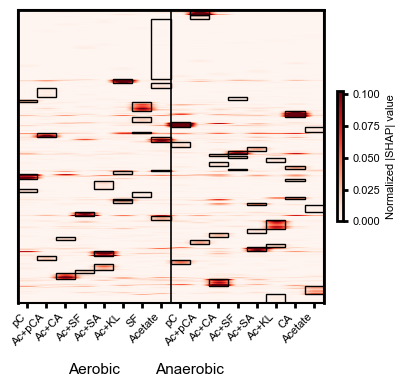

In [21]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle

# ---------- Path & sheet ----------
XLSX_PATH = "results/data/cluster_members_PR_2.xlsx"
# SHEET_TC  = "shap_by_group_selected"
SHEET_TC  = "shap_by_group"

# ---------- Load top_clusters (mapping + SHAPs live here) ----------
tc = pd.read_excel(XLSX_PATH, sheet_name=SHEET_TC)
tc.columns = [c.strip() for c in tc.columns]
tc_lower = [c.lower() for c in tc.columns]

COND_ORDER = [
    # Aerobic
    "pC_ae", "Ac+pCA_ae", "Ac+CA_ae", "Ac+SF_ae",
    "Ac+SA_ae", "Ac+KL_ae", "SF_ae",
    "ANCHOR:Ac_ae",
    # Anaerobic
    "pC_an", "Ac+pCA_an", "Ac+CA_an", "Ac+SF_an",
    "Ac+SA_an", "Ac+KL_an", "CA_an",
    "ANCHOR:Ac_an",
]

COND_META = {
    "pC_ae":     ("pC",    "Aerobic"),
    "Ac+pCA_ae": ("Ac+pCA","Aerobic"),
    "Ac+CA_ae":  ("Ac+CA", "Aerobic"),
    "Ac+SF_ae":  ("Ac+SF", "Aerobic"),
    "Ac+SA_ae":  ("Ac+SA", "Aerobic"),
    "Ac+KL_ae":  ("Ac+KL", "Aerobic"),
    "SF_ae":     ("SF",    "Aerobic"),
    "ANCHOR:Ac_ae": ("Acetate", "Aerobic"),
    "pC_an":     ("pC",    "Anaerobic"),
    "Ac+pCA_an": ("Ac+pCA","Anaerobic"),
    "Ac+CA_an":  ("Ac+CA", "Anaerobic"),
    "Ac+SF_an":  ("Ac+SF", "Anaerobic"),
    "Ac+SA_an":  ("Ac+SA", "Anaerobic"),
    "Ac+KL_an":  ("Ac+KL", "Anaerobic"),
    "CA_an":     ("CA",    "Anaerobic"),
    "ANCHOR:Ac_an": ("Acetate", "Anaerobic"),
}

SHAP_COLS = COND_ORDER


def pick(colnames, options):
    for opt in options:
        if opt in colnames:
            return opt
    return None

col_feature   = pick(tc_lower, ["feature", "rpa", "rpa_id", "protein", "geneid", "gene_id"])
col_family    = pick(tc_lower, ["parent_cluster", "family", "cluster", "parent"])
col_subfamily = pick(tc_lower, ["subcluster", "sub_family", "subfamily", "sub_cluster"])
col_exemplar  = pick(tc_lower, ["local_exemplar", "exemplar", "representative", "rep"])
col_exemplar_fam  = pick(tc_lower, ["parent_exemplar", "exemplar_fam", "representative_fam", "rep_fam"])

# map back to original-cased columns
col_feature   = tc.columns[tc_lower.index(col_feature)]
col_family    = tc.columns[tc_lower.index(col_family)]
col_subfamily = tc.columns[tc_lower.index(col_subfamily)]
col_exemplar  = tc.columns[tc_lower.index(col_exemplar)]

# ---------- SHAP matrix from same sheet ----------
shap_df = tc[[col_feature] + SHAP_COLS].copy()
shap_df["feature_upper"] = shap_df[col_feature].astype(str).str.strip().str.upper()
expr = shap_df.set_index("feature_upper")[SHAP_COLS].astype(float)

# ---------- Build mapping df ----------
map_df = tc[[col_feature, col_family, col_subfamily, col_exemplar, col_exemplar_fam]].rename(columns={
    col_feature: "feature",
    col_family: "family",
    col_subfamily: "subfamily",
    col_exemplar: "exemplar",
    col_exemplar_fam: "exemplar_fam",
}).copy()

map_df["feature_upper"]  = map_df["feature"].astype(str).str.strip().str.upper()
map_df["exemplar_upper"] = map_df["exemplar"].astype(str).str.strip().str.upper()
map_df["exemplar_upper_fam"] = map_df["exemplar_fam"].astype(str).str.strip().str.upper()
map_df["family"]    = pd.to_numeric(map_df["family"], errors="coerce").astype("Int64").astype(int)
map_df["subfamily"] = pd.to_numeric(map_df["subfamily"], errors="coerce").astype("Int64").astype(int)

# ---------- Align & order ----------
common = sorted(set(expr.index).intersection(set(map_df["feature_upper"])))
assert len(common) > 0, "No overlap between mapping features and SHAP features."

family_order_custom = list(dict.fromkeys(map_df["family"]))

aer_idx = [i for i,c in enumerate(SHAP_COLS) if COND_META[c][1] == "Aerobic"]
ana_idx = [i for i,c in enumerate(SHAP_COLS) if COND_META[c][1] == "Anaerobic"]

order_df = (
    map_df[map_df["feature_upper"].isin(common)]
    .drop_duplicates(subset=["feature_upper"])
    .assign(family=pd.Categorical(map_df["family"], categories=family_order_custom, ordered=True))
    .sort_values(["family", "subfamily", "feature_upper"])
    .reset_index(drop=True)
)

# Family exemplar
fam_exemplar = {}
for fam, fgrp in order_df.groupby("family", sort=False, observed=True):
    sizes = fgrp.groupby("subfamily")["feature_upper"].size().sort_values(ascending=False)
    max_size = sizes.iloc[0]
    biggest = sizes[sizes == max_size].index.tolist()
    candidates = []
    for sf in biggest:
        ex = fgrp[fgrp["subfamily"] == sf]["exemplar_upper_fam"].iloc[0]
        candidates.append(ex)
    fam_exemplar[fam] = sorted(set(candidates))[0]

order_df["is_sub_exemplar"] = order_df["feature_upper"].values == order_df["exemplar_upper"].values
order_df["is_fam_exemplar"] = [
    (order_df.loc[i, "feature_upper"] == fam_exemplar[order_df.loc[i, "family"]])
    for i in range(len(order_df))
]

# ---------- Matrix for heatmap ----------
X = expr.reindex(order_df["feature_upper"]).dropna(how="all")
H = X.values.astype(float)
n_rows, n_cols = H.shape

H = X.values.astype(float)

# --- Min-max normalization to 0-1 ---
H_min = np.nanmin(H)
H_max = np.nanmax(H)

# Avoid divide-by-zero in case SHAP is constant
if H_max - H_min > 0:
    H_norm = (H - H_min) / (H_max - H_min)
else:
    H_norm = np.zeros_like(H)
H=H_norm
# ---------- Plot (compressed panel size) ----------
scale = 1.1
fig_w, fig_h = 4.0*scale, 3.8*scale   # << compact panel
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# Reserve space for x-labels and the group labels, plus room on the right for cbar
fig.subplots_adjust(left=0.12, right=0.86, bottom=0.18, top=0.88)


# Symmetric color scale around 0 (better for SHAP)
vmax = np.nanpercentile(np.abs(H), 99)
# vmax = H.max()
im = ax.imshow(H,
            aspect="auto",
            # vmin=-vmax,
            vmax=vmax,
            # cmap="RdBu_r",   # << use diverging red-blue, reversed
            vmin=0,
            # vmax=1,
            cmap="Reds"   
        )

# --- y-axis: no gene IDs, no ticks (just the clustered structure) ---
ax.set_yticks([])          # hide gene ids completely
ax.tick_params(axis='y', length=0)

# --- x-axis: keep condition labels (this is the main story) ---
xticks = np.arange(len(SHAP_COLS))
ax.set_xticks(xticks)
ax.set_xticklabels([COND_META[c][0] for c in SHAP_COLS],
                   rotation=45, ha="right", fontsize=8)

# Group labels axis
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([aer_mid, ana_mid])
ax2.set_xticklabels(["Aerobic", "Anaerobic"], fontsize=10, weight="bold")
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("outward", 40))
ax2.tick_params(length=0)
ax2.spines["bottom"].set_visible(False)

# Separator between groups
sep_pos = aer_end + 0.5
ax.axvline(sep_pos, color="k", linewidth=1.2)

# Expand x-limits for right annotations
# x-limits (allow a bit of room on the right for stars/brackets)
# right_pad = 3.0
right_pad=0.0
ax.set_xlim(-0.5, n_cols - 0.5 + right_pad)


x_f_base  = n_cols + 2.4
arm_len_f = 0.30
# draw_right_f(ax, base_x=x_f_base, arm_len=arm_len_f, lane_dx=0.20, lw=1.0)

# Highlight per-family top-impact conditions (white boxes)
for fam, fgrp in order_df.groupby("family", sort=False, observed=True):
    top_row = int(fgrp.index.min())
    bot_row = int(fgrp.index.max())
    height  = (bot_row - top_row + 1)
    fam_feats = fgrp["feature_upper"].tolist()
    F = expr.loc[fam_feats, SHAP_COLS].values
    col_scores = np.nanmean(np.abs(F), axis=0)
    if not np.isfinite(col_scores).any():
        continue
    mx = np.nanmax(col_scores)
    tol = 1e-12
    best_cols = np.flatnonzero(col_scores >= mx - tol)
    for x in best_cols:
        rect = mpatches.Rectangle(
            (x - 0.5, top_row - 0.5),
            1.0,
            float(height),
            fill=False,
            edgecolor="black",
            linewidth=1.0,
            zorder=6,
        )
        ax.add_patch(rect)

# Colorbar (tight for panel)
cbar = plt.colorbar(
    im,
    ax=ax,
    fraction=0.02,   # thickness
    pad=0.04,        # distance from heatmap
    location="right"
)

# cbar.set_label("SHAP value", rotation=90, fontsize=8)
cbar.set_label("Normalized |SHAP| value", fontsize=8)
cbar.ax.tick_params(labelsize=8)

# Outer frame around axes
for s in ax.spines.values():
    s.set_visible(False)
ax.add_patch(Rectangle((0, 0), 1, 1,
                       transform=ax.transAxes,
                       fill=False, edgecolor="black", linewidth=1.5,
                       zorder=9999, clip_on=False))


HEAT_OUT = OUT_DIR + "/Fig2B_heatmap_shap_from_ALL_clusters_PR_panel.png"
plt.savefig(HEAT_OUT, dpi=300)

plt.show()



## annotate the all cluster heatmap

In [22]:
# ---------- WANTED clusters to annotate ----------
WANTED = [6, 3, 35, 51, 28, 21, 41, 40, 9, 44, 49, 43, 50]


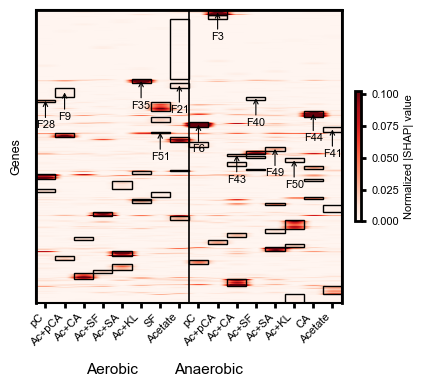

In [27]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle

# ---------- Path & sheet ----------
XLSX_PATH = "results/data/cluster_members_PR_2.xlsx"
# SHEET_TC  = "shap_by_group_selected"
SHEET_TC  = "shap_by_group"

# ---------- Load top_clusters (mapping + SHAPs live here) ----------
tc = pd.read_excel(XLSX_PATH, sheet_name=SHEET_TC)
tc.columns = [c.strip() for c in tc.columns]
tc_lower = [c.lower() for c in tc.columns]

COND_ORDER = [
    # Aerobic
    "pC_ae", "Ac+pCA_ae", "Ac+CA_ae", "Ac+SF_ae",
    "Ac+SA_ae", "Ac+KL_ae", "SF_ae",
    "ANCHOR:Ac_ae",
    # Anaerobic
    "pC_an", "Ac+pCA_an", "Ac+CA_an", "Ac+SF_an",
    "Ac+SA_an", "Ac+KL_an", "CA_an",
    "ANCHOR:Ac_an",
]

COND_META = {
    "pC_ae":     ("pC",    "Aerobic"),
    "Ac+pCA_ae": ("Ac+pCA","Aerobic"),
    "Ac+CA_ae":  ("Ac+CA", "Aerobic"),
    "Ac+SF_ae":  ("Ac+SF", "Aerobic"),
    "Ac+SA_ae":  ("Ac+SA", "Aerobic"),
    "Ac+KL_ae":  ("Ac+KL", "Aerobic"),
    "SF_ae":     ("SF",    "Aerobic"),
    "ANCHOR:Ac_ae": ("Acetate", "Aerobic"),
    "pC_an":     ("pC",    "Anaerobic"),
    "Ac+pCA_an": ("Ac+pCA","Anaerobic"),
    "Ac+CA_an":  ("Ac+CA", "Anaerobic"),
    "Ac+SF_an":  ("Ac+SF", "Anaerobic"),
    "Ac+SA_an":  ("Ac+SA", "Anaerobic"),
    "Ac+KL_an":  ("Ac+KL", "Anaerobic"),
    "CA_an":     ("CA",    "Anaerobic"),
    "ANCHOR:Ac_an": ("Acetate", "Anaerobic"),
}

SHAP_COLS = COND_ORDER



def pick(colnames, options):
    for opt in options:
        if opt in colnames:
            return opt
    return None

col_feature   = pick(tc_lower, ["feature", "rpa", "rpa_id", "protein", "geneid", "gene_id"])
col_family    = pick(tc_lower, ["parent_cluster", "family", "cluster", "parent"])
col_subfamily = pick(tc_lower, ["subcluster", "sub_family", "subfamily", "sub_cluster"])
col_exemplar  = pick(tc_lower, ["local_exemplar", "exemplar", "representative", "rep"])
col_exemplar_fam  = pick(tc_lower, ["parent_exemplar", "exemplar_fam", "representative_fam", "rep_fam"])

# map back to original-cased columns
col_feature   = tc.columns[tc_lower.index(col_feature)]
col_family    = tc.columns[tc_lower.index(col_family)]
col_subfamily = tc.columns[tc_lower.index(col_subfamily)]
col_exemplar  = tc.columns[tc_lower.index(col_exemplar)]

# ---------- SHAP matrix from same sheet ----------
shap_df = tc[[col_feature] + SHAP_COLS].copy()
shap_df["feature_upper"] = shap_df[col_feature].astype(str).str.strip().str.upper()
expr = shap_df.set_index("feature_upper")[SHAP_COLS].astype(float)

# ---------- Build mapping df ----------
map_df = tc[[col_feature, col_family, col_subfamily, col_exemplar, col_exemplar_fam]].rename(columns={
    col_feature: "feature",
    col_family: "family",
    col_subfamily: "subfamily",
    col_exemplar: "exemplar",
    col_exemplar_fam: "exemplar_fam",
}).copy()

map_df["feature_upper"]  = map_df["feature"].astype(str).str.strip().str.upper()
map_df["exemplar_upper"] = map_df["exemplar"].astype(str).str.strip().str.upper()
map_df["exemplar_upper_fam"] = map_df["exemplar_fam"].astype(str).str.strip().str.upper()
map_df["family"]    = pd.to_numeric(map_df["family"], errors="coerce").astype("Int64").astype(int)
map_df["subfamily"] = pd.to_numeric(map_df["subfamily"], errors="coerce").astype("Int64").astype(int)

# ---------- Align & order ----------
common = sorted(set(expr.index).intersection(set(map_df["feature_upper"])))
assert len(common) > 0, "No overlap between mapping features and SHAP features."

family_order_custom = list(dict.fromkeys(map_df["family"]))

aer_idx = [i for i,c in enumerate(SHAP_COLS) if COND_META[c][1] == "Aerobic"]
ana_idx = [i for i,c in enumerate(SHAP_COLS) if COND_META[c][1] == "Anaerobic"]

order_df = (
    map_df[map_df["feature_upper"].isin(common)]
    .drop_duplicates(subset=["feature_upper"])
    .assign(family=pd.Categorical(map_df["family"], categories=family_order_custom, ordered=True))
    .sort_values(["family", "subfamily", "feature_upper"])
    .reset_index(drop=True)
)

# Family exemplar
fam_exemplar = {}
for fam, fgrp in order_df.groupby("family", sort=False, observed=True):
    sizes = fgrp.groupby("subfamily")["feature_upper"].size().sort_values(ascending=False)
    max_size = sizes.iloc[0]
    biggest = sizes[sizes == max_size].index.tolist()
    candidates = []
    for sf in biggest:
        ex = fgrp[fgrp["subfamily"] == sf]["exemplar_upper_fam"].iloc[0]
        candidates.append(ex)
    fam_exemplar[fam] = sorted(set(candidates))[0]

order_df["is_sub_exemplar"] = order_df["feature_upper"].values == order_df["exemplar_upper"].values
order_df["is_fam_exemplar"] = [
    (order_df.loc[i, "feature_upper"] == fam_exemplar[order_df.loc[i, "family"]])
    for i in range(len(order_df))
]

# ---------- Matrix for heatmap ----------
X = expr.reindex(order_df["feature_upper"]).dropna(how="all")
H = X.values.astype(float)
n_rows, n_cols = H.shape

# --- Min-max normalization to 0-1 ---
H_min = np.nanmin(H)
H_max = np.nanmax(H)

# Avoid divide-by-zero in case SHAP is constant
if H_max - H_min > 0:
    H_norm = (H - H_min) / (H_max - H_min)
else:
    H_norm = np.zeros_like(H)
H = H_norm

# ---------- Plot (compressed panel size) ----------
scale = 1.1
fig_w, fig_h = 4.0*scale, 3.8*scale   # << compact panel
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# Reserve space for x-labels and the group labels, plus room on the right for cbar
fig.subplots_adjust(left=0.12, right=0.86, bottom=0.18, top=0.88)

# Color scale
vmax = np.nanpercentile(np.abs(H), 99)

im = ax.imshow(
    H,
    aspect="auto",
    vmin=0,
    vmax=vmax,
    cmap="Reds"
)

# --- y-axis: no gene IDs, no ticks (just the clustered structure) ---
ax.set_yticks([])
ax.tick_params(axis='y', length=0)

# --- x-axis: keep condition labels (this is the main story) ---
xticks = np.arange(len(SHAP_COLS))
ax.set_xticks(xticks)
ax.set_xticklabels(
    [COND_META[c][0] for c in SHAP_COLS],
    rotation=45,
    ha="right",
    fontsize=8
)
ax.set_ylabel("Genes", fontsize=9, labelpad=10)

# Group labels axis (assumes aer_mid, ana_mid, aer_end defined above)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([aer_mid, ana_mid])
ax2.set_xticklabels(["Aerobic", "Anaerobic"], fontsize=10, weight="bold")
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("outward", 40))
ax2.tick_params(length=0)
ax2.spines["bottom"].set_visible(False)

# Separator between groups
sep_pos = aer_end + 0.5
ax.axvline(sep_pos, color="k", linewidth=1.2)

# Keep everything tight on x (no extra right pad; overlay stays inside)
right_pad = 0.0
ax.set_xlim(-0.5, n_cols - 0.5 + right_pad)

# ---------- Highlight per-family top-impact conditions + annotate WANTED ----------
for fam, fgrp in order_df.groupby("family", sort=False, observed=True):
    top_row = int(fgrp.index.min())
    bot_row = int(fgrp.index.max())
    height  = (bot_row - top_row + 1)

    fam_feats = fgrp["feature_upper"].tolist()
    F = expr.loc[fam_feats, SHAP_COLS].values
    col_scores = np.nanmean(np.abs(F), axis=0)
    if not np.isfinite(col_scores).any():
        continue

    mx  = np.nanmax(col_scores)
    tol = 1e-12
    best_cols = np.flatnonzero(col_scores >= mx - tol)

    # Draw the white rectangles over top-impact columns for this family
    for x in best_cols:
        rect = mpatches.Rectangle(
            (x - 0.5, top_row - 0.5),
            1.0,
            float(height),
            fill=False,
            edgecolor="black",
            linewidth=1.0,
            zorder=6,
        )
        ax.add_patch(rect)

    # Annotate ONLY WANTED clusters with arrows/text overlay
    fam_int = int(fam)
    if fam_int in WANTED and best_cols.size > 0:
        # Center of the highlighted block (in data coords)
        x_center = float(best_cols.min() + best_cols.max()) / 2.0
        y_center = float(top_row + bot_row) / 2.0

        label = f"F{fam_int}"   # short label; tweak if you want full names

        ax.annotate(
            label,
            xy=(x_center, y_center),    # arrow tip at center of patch
            xytext=(0, -14),            # 14 pts above, stays inside axes
            textcoords="offset points",
            ha="center",
            va="top",
            fontsize=8,
            color="black",
            arrowprops=dict(
                arrowstyle="->",
                lw=0.8,
                color="black",
                shrinkA=0,
                shrinkB=0,
            ),
            zorder=10,
        )

# Colorbar (tight for panel)
cbar = plt.colorbar(
    im,
    ax=ax,
    fraction=0.02,   # thickness
    pad=0.04,        # distance from heatmap
    location="right"
)
cbar.set_label("Normalized |SHAP| value", fontsize=8)
cbar.ax.tick_params(labelsize=8)

# Outer frame around axes
for s in ax.spines.values():
    s.set_visible(False)
ax.add_patch(
    Rectangle(
        (0, 0), 1, 1,
        transform=ax.transAxes,
        fill=False,
        edgecolor="black",
        linewidth=1.5,
        zorder=9999,
        clip_on=False
    )
)

HEAT_OUT = OUT_DIR + "/Fig2B_heatmap_shap_from_ALL_clusters_PR_panel.png"
plt.savefig(HEAT_OUT, dpi=300)
plt.show()


## Examine conditions each cluster impacts significantly by mean |SHAP|

In [ ]:
# ---------- SUMMARY ONLY: per-family max-impact condition_key(s), no heatmaps ----------
rows = []
present_families = [f for f in family_order_custom if f in order_df_all["family"].unique()]

for fam in present_families:
    # members in this family, aligned to expr
    fgrp = (order_df_all[order_df_all["family"] == fam]
            .drop_duplicates(subset=["feature_upper"]))
    fam_feats = [f for f in fgrp["feature_upper"].tolist() if f in expr.index]

    if len(fam_feats) == 0:
        continue

    F = expr.loc[fam_feats, SHAP_COLS].values  # (#features_in_fam x #conditions)
    # score per condition = mean absolute SHAP across family members
    col_scores = np.nanmean(np.abs(F), axis=0)
    if not np.isfinite(col_scores).any():
        continue

    mx = np.nanmax(col_scores)
    # allow ties within tiny tolerance
    best_cols = np.flatnonzero(col_scores >= mx - 1e-12)

    for idx in best_cols:
        cond_key = SHAP_COLS[idx]
        cond_name, oxy = COND_META[cond_key]
        rows.append({
            "family": int(fam),
            "condition_key": cond_key,      # requested key
            "condition": cond_name,         # human-readable (optional)
            "oxygen": oxy,                  # Aerobic/Anaerobic (optional)
            "max_mean_abs_shap": float(col_scores[idx])
        })

impact_df = (pd.DataFrame(rows)
             .sort_values(["family", "max_mean_abs_shap"], ascending=[True, False])
             .reset_index(drop=True))

# (Optional) 1-row per family with comma-joined keys if ties:
impact_wide = (impact_df.groupby("family", as_index=False)
               .agg(best_condition_keys=("condition_key", lambda s: ",".join(s)),
                    oxygen=("oxygen", lambda s: ",".join(pd.unique(s))),
                    max_mean_abs_shap=("max_mean_abs_shap", "max")))

# Save
out_csv = os.path.join(tmp_OUT_DIR, "family_max_condition_keys.csv")
impact_df.to_csv(out_csv, index=False)
print(f"Wrote: {out_csv}")
impact_df


In [ ]:
tmp_df = outs["cluster_selection"].merge(impact_df, left_on="cluster", right_on="family", how="left", sort=False,validate="1:1" )
tmp_df["Confidence_level"] = (tmp_df.apply(lambda row: 0 if row.get("pass_both") is True else 1 if (not row.get("pass_both", False)) and (row.get("delta_RMSE_mean", 0) > 0) else 2, axis=1))
tmp_df = tmp_df.sort_values(by=["delta_RMSE_mean", "pass_both"], ascending=[False, False], ignore_index=True)
# tmp_df 
# --- write to a new sheet in existing workbook ---
with pd.ExcelWriter("results/data/cluster_members_PR_2.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    tmp_df.to_excel(writer, sheet_name="cluster_selection_table_pr", index=False)


##  ConditionModule assignment map

/tmp/ipykernel_1461972/2180925943.py:253: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  leg = ax.legend(handles, labels,


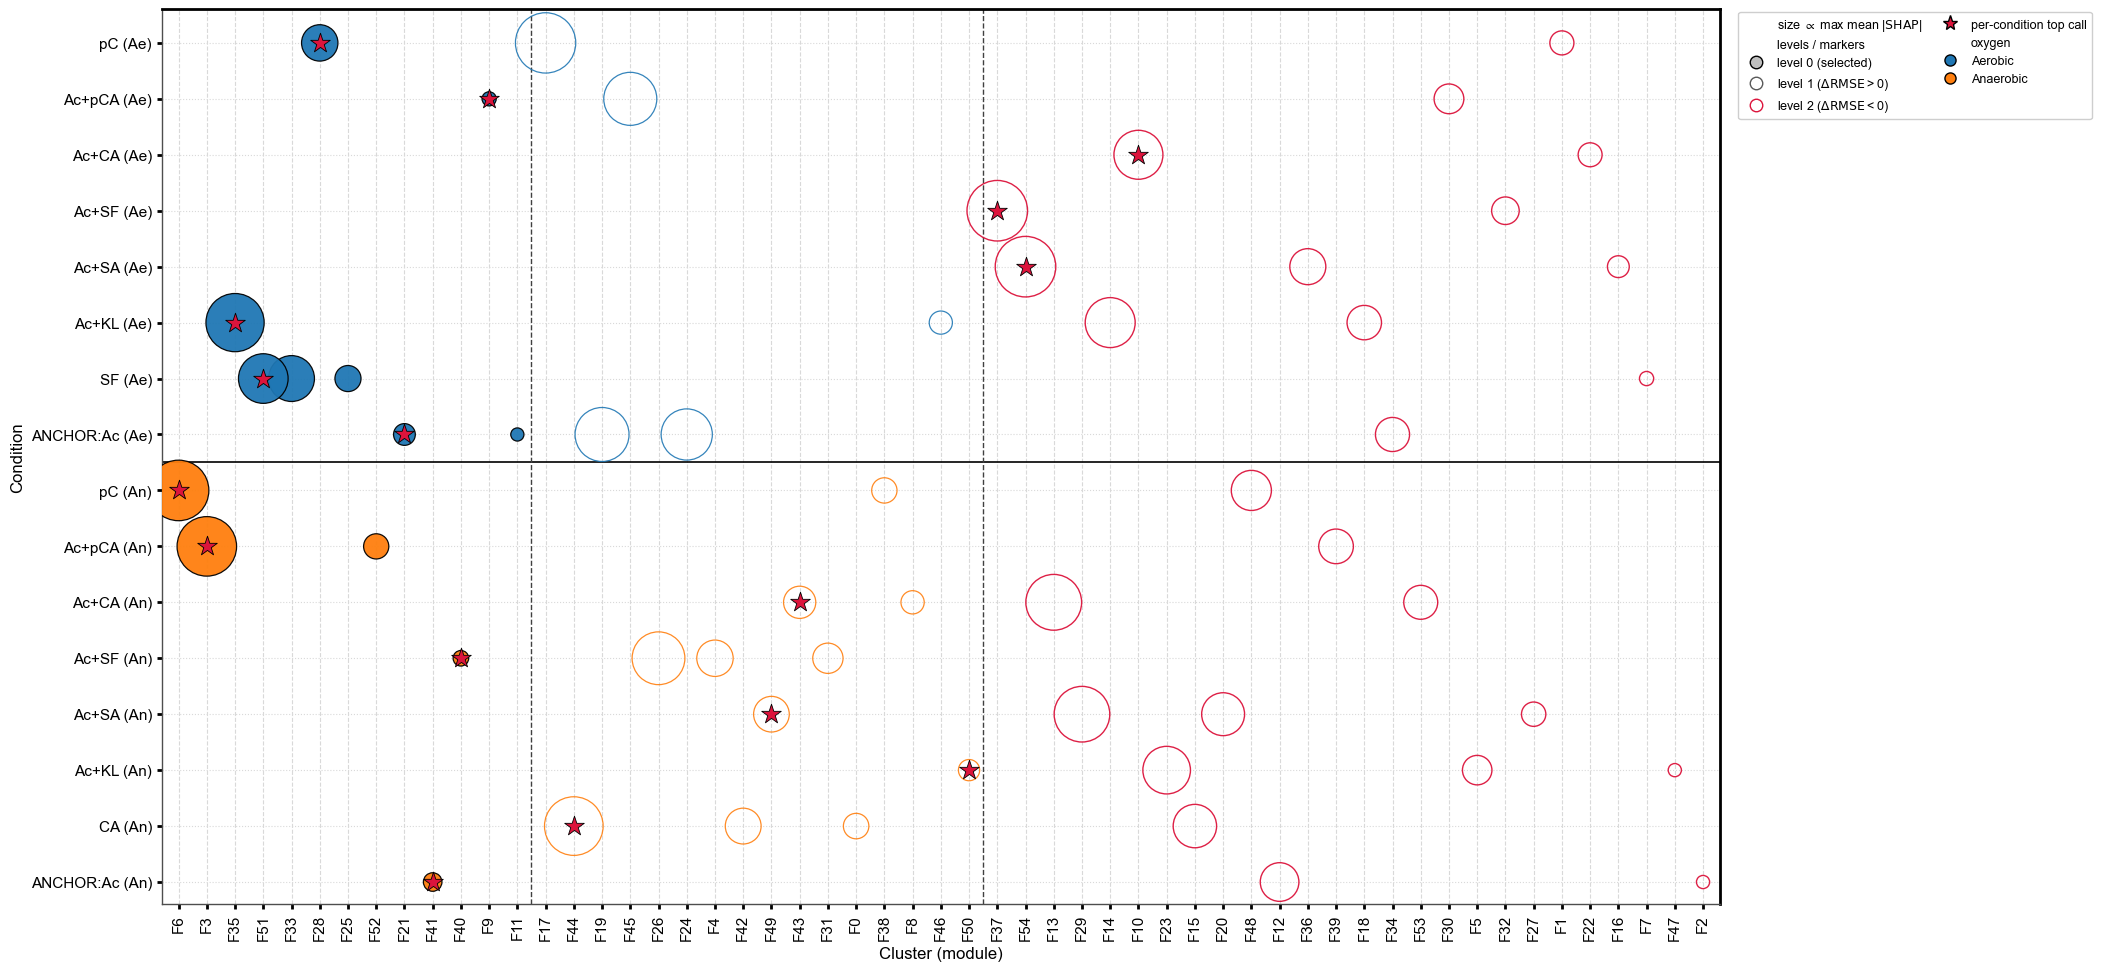

Saved: /mnt/nrdstor/ssbio/aosinuga2/Other_folks/r_palustris_LBP_ML-main/Working/OmniProt/Clean_cpu_run/figures/condition_assignment_bubblemap_clustersX_conditionsY_withStars.png
Selected clusters (top-per-condition with RMSE > 0): [6, 3, 35, 51, 28, 21, 41, 40, 9, 44, 49, 43, 50]


In [19]:
# Bubble map of primary condition assignment (clusters on X, conditions on Y)
# - Uses `Confidence_level`: 0=the 13 selected, 1=RMSE>0 (not selected), 2=RMSE<0
# - Bubble area encodes max mean |SHAP| (robust sqrt scaling).
# - All circles:
#     " Level 0 = filled circles (colored by oxygen)
#     " Level 1 = hollow circles (edge colored by oxygen)
#     " Level 2 = hollow circles (crimson edge)
# - A red star marks the top call per condition:
#     priority by Confidence_level (012), tie-breaker by largest max_mean_abs_shap.
# - Aerobic vs Anaerobic split with a horizontal divider; vertical grid lines added.
# - High-quality export (PNG, 600 dpi).
#
# Expected columns in sheet "cluster_selection_table_pr":
# ['cluster','condition_key','condition','oxygen','max_mean_abs_shap','Confidence_level', ...]
#
# If 'oxygen' is missing, it will be derived from condition_key suffix (_ae/_an).

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Font & global style
# -----------------------------
arial_path = "data/arial.ttf"
arial_font = fm.FontProperties(fname=arial_path)

# Register and use Arial everywhere
fm.fontManager.addfont(arial_path)
rcParams['font.family'] = arial_font.get_name()

mpl.rcParams.update({
    'font.family': 'Arial',
    'mathtext.default': 'regular',   # clean mathtext look
    'axes.linewidth': 2.0,
    'lines.linewidth': 2.0,
    'xtick.major.width': 2.0,
    'ytick.major.width': 2.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
})

# -------------------- Hi-quality, math-friendly styling --------------------
# mpl.rcParams.update({
#     "mathtext.fontset": "stix",
#     "font.family": "STIXGeneral",
#     "figure.dpi": 180,          # on-screen
#     "savefig.dpi": 600,         # file export
#     "axes.spines.top": False,
#     "axes.spines.right": False,
#     "axes.titlesize": 14,
#     "axes.labelsize": 12,
#     "xtick.labelsize": 10,
#     "ytick.labelsize": 10,
# })

# -------------------- Load data --------------------
xlsx_path = Path("results/data/cluster_members_PR_2.xlsx")
sheet = "cluster_selection_table_pr"
df = pd.read_excel(xlsx_path, sheet_name=sheet)

needed = {"cluster","condition_key","max_mean_abs_shap","Confidence_level"}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {sorted(missing)}")

# Derive oxygen if missing
if "oxygen" not in df.columns or df["oxygen"].isna().all():
    df["oxygen"] = df["condition_key"].astype(str).apply(
        lambda s: "Aerobic" if s.endswith("_ae") else ("Anaerobic" if s.endswith("_an") else "")
    )

# Clean and type
df = df.dropna(subset=["cluster","condition_key","max_mean_abs_shap","Confidence_level"]).copy()
df["cluster"] = pd.to_numeric(df["cluster"], errors="coerce").astype(int)
df["Confidence_level"] = pd.to_numeric(df["Confidence_level"], errors="coerce").astype(int)

# -------------------- Axis ordering --------------------
# Y = conditions (Aerobic  Anaerobic)
# aero = ["pC_ae","Ac+pCA_ae","Ac+CA_ae","Ac+SF_ae","Ac+SA_ae","Ac+KL_ae","SF_ae"]
# ana  = ["pC_an","Ac+pCA_an","Ac+CA_an","Ac+SF_an","Ac+SA_an","Ac+KL_an","CA_an"]
aero = ["pC_ae","Ac+pCA_ae","Ac+CA_ae","Ac+SF_ae","Ac+SA_ae","Ac+KL_ae","SF_ae", "ANCHOR:Ac_ae"]
ana  = ["pC_an","Ac+pCA_an","Ac+CA_an","Ac+SF_an","Ac+SA_an","Ac+KL_an","CA_an", "ANCHOR:Ac_an"]
y_order = aero + ana
cond_to_y = {c:i for i, c in enumerate(y_order)}
df = df[df["condition_key"].isin(y_order)].copy()
df["ypos"] = df["condition_key"].map(cond_to_y)

# X = clusters ordered by Confidence_level (0  1  2),
#     within each level by descending max_mean_abs_shap
order_by = (df
            .sort_values(["Confidence_level","max_mean_abs_shap"], ascending=[True, False])
            ["cluster"].drop_duplicates().tolist())
x_order = order_by
clust_to_x = {c:i for i, c in enumerate(x_order)}
df["xpos"] = df["cluster"].map(clust_to_x)

# -------------------- Bubble size scaling (robust) --------------------
def bubble_sizes(values, smin=90, smax=1900, q=(5, 95)):
    v = np.asarray(values, float)
    v = np.clip(v, 0.0, None)
    if not np.isfinite(v).any():
        return np.full_like(v, 0.5*(smin+smax), dtype=float)
    lo, hi = np.nanpercentile(v, q)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = np.nanmin(v), np.nanmax(v)
    if hi <= lo:
        return np.full_like(v, 0.5*(smin+smax), dtype=float)
    v_clip = np.clip(v, lo, hi)
    v_s = np.sqrt(v_clip)  # area perception ~ sqrt(value)
    v_s = (v_s - v_s.min()) / (v_s.max() - v_s.min() + 1e-12)
    return smin + v_s * (smax - smin)

sizes = bubble_sizes(df["max_mean_abs_shap"].values, smin=90, smax=1900, q=(5,95))
oxy_color = df["oxygen"].map({"Aerobic":"tab:blue", "Anaerobic":"tab:orange"}).fillna("gray")

# Masks by level
m0 = df["Confidence_level"] == 0   # selected (the 13)
m1 = df["Confidence_level"] == 1   # positive RMSE, not selected
m2 = df["Confidence_level"] == 2   # negative RMSE

# -------------------- Pick top call per condition --------------------
# For each condition_key: pick row with min Confidence_level, then max max_mean_abs_shap
top_idx = []
for cond, sub in df.groupby("condition_key", sort=False):
    sub2 = sub.sort_values(["Confidence_level","max_mean_abs_shap"], ascending=[True, False])
    top_idx.append(sub2.index[0])
top_idx = set(top_idx)

# -------------------- Plot --------------------
fig_w = max(12, 0.38*len(x_order))
fig_h = max(7.0, 0.60*len(y_order))
fig, ax = plt.subplots(figsize=(fig_w, fig_h), constrained_layout=True)
fig.set_facecolor("white")

# Level 0: filled circles, oxygen color
h0 = ax.scatter(df.loc[m0, "xpos"], df.loc[m0, "ypos"],
                s=sizes[m0], c=oxy_color[m0], edgecolors="k",
                linewidths=0.9, alpha=0.95, zorder=3, label="level 0 (selected)")

# Level 1: hollow circles, edge colored by oxygen
h1 = ax.scatter(df.loc[m1, "xpos"], df.loc[m1, "ypos"],
                s=sizes[m1], facecolors="none", edgecolors=oxy_color[m1],
                linewidths=0.9, alpha=0.9, zorder=2, label=r"level 1 ($\Delta\mathrm{RMSE}>0$)")

# Level 2: hollow circles, crimson edge (no X marker)
h2 = ax.scatter(df.loc[m2, "xpos"], df.loc[m2, "ypos"],
                s=sizes[m2], facecolors="none", edgecolors="crimson",
                linewidths=1.0, alpha=0.95, zorder=3, label=r"level 2 ($\Delta\mathrm{RMSE}<0$)")

# Stars on top calls
star_x = df.loc[list(top_idx), "xpos"].values
star_y = df.loc[list(top_idx), "ypos"].values
hstar = ax.scatter(star_x, star_y, marker="*", s=220, c="crimson",
                   edgecolors="k", linewidths=0.6, zorder=5, label="per-condition top call")

# Horizontal divider between Aerobic and Anaerobic blocks
ax.axhline(len(aero) - 0.5, color="k", lw=1.2, zorder=1)

# Optional vertical dividers between levels on x-axis
n0 = len(df.loc[m0, "cluster"].drop_duplicates())
n1 = len(df.loc[m1, "cluster"].drop_duplicates())
if n0 > 0:
    ax.axvline(n0 - 0.5, color="0.25", lw=1.0, ls="--", zorder=1)
if n1 > 0:
    ax.axvline(n0 + n1 - 0.5, color="0.25", lw=1.0, ls="--", zorder=1)

# Ticks/labels
ax.set_xticks(range(len(x_order)))
ax.set_xticklabels([f"F{c}" for c in x_order], rotation=90, ha="center")
ax.set_yticks(range(len(y_order)))
ax.set_yticklabels([c.replace("_ae"," (Ae)").replace("_an"," (An)") for c in y_order])

ax.set_xlabel("Cluster (module)")
ax.set_ylabel("Condition")

# ax.set_title(
#     r"Primary condition by max mean $|\mathrm{SHAP}|$ (bubble size)"
#     "\n"
#     r"Level 0 = selected; Level 1 = positive $\Delta\mathrm{RMSE}$; Level 2 = negative $\Delta\mathrm{RMSE}$"
# )

# Grid: vertical + horizontal
ax.set_axisbelow(True)
ax.grid(axis="x", which="major", linestyle="--", color="0.85", linewidth=0.8)
ax.grid(axis="y", which="major", linestyle=":",  color="0.85", linewidth=0.8)

# Limits + cosmetics
ax.set_xlim(-0.6, len(x_order)-0.4)
ax.set_ylim(len(y_order)-0.6, -0.6)  # Aerobic on top
for spine in ("left", "bottom"):
    ax.spines[spine].set_color("0.3")
    ax.spines[spine].set_linewidth(1.0)

# Legends: size legend + level legend + star legend
# ---------- ONE CONSOLIDATED LEGEND (size + levels/markers + oxygen) ----------
from matplotlib.lines import Line2D

# --- Bubble-size scale (use quartiles as examples) ---
q_list = (25, 50, 90)
size_handles, size_labels = [], []
for q in q_list:
    vq = np.nanpercentile(df["max_mean_abs_shap"].values, q)
    sq = bubble_sizes([vq], smin=90, smax=1900, q=(5, 95))[0]
    size_handles.append(plt.scatter([], [], s=sq, facecolor="lightgray", edgecolor="k"))
    size_labels.append(fr"{q}th: {vq:.2e}")

# Section headers (text-only rows)
hdr_size  = Line2D([0], [0], color="none", label=r"size $\propto$ max mean $|\mathrm{SHAP}|$")
hdr_lvl   = Line2D([0], [0], color="none", label="levels / markers")
hdr_oxy   = Line2D([0], [0], color="none", label="oxygen")

# --- Level / marker semantics ---
handles_lvl = [
    Line2D([0],[0], marker="o", linestyle="none",
           markerfacecolor="0.75", markeredgecolor="k", markersize=9,
           label="level 0 (selected)"),
    Line2D([0],[0], marker="o", linestyle="none",
           markerfacecolor="none", markeredgecolor="0.35", markersize=9,
           label=r"level 1 ($\Delta\mathrm{RMSE}>0$)"),
    Line2D([0],[0], marker="o", linestyle="none",
           markerfacecolor="none", markeredgecolor="crimson", markersize=9,
           label=r"level 2 ($\Delta\mathrm{RMSE}<0$)"),
    Line2D([0],[0], marker="*", linestyle="none",
           markerfacecolor="crimson", markeredgecolor="k", markersize=11,
           label="per-condition top call"),
]

# --- Oxygen colors ---
handles_oxy = [
    Line2D([0],[0], marker="o", linestyle="none",
           markerfacecolor="tab:blue", markeredgecolor="k", markersize=8,
           label="Aerobic"),
    Line2D([0],[0], marker="o", linestyle="none",
           markerfacecolor="tab:orange", markeredgecolor="k", markersize=8,
           label="Anaerobic"),
]

# Assemble one legend
handles = (
    [hdr_size] + size_handles +
    [hdr_lvl]  + handles_lvl   +
    [hdr_oxy]  + handles_oxy
)
labels  = [h.get_label() for h in handles]

leg = ax.legend(handles, labels,
                loc="upper left", bbox_to_anchor=(1.01, 1.0),
                ncol=2, frameon=True, fontsize=9,
                columnspacing=1.2, handletextpad=0.7, borderaxespad=0.2)

# Make section headers bold
for t in leg.get_texts():
    if t.get_text() in {hdr_size.get_label(), hdr_lvl.get_label(), hdr_oxy.get_label()}:
        t.set_fontweight("bold")

# Slight transparency so it floats cleanly
leg.get_frame().set_alpha(0.95)



# -------------------- Save high-quality outputs --------------------
out_dir = Path(OUT_DIR)
out_dir.mkdir(parents=True, exist_ok=True)
png_path = out_dir / "condition_assignment_bubblemap_clustersX_conditionsY_withStars.png"

plt.savefig(png_path, dpi=600, bbox_inches="tight", facecolor="white", pad_inches=0.05)
plt.show()

print(f"Saved: {png_path.resolve()}")

# # WANTED = list(df.loc[list(top_idx)].sort_values("xpos")["cluster"].values)
# WANTED = list(df.loc[list(top_idx)].query("pass_both == True").sort_values("xpos")["cluster"].values)
# print(f"The selected clusters are: {WANTED}")

# Start from df with all modules
df = df.copy()

# --- Step 1: pick the top-ranked module per condition (Confidence_level  SHAP)
top_rows = []
for cond, sub in df.groupby("condition_key", sort=False):
    sub_sorted = sub.sort_values(
        ["Confidence_level", "max_mean_abs_shap"],
        ascending=[True, False]
    )
    top_rows.append(sub_sorted.iloc[0])

df_top = pd.DataFrame(top_rows)

# --- Step 2: Keep ONLY modules with RMSE > 0
df_top = df_top[df_top["delta_RMSE_mean"] > 0].copy()

# --- Step 3: Sort by xpos (already computed earlier in your script)
df_top = df_top.sort_values("xpos")

# --- Step 4: The final list of selected clusters
WANTED = list(df_top["cluster"].astype(int).values)

print("Selected clusters (top-per-condition with RMSE > 0):", WANTED)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D

# ----------------- Load table -----------------
xlsx_path = Path("results/data/cluster_members_PR_2.xlsx")
sheet = "cluster_selection_table_pr"
df = pd.read_excel(xlsx_path, sheet_name=sheet)

# Clean numeric columns
for col in ["cluster", "delta_RMSE_mean", "SE_mean"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["cluster", "delta_RMSE_mean"]).copy()
df["cluster"] = df["cluster"].astype(int)

# ---------- NEW: compute "top cluster per condition" ----------
# We need the per-condition table *before* dropping duplicates by cluster
if not {"condition_key", "max_mean_abs_shap", "Confidence_level"}.issubset(df.columns):
    raise ValueError("Need columns: condition_key, max_mean_abs_shap, Confidence_level")
# --- Compute top-ranked cluster per condition ---
# Priority 1: lowest Confidence_level (0 -> 1 -> 2)
# Priority 2: highest max_mean_abs_shap
top_rows = []
for cond, sub in df.groupby("condition_key", sort=False):
    sub_sorted = sub.sort_values(
        ["Confidence_level", "max_mean_abs_shap"],
        ascending=[True, False]
    )
    top_rows.append(sub_sorted.iloc[0])

df_top = pd.DataFrame(top_rows).reset_index(drop=True)
# selected_clusters = sorted(df_top["cluster"].unique())
# print("Selected clusters (top per condition):", selected_clusters)
# First: top cluster per condition
selected_clusters = sorted(df_top["cluster"].unique())

# Second: enforce RMSE e 0 criterion
valid_clusters = df[df["delta_RMSE_mean"] >= 0]["cluster"].unique()
selected_clusters = sorted(set(selected_clusters).intersection(valid_clusters))

print("Selected clusters (top per condition, RMSE>=0):", selected_clusters)

# ---------------------------------------------------------------

# One row per cluster (for plotting RMSE); if your table already has this, this is harmless
df = df.sort_values("delta_RMSE_mean", ascending=False)
df = df.drop_duplicates(subset=["cluster"], keep="first")

# Scale RMSE to something readable, e.g. ×1e3
scale = 1e3
df["delta_scaled"] = df["delta_RMSE_mean"] * scale
df["SE_scaled"] = df["SE_mean"] * scale

# Order for plotting (largest RMSE on top in the barh)
df_plot = df.sort_values("delta_scaled", ascending=True)  # ascending for barh bottomtop
y_pos = np.arange(len(df_plot))

# ---------- UPDATED: color by top-per-condition membership ----------
df_plot["is_selected"] = df_plot["cluster"].isin(selected_clusters)
colors = np.where(df_plot["is_selected"], "tab:red", "lightgray")
# ---------------------------------------------------------------

# ----------------- Plot -----------------
# fig, ax = plt.subplots(figsize=(8, max(5, 0.22 * len(df_plot))))
fig, ax = plt.subplots(figsize=(4.94, 10.16))


ax.barh(
    y_pos,
    df_plot["delta_scaled"],
    color=colors,
    edgecolor="k",
    linewidth=0.6,
)

# Error bars (± SE)
ax.errorbar(
    df_plot["delta_scaled"],
    y_pos,
    xerr=df_plot["SE_scaled"],
    fmt="none",
    ecolor="k",
    elinewidth=0.7,
    capsize=2,
    zorder=3,
)

# ---------- NEW: significance mask (q_bh AND delta>0) ----------
if "q_bh" in df_plot.columns:
    sig_mask = (df_plot["q_bh"] < 0.05) & (df_plot["delta_RMSE_mean"] > 0)
elif "pass_fdr" in df_plot.columns:
    sig_mask = df_plot["pass_fdr"].astype(bool) & (df_plot["delta_RMSE_mean"] > 0)
else:
    sig_mask = np.full(len(df_plot), False)

df_plot["is_sig"] = sig_mask

# ---------- STAR POSITION: at bar-tip + 5% offset ----------
x_star = df_plot["delta_scaled"] + df_plot["SE_scaled"] + 0.05 * df_plot["delta_scaled"].abs()
y_star = np.arange(len(df_plot))

# Plot stars only where significant
ax.scatter(
    x_star[df_plot["is_sig"]],
    y_star[df_plot["is_sig"]],
    marker="*",
    s=70,
    c="k",
    zorder=5,
)
# Vertical reference at 0
ax.axvline(0.0, color="k", linewidth=1.0)

# Labels
ax.set_yticks(y_pos)
ax.set_yticklabels([f"F{int(c)}" for c in df_plot["cluster"]])
ax.set_xlabel(r"Mean $\Delta$RMSE per module  ($\times 10^{-3}$)")
ax.set_ylabel("Module (cluster)")

_journal_axes(ax)
# ---------- UPDATED legend text ----------
handles = [
    Line2D([0], [0], color="tab:red", lw=6,
           label="Top cluster per condition"),
    Line2D([0], [0], color="lightgray", lw=6,
           label="Other modules"),
    Line2D([0], [0], marker="*", linestyle="none",
           markerfacecolor="k", markeredgecolor="k", markersize=9,
           label=r"FDR-significant ($q_{\mathrm{BH}}<0.05$)"),

]
ax.legend(handles=handles, loc="center right", frameon=False)

fig.tight_layout()

OUT_DIR = Path("figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_path = OUT_DIR / "Fig2C_deltaRMSE_ranked_modules.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight", facecolor="white")
plt.show()

print(f"Saved Fig 2C to: {out_path.resolve()}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# ===========================
# Settings / paths
# ===========================
xlsx_path = Path("results/data/cluster_members_PR_2.xlsx")
sheet = "cluster_selection_table_pr"
OUT_DIR = Path("figures/Panels")
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_path = OUT_DIR / "Fig2D_topModules_perCondition_bubble.png"

# ===========================
# Load table
# ===========================
df = pd.read_excel(xlsx_path, sheet_name=sheet)

# ===========================
# Sanitize / rename conditions
# ===========================
# 1) Clean condition_key
df["condition_key"] = df["condition_key"].astype(str)
df["condition_key"] = (
    df["condition_key"]
    .str.replace("ANCHOR:Ac_ae", "Acetate_ae")
    .str.replace("ANCHOR:Ac_an", "Acetate_an")
)

# 2) Clean human-readable "condition" label if present
if "condition" in df.columns:
    df["condition"] = df["condition"].astype(str)
    df["condition"] = (
        df["condition"]
        .str.replace("ANCHOR:Ac", "Acetate")
        .str.replace("ANCHOR:Ac_ae", "Acetate")
        .str.replace("ANCHOR:Ac_an", "Acetate")
    )

# ===========================
# Ensure required columns
# ===========================
needed = {
    "cluster",
    "condition_key",
    "max_mean_abs_shap",
    "Confidence_level",
    "delta_RMSE_mean",
}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {sorted(missing)}")

# Numeric conversion
for col in ["cluster", "max_mean_abs_shap", "Confidence_level", "delta_RMSE_mean"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["cluster", "condition_key", "max_mean_abs_shap"]).copy()
df["cluster"] = df["cluster"].astype(int)

# ===========================
# Derive oxygen if missing
# ===========================
if "oxygen" not in df.columns or df["oxygen"].isna().all():
    df["oxygen"] = df["condition_key"].apply(
        lambda s: "Aerobic"
        if str(s).endswith("_ae")
        else ("Anaerobic" if str(s).endswith("_an") else "")
    )

# ===========================
# Top-per-condition with RMSE e 0
# ===========================
top_rows = []
for cond, sub in df.groupby("condition_key", sort=False):
    # Rank: lower Confidence_level first, then higher max_mean_abs_shap
    sub_sorted = sub.sort_values(
        ["Confidence_level", "max_mean_abs_shap"],
        ascending=[True, False],
    )
    top_rows.append(sub_sorted.iloc[0])

df_top = pd.DataFrame(top_rows).reset_index(drop=True)

# Enforce RMSE_mean e 0
df_top = df_top[df_top["delta_RMSE_mean"] >= 0].copy()

print("Top per condition with RMSE_mean e 0:")
print(df_top[["condition_key", "cluster", "delta_RMSE_mean"]])

# ===========================
# Condition ordering (match Fig. 2A)
# ===========================
aero = [
    "pC_ae",
    "Ac+pCA_ae",
    "Ac+CA_ae",
    "Ac+SF_ae",
    "Ac+SA_ae",
    "Ac+KL_ae",
    "SF_ae",
    "Acetate_ae",
]
ana = [
    "pC_an",
    "Ac+pCA_an",
    "Ac+CA_an",
    "Ac+SF_an",
    "Ac+SA_an",
    "Ac+KL_an",
    "CA_an",
    "Acetate_an",
]
y_order = aero + ana

df_pred = df_top[df_top["condition_key"].isin(y_order)].copy()

# ===========================
# Axes positions
# ===========================
# X = selected cluster IDs, sorted
x_order = sorted(df_pred["cluster"].unique())
clust_to_x = {c: i for i, c in enumerate(x_order)}
df_pred["xpos"] = df_pred["cluster"].map(clust_to_x)

# Y = conditions in fixed order
cond_to_y = {c: i for i, c in enumerate(y_order)}
df_pred["ypos"] = df_pred["condition_key"].map(cond_to_y)

# ===========================
# Bubble size scaling
# ===========================
def bubble_sizes(values, smin=80, smax=1400, q=(5, 95)):
    v = np.asarray(values, float)
    v = np.clip(v, 0.0, None)
    if not np.isfinite(v).any():
        return np.full_like(v, 0.5 * (smin + smax), dtype=float)
    lo, hi = np.nanpercentile(v, q)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = np.nanmin(v), np.nanmax(v)
    if hi <= lo:
        return np.full_like(v, 0.5 * (smin + smax), dtype=float)
    v_clip = np.clip(v, lo, hi)
    v_s = np.sqrt(v_clip)  # perceptual: area ~ sqrt(value)
    v_s = (v_s - v_s.min()) / (v_s.max() - v_s.min() + 1e-12)
    return smin + v_s * (smax - smin)

sizes = bubble_sizes(df_pred["max_mean_abs_shap"].values, smin=80, smax=1400)
colors = df_pred["oxygen"].map(
    {"Aerobic": "tab:blue", "Anaerobic": "tab:orange"}
).fillna("gray")

# ===========================
# Plot
# ===========================
fig_w = max(6.5, 0.6 * len(x_order))
fig_h = 4.8
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
fig.set_facecolor("white")

ax.scatter(
    df_pred["xpos"],
    df_pred["ypos"],
    s=sizes,
    c=colors,
    edgecolors="k",
    linewidths=0.7,
    alpha=0.95,
)

# Horizontal divider between Aerobic and Anaerobic
ax.axhline(len(aero) - 0.5, color="k", lw=1.0)

# Ticks & labels
ax.set_xticks(range(len(x_order)))
ax.set_xticklabels([f"F{c}" for c in x_order], rotation=45, ha="right")

ax.set_yticks(range(len(y_order)))
ax.set_yticklabels(
    [c.replace("_ae", " (Ae)").replace("_an", " (An)") for c in y_order]
)

# ax.set_xlabel("Top module per condition (RMSE e 0)")
ax.set_xlabel(r"Top module per condition ($\Delta \mathrm{RMSE} > 0$)")
ax.set_ylabel("Condition")

# Limits
ax.set_xlim(-0.6, len(x_order) - 0.4)
ax.set_ylim(len(y_order) - 0.6, -0.6)  # Aerobic block on top

# Light grid
ax.set_axisbelow(True)
ax.grid(axis="x", which="major", linestyle="--", color="0.85", linewidth=0.8)
ax.grid(axis="y", which="major", linestyle=":", color="0.85", linewidth=0.8)

_journal_axes(ax)
# ===========================
# Legend: oxygen + size scale
# ===========================
oxy_handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        linestyle="none",
        markerfacecolor="tab:blue",
        markeredgecolor="k",
        markersize=8,
        label="Aerobic",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        linestyle="none",
        markerfacecolor="tab:orange",
        markeredgecolor="k",
        markersize=8,
        label="Anaerobic",
    ),
]

# Size scale (25th, 50th, 90th percentile)
q_list = (25, 50, 90)
size_handles, size_labels = [], []
for q in q_list:
    vq = np.nanpercentile(df_pred["max_mean_abs_shap"].values, q)
    sq = bubble_sizes([vq], smin=80, smax=1400, q=(5, 95))[0]
    size_handles.append(
        plt.scatter([], [], s=sq, facecolor="none", edgecolor="k")
    )
    # size_labels.append(fr"{q}th: {vq:.2e}")
    size_labels.append(fr"{q}th: {vq:.2e}")

hdr_size  = [Line2D([0], [0], color="none", label=r"bubble size $\propto$ max $|\mathrm{SHAP}|$")]

# handles = oxy_handles + size_handles
# labels = [h.get_label() for h in oxy_handles] + [
#     fr"max |SHAP| {lab}" for lab in size_labels
# ]
handles = oxy_handles + hdr_size
labels = [h.get_label() for h in handles] 

leg = ax.legend(
    handles,
    labels,
    # loc="upper left",
    loc="upper right",
    # bbox_to_anchor=(1.02, 1.0),
    frameon=True,
    # frameon=False,
    fontsize=9,
    # borderaxespad=0.2,
)
leg.get_frame().set_alpha(0.95)

ax.set_title(
    r"Top module per condition ($\Delta \mathrm{RMSE} > 0$)"
    "\n"
    # r"(bubble size $\propto$ max mean $|\mathrm{SHAP}|$)"
)


fig.tight_layout()
plt.savefig(out_path, dpi=600, bbox_inches="tight", facecolor="white")
plt.show()

print(f"Saved Fig 2D to: {out_path.resolve()}")


# Get the Global partitions of the proteins [ANNOVA-Style]

In [56]:
xlsx_path = "results/output.xlsx"

# Load all sheets into a dict of DataFrames
sheets = pd.read_excel(xlsx_path, sheet_name=None)

# Core tables
merged = sheets["pan_condition"]
legend = sheets["legend"]

# PAN-level sets
pan_Top        = sheets.get("PAN_O2BridgingCore")
merged_Ae_Top  = sheets.get("PAN_AeCore")
merged_An_Top  = sheets.get("PAN_AnCore")

# HH-significant + cores
merged_HH_consensus = sheets.get("HH_consensus")
core_Top_HH         = sheets.get("core_O2Bridging_HH")
core_Ae_Top_HH      = sheets.get("core_Ae_HH")
core_An_Top_HH      = sheets.get("core_An_HH")

# Context-dependent HH sets
context_pan_HH = sheets.get("HH_context_pan")
context_Ae_HH  = sheets.get("HH_context_Ae")
context_An_HH  = sheets.get("HH_context_An")

# Tier sets
Tier1_UniversalCore_HH        = sheets.get("Tier1_UniversalCore_HH")
Tier2_AdaptiveGeneralist_HH   = sheets.get("Tier2_AdaptiveGeneralist_HH")
Tier3_AdaptiveSpecialist_HH   = sheets.get("Tier3_AdaptiveSpecialist_HH")
Tier4_ConditionalBackground_HH = sheets.get("Tier4_ConditionalBackground_HH")

# Optional Ae/An splits
generalist_Ae_HH   = sheets.get("Tier2_Generalist_Ae_HH")
generalist_An_HH   = sheets.get("Tier2_Generalist_An_HH")
specialist_Ae_HH   = sheets.get("Tier3_Specialist_Ae_HH")
specialist_An_HH   = sheets.get("Tier3_Specialist_An_HH")
background_Ae_HH   = sheets.get("Tier4_Background_Ae_HH")
background_An_HH   = sheets.get("Tier4_Background_An_HH")

# PAN-level adaptive/background (global, not HH-filtered)
merged_contextModulators = sheets.get("PAN_ContextModulators")
merged_mixed             = sheets.get("PAN_Intermediate")
merged_houseKeep         = sheets.get("PAN_Background")


pan_Top (O2-bridging pan-condition core): 240
Ae_Top (aerobic core determinants): 0
An_Top (anaerobic core determinants): 0
Context-modulator (Adaptive): 225 genes
Intermediate (Adaptive): 464 genes
Background: 928 genes
Total HH-significant genes in merged table: 118
core_Top_HH (O2-bridging core AND HH_significant): 22 genes
core_Ae_Top_HH (Ae core AND HH_significant): 0 genes
core_An_Top_HH (An core AND HH_significant): 0 genes
context_pan_HH (HH-significant AND regime-invariant AND not pan core): 96 genes
context_Ae_HH (HH-significant AND Ae-enriched AND not Ae core): 0 genes
context_An_HH (HH-significant AND An-enriched AND not An core): 0 genes
Tier 1 - Universal Core Hubs (O2-bridging core ) HH): 22 genes
Tier 2 - Adaptive Generalist Hubs (HH ) Context-modulator): 22 genes
Adaptive Generalist Ae-enriched: 0 genes
Adaptive Generalist An-enriched: 0 genes
Tier 3 - Adaptive Specialist Hubs (HH ) Intermediate): 31 genes
Adaptive Specialist Ae-enriched: 0 genes
Adaptive Specialist An

In [ ]:
# I think core is universal core
# Adaptive would be joint of context-modulators and Intermediate
# Unique specialist would be Background
# Tier 1 - Universal Core Hubs #  HH ) Core
# Tier 2 - Adaptive Generalist Hubs #  HH ) Context-modulator
# Tier 3 - Adaptive Specialist Hubs #  HH ) Intermediate
# Tier 4 - Conditional Background Hubs #  HH ) Background

Core: 240
Adaptive: 689
HH_all: 118


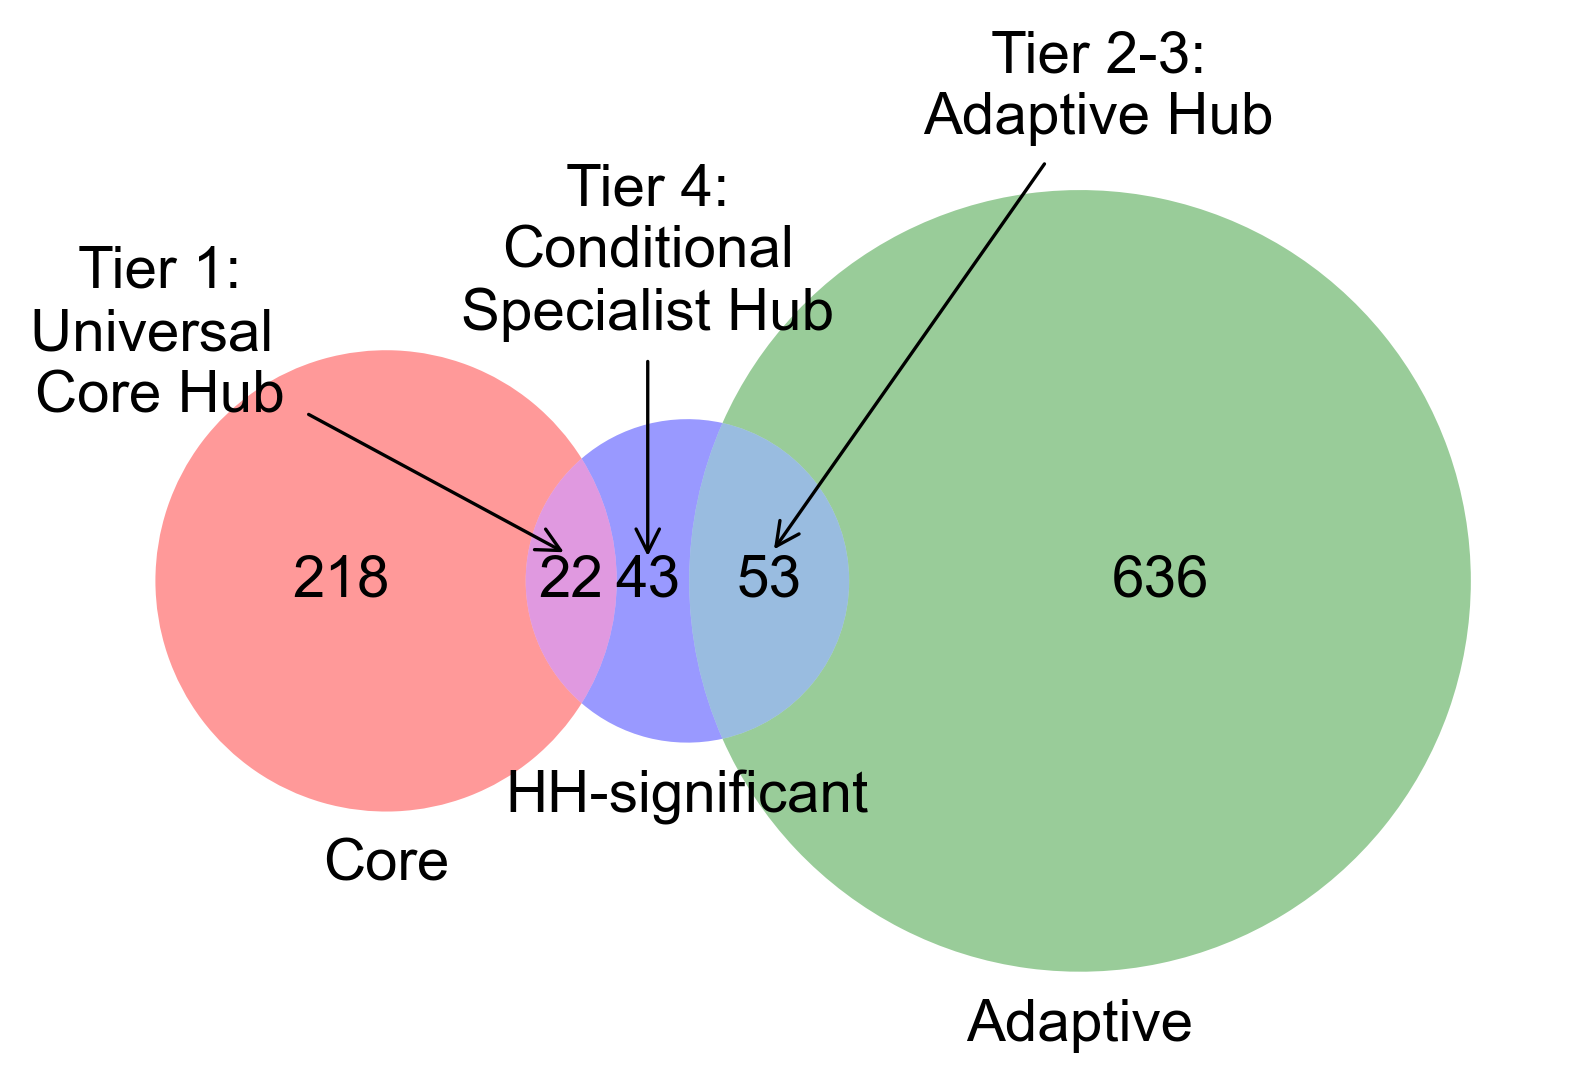

In [50]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

KEY = "feature"

# -----------------------------
# Build clean sets
# -----------------------------
core_global = set(
    merged.loc[merged["pan_bio_class_short"] == "O2-bridging core", KEY]
    .astype(str).str.upper()
)

adaptive_global = set(
    merged.loc[merged["pan_bio_class_short"].isin(["Context-modulator", "Intermediate"]), KEY]
    .astype(str).str.upper()
)

HH_all = set(
    merged_HH_consensus[KEY]
    .astype(str).str.upper()
)

print("Core:", len(core_global))
print("Adaptive:", len(adaptive_global))
print("HH_all:", len(HH_all))

# -----------------------------
# Draw Venn
# -----------------------------
v_fontsize = 14
fig_scale = 1.0
fig, ax = plt.subplots(figsize=(5.42*fig_scale, 5.86*fig_scale), dpi=300)

v = venn3(
    subsets=(core_global, adaptive_global, HH_all),
    set_labels=("Core", "Adaptive", "HH-significant"),
    ax=ax
)


# Reduce label sizes
for text in v.set_labels:
    if text:
        text.set_fontsize(v_fontsize)
for text in v.subset_labels:
    if text:
        text.set_fontsize(v_fontsize)

# -----------------------------
# Tier 1 - Universal core hubs
# region ID = "101"  (Core ) HH)
# -----------------------------
label_t1 = v.get_label_by_id('101')
if label_t1 is not None:
    x1, y1 = label_t1.get_position()
    ax.annotate(
        "Tier 1:\nUniversal \nCore Hub",
        xy=(x1, y1+0.03),
        xytext=(x1 - 0.5, y1 + 0.3),
        arrowprops=dict(arrowstyle="->", lw=0.8),
        fontsize=v_fontsize,
        ha="center",
        va="center",
        # bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
        bbox=dict(boxstyle="round,pad=0.2", fc=(1,1,1,0), ec="none"), #, alpha=0.8),
    )

# -----------------------------
# Tier 2-3 - Adaptive hubs
# region ID = "011"  (Adaptive ) HH)
# -----------------------------
label_t23 = v.get_label_by_id('011')
if label_t23 is not None:
    x2, y2 = label_t23.get_position()
    ax.annotate(
        "Tier 2-3:\nAdaptive Hub",
        xy=(x2, y2+0.03),
        xytext=(x2 + 0.4, y2 + 0.6),
        arrowprops=dict(arrowstyle="->", lw=0.8),
        fontsize=v_fontsize,
        ha="center",
        va="center",
        # bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
        bbox=dict(boxstyle="round,pad=0.2", fc=(1,1,1,0), ec="none"), #, alpha=0.8),

    )

# -----------------------------
# Tier 4 - Conditional background hubs
# region ID = "001"  (HH only)
# -----------------------------
label_t4 = v.get_label_by_id('001')
if label_t4 is not None:
    x4, y4 = label_t4.get_position()
    ax.annotate(
        "Tier 4:\nConditional\nSpecialist Hub",
        xy=(x4, y4+0.02),
        xytext=(x4, y4 + 0.4),
        arrowprops=dict(arrowstyle="->", lw=0.8),
        # arrowprops=dict(arrowstyle="simple", lw=0.8),
        fontsize=v_fontsize,
        ha="center",
        va="center",
        bbox=dict(boxstyle="round,pad=0.2", fc=(1,1,1,0), ec="none"), #, alpha=0.8),
    )

# ax.set_title("Overlap of global classes with HH-significant hubs", fontsize=8)
plt.tight_layout()
tmp_dir_path = OUT_DIR + "/Fig2E_Venn_HH_Context_clean_labeled.png"
plt.savefig(tmp_dir_path, dpi=300)
plt.show()


# Get the subset proteomics HeatMaps 

In [69]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager as fm
from matplotlib.lines import Line2D
from pathlib import Path

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# =====================================================================
# 0. Global plotting style (match OmniProt figures)
# =====================================================================

arial_path = "data/arial.ttf"
arial_font = fm.FontProperties(fname=arial_path)

fm.fontManager.addfont(arial_path)
rcParams["font.family"] = arial_font.get_name()

mpl.rcParams.update({
    "font.family": "Arial",
    "mathtext.default": "regular",
    "axes.linewidth": 1.5,
    "lines.linewidth": 1.5,
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "figure.dpi": 300,
})

def _journal_axes_pca(ax):
    """
    Apply journal-style axes: left & bottom spines only,
    consistent tick styling.
    """
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    ax.tick_params(width=1.5, length=4)


# =====================================================================
# 1. Condition metadata: mapping Condition_key -> (substrate, oxygen)
# =====================================================================

COND_ORDER = [
    "pC_ae", "Ac+pCA_ae", "Ac+CA_ae", "Ac+SF_ae",
    "Ac+SA_ae", "Ac+KL_ae", "SF_ae", "Ac_ae",
    "pC_an", "Ac+pCA_an", "Ac+CA_an", "Ac+SF_an",
    "Ac+SA_an", "Ac+KL_an", "CA_an", "Ac_an",
]

# (short substrate label, oxygen regime)
COND_META = {
    "pC_ae":      ("pC",      "Aerobic"),
    "Ac+pCA_ae":  ("Ac+pCA",  "Aerobic"),
    "Ac+CA_ae":   ("Ac+CA",   "Aerobic"),
    "Ac+SF_ae":   ("Ac+SF",   "Aerobic"),
    "Ac+SA_ae":   ("Ac+SA",   "Aerobic"),
    "Ac+KL_ae":   ("Ac+KL",   "Aerobic"),
    "SF_ae":      ("SF",      "Aerobic"),
    "Ac_ae":      ("Acetate", "Aerobic"),
    "pC_an":      ("pC",      "Anaerobic"),
    "Ac+pCA_an":  ("Ac+pCA",  "Anaerobic"),
    "Ac+CA_an":   ("Ac+CA",   "Anaerobic"),
    "Ac+SF_an":   ("Ac+SF",   "Anaerobic"),
    "Ac+SA_an":   ("Ac+SA",   "Anaerobic"),
    "Ac+KL_an":   ("Ac+KL",   "Anaerobic"),
    "CA_an":      ("CA",      "Anaerobic"),
    "Ac_an":      ("Acetate", "Anaerobic"),
}

# Oxygen regime encoded by POINT COLOR
O2_COLORS = {
    "Aerobic":   "#1f77b4",  # blue
    "Anaerobic": "#d62728",  # red
}

SUBSTRATE_ORDER = [
    "pC", "Ac+pCA", "Ac+CA", "Ac+SF",
    "Ac+SA", "Ac+KL", "SF", "CA", "Acetate",
]


# =====================================================================
# 2. Data loading (proteomics)
# =====================================================================

ProteomicsDataFile = "proteomics_data.xlsx"

df = pd.read_excel(ProteomicsDataFile, sheet_name="Sheet1")

# Proteomic features: same slice as in your OmniProt pipeline
feat_df = df.iloc[:, 5:1862].copy()
feat_df.columns = feat_df.columns.astype(str).str.upper()  # ensure uppercase
X = feat_df.to_numpy(dtype=np.float32)
feature_names = feat_df.columns.to_numpy()

# Growth targets (not used here) and metadata
y = df[["GR_mean", "GR_sd"]].to_numpy(dtype=np.float32)
y_meta = df[["Condition", "Oxygen", "Replicate",
             "Condition_key", "Condition_key_rep"]]

n_samples, n_features = X.shape
print(f"Data loaded: X.shape = {X.shape}, y.shape = {y.shape}")

# Condition_key and Oxygen codes per sample
cond_keys = y_meta["Condition_key"].to_numpy()
oxy_codes = y_meta["Oxygen"].to_numpy()

# =====================================================================
# 4. Marker assignment: same substrate Â same marker
# =====================================================================

cond_names_for_markers = [
    ck for ck in COND_ORDER if ck in np.unique(cond_keys).tolist()
]
short_labels_for_markers = [COND_META[ck][0] for ck in cond_names_for_markers]

unique_short = []
for sl in short_labels_for_markers:
    if sl not in unique_short:
        unique_short.append(sl)

unique_short = sorted(
    unique_short,
    key=lambda s: SUBSTRATE_ORDER.index(s) if s in SUBSTRATE_ORDER else len(SUBSTRATE_ORDER)
)

MARKERS = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "d", "h", "H", "*", "8"]

short2marker = {
    sl: MARKERS[i % len(MARKERS)]
    for i, sl in enumerate(unique_short)
}


# =====================================================================
# =====================================================================


def load_group_feature_sets(
    excel_path: str,
    group_sheet_map: dict,
    key_col: str = "feature"
) -> dict:
    """
    Read multiple sheets from an Excel file and return a dict:
        {group_name: set_of_feature_ids}

    - excel_path: path to the Excel file
    - group_sheet_map: {group_name: sheet_name}
    - key_col: column to use as feature identifier (default: 'feature')
    """
    group_to_ids = {}

    for group_name, sheet_name in group_sheet_map.items():
        try:
            df = pd.read_excel(excel_path, sheet_name=sheet_name)
        except Exception as e:
            print(f"[WARN] Could not read sheet '{sheet_name}' for group '{group_name}': {e}")
            continue

        if key_col not in df.columns:
            print(f"[WARN] Column '{key_col}' not found in sheet '{sheet_name}' (group '{group_name}')")
            continue

        ids = (
            df[key_col]
            .astype(str)
            .str.strip()
            .str.upper()
        )
        group_to_ids[group_name] = set(ids)

        print(f"[INFO] Loaded group '{group_name}' from sheet '{sheet_name}': {len(group_to_ids[group_name])} features")

    return group_to_ids


anchor_conditions = {"Ac_ae", "Ac_an"}  # highlight if desired

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

def compute_ae_an_diff(
    X_df: pd.DataFrame,
    y_meta: pd.DataFrame,
    oxygen_col: str = "Oxygen",
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    Compute Ae vs An differential expression statistics per gene.

    X_df: samples × features (e.g., feat_df_z_cond)
    y_meta: metadata with an 'Oxygen' column containing 'Aerobic'/'Anaerobic'

    Returns a DataFrame with:
      Gene, mean_Ae, mean_An, diff_An_minus_Ae,
      p_raw, q_value, direction ('Ae_up' / 'An_up' / 'ns')
    """
    X_df = X_df.copy()
    X_df.columns = X_df.columns.astype(str)

    # boolean masks for samples
    ae_mask = (y_meta[oxygen_col] == "Aerobic").to_numpy()
    an_mask = (y_meta[oxygen_col] == "Anaerobic").to_numpy()

    genes = X_df.columns
    pvals = []
    mean_ae = []
    mean_an = []
    diff_an_ae = []

    for g in genes:
        ae_vals = X_df.loc[ae_mask, g].to_numpy(dtype=float)
        an_vals = X_df.loc[an_mask, g].to_numpy(dtype=float)

        # means
        m_ae = np.nanmean(ae_vals)
        m_an = np.nanmean(an_vals)

        mean_ae.append(m_ae)
        mean_an.append(m_an)
        diff_an_ae.append(m_an - m_ae)

        # Welch t-test
        tstat, p = ttest_ind(ae_vals, an_vals, equal_var=False, nan_policy="omit")
        pvals.append(p)

    # FDR correction
    _, qvals, _, _ = multipletests(pvals, method="fdr_bh")

    res = pd.DataFrame({
        "Gene": genes,
        "mean_Ae": mean_ae,
        "mean_An": mean_an,
        "diff_An_minus_Ae": diff_an_ae,
        "p_raw": pvals,
        "q_value": qvals,
    })

    # direction: An > Ae (positive diff) vs Ae > An (negative diff)
    res["direction"] = "ns"
    sig_mask = res["q_value"] < alpha
    res.loc[sig_mask & (res["diff_An_minus_Ae"] > 0), "direction"] = "An_up"
    res.loc[sig_mask & (res["diff_An_minus_Ae"] < 0), "direction"] = "Ae_up"

    return res

# =====================================================================
# 6. Per-subset proteomics heatmaps (per-gene z-score)
# =====================================================================

def make_subset_heatmap(X_df, subset_name: str, subset_ids,  ae_up_genes, an_up_genes, fig_scale=1.0):
    """
    Make a per-gene z-scored heatmap of proteomics log2 intensities
    for a given subset of genes (subset_ids).
    Rows: genes, Columns: conditions (Ae/An with Control_ae/an relabeling).
    """

    subset_ids = {g.upper() for g in subset_ids}
    subset_genes = [g for g in subset_ids if g in X_df.columns]

    if not subset_genes:
        print(f"[{subset_name}] No matching genes in proteomics. Skipping heatmap.")
        return

    print(f"[{subset_name}] Heatmap for {len(subset_genes)} genes.")

    # Build long-form dataframe: meta + selected genes
    plot_df = pd.concat(
        [y_meta.reset_index(drop=True),
         X_df[subset_genes].reset_index(drop=True)],
        axis=1,
    )

    # Rename control conditions
    rename_map = {
        "Ac_ae": "Control_ae",
        "Ac_an": "Control_an",
    }
    plot_df["Condition_key"] = plot_df["Condition_key"].replace(rename_map)
    plot_df["Condition"]     = plot_df["Condition"].replace(rename_map)

    # Melt and summarize mean expression per Gene Ã Condition_key
    summary = (
        plot_df.melt(
            id_vars=["Condition", "Oxygen", "Replicate",
                     "Condition_key", "Condition_key_rep"],
            value_vars=subset_genes,
            var_name="Gene",
            value_name="log2_Intensity",
        )
        .groupby(["Gene", "Condition_key"], as_index=False)["log2_Intensity"]
        .mean()
    )

    preferred_order = [
        "pC_ae", "Ac+pCA_ae", "Ac+CA_ae", "Ac+SF_ae",
        "Ac+SA_ae", "Ac+KL_ae", "SF_ae", "Control_ae",
        "pC_an", "Ac+pCA_an", "Ac+CA_an", "Ac+SF_an",
        "Ac+SA_an", "Ac+KL_an", "CA_an", "Control_an",
    ]

    all_conditions = sorted(summary["Condition_key"].unique())
    conditions = [c for c in preferred_order if c in all_conditions]

    # Pivot: Gene Ã Condition_key
    heat = summary.pivot(
        index="Gene",
        columns="Condition_key",
        values="log2_Intensity",
    )

    genes_in_heat = [g for g in subset_genes if g in heat.index]
    heat = heat.loc[genes_in_heat, conditions]

    # Order: Ae_up at top, An_up next, then the rest
    ae_order = [g for g in genes_in_heat if g in ae_up_genes]
    an_order = [g for g in genes_in_heat if g in an_up_genes and g not in ae_up_genes]
    rest     = [g for g in genes_in_heat if g not in ae_up_genes and g not in an_up_genes]

    ordered_genes = ae_order + an_order + rest

    if not ordered_genes:
        print(f"[{subset_name}] No genes left after ordering. Skipping.")
        return
    heat = heat.loc[ordered_genes, conditions]

    # # Row-wise z-score (per gene)
    # heat_z = heat.sub(heat.mean(axis=1), axis=0).div(heat.std(axis=1), axis=0)
    # Column-wise z-score (per condition)
    # heat_z = heat.sub(heat.mean(axis=0), axis=1).div(heat.std(axis=0), axis=1)
    heat_z = heat

    # Plot
    n_genes = heat_z.shape[0]
    ncols = heat_z.shape[1]

    
    # fig_scale = 1.0  # for screen
    fig_height = 5.87*fig_scale
    # fig_height = max(2.5, 0.22 * n_genes)
    fig_width = 4.89*fig_scale
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    #  ---- Convert to numeric matrix ----
    H = heat_z.to_numpy(dtype=float)
    # ---- Choose vmax (robust for proteomics) ----
    # vmax = np.nanpercentile(H, 97)
    # ---- Plot with imshow ----
    im = ax.imshow(
        H,
        aspect="auto",
        cmap='bwr'
    )
        
    if n_genes <= 43:
        ax.set_yticks(np.arange(n_genes)) #+  0.5)
        ax.set_yticklabels(heat_z.index, fontsize=6)
    else:
        # Remove Y ticks (gene names)
        ax.set_yticks([])

    SHAP_COLS = conditions
    xtick_positions = np.arange(len(SHAP_COLS)) #+ 0.5
    ax.set_xticks(xtick_positions)


    def _meta_key(cond):
        """Map Control_* back to Ac_* for COND_META lookup."""
        if cond == "Control_ae":
            return "Ac_ae"
        if cond == "Control_an":
            return "Ac_an"
        return cond

    short_labels = [
        COND_META.get(_meta_key(c), (c, ""))[0]
        for c in SHAP_COLS
    ]
    ax.set_xticklabels(short_labels, rotation=45, ha="right", fontsize=6)

    # ax.set_xlim(0, len(SHAP_COLS))
    ax.set_xlabel("Condition", fontsize=7, labelpad=12)
    ax.set_ylabel("Genes", fontsize=7)

    # Aerobic / Anaerobic grouping
    aer_idx = [
        i for i, c in enumerate(SHAP_COLS)
        if COND_META.get(_meta_key(c), ("", ""))[1] == "Aerobic"
    ]
    ana_idx = [
        i for i, c in enumerate(SHAP_COLS)
        if COND_META.get(_meta_key(c), ("", ""))[1] == "Anaerobic"
    ]

    if aer_idx and ana_idx:
        groups = {
            "Aerobic": {
                "mid": (min(aer_idx) + max(aer_idx) + 1) / 2.0,
                "end": max(aer_idx) + 1.0,
            },
            "Anaerobic": {
                "mid": (min(ana_idx) + max(ana_idx) + 1) / 2.0,
                "end": max(ana_idx) + 1.0,
            },
        }

        ordered = sorted(groups.keys(), key=lambda gname: groups[gname]["mid"])
        left_group, right_group = ordered[0], ordered[1]

        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks([
            groups[left_group]["mid"],
            groups[right_group]["mid"],
        ])
        ax_top.set_xticklabels(ordered, fontsize=7, fontweight="bold")
        ax_top.xaxis.set_ticks_position("bottom")
        ax_top.xaxis.set_label_position("bottom")
        ax_top.spines["bottom"].set_position(("outward", 22))
        ax_top.tick_params(length=0)
        ax_top.spines["bottom"].set_visible(False)

        # vertical separator between Aerobic and Anaerobic
        sep_pos = groups[left_group]["end"]
        ax.axvline(sep_pos-0.5, color="k", linewidth=1.5, zorder=10)

    for spine in ["top", "right", "left", "bottom"]:
        # ax.spines[spine].set_visible(False)
        ax.spines[spine].set_visible(True)

    # Colorbar (short, on the right)
    # heatmap = ax.collections[0]
    cbar_ax = fig.add_axes([0.92, 0.30, 0.03, 0.45])
    # cbar = fig.colorbar(heatmap, cax=cbar_ax)
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.set_ylabel("z-score", rotation=90, labelpad=5, fontsize=7)
    cbar.ax.tick_params(labelsize=6)

    # fig.tight_layout()

    # out_dir = Path("figures/Panels")
    out_dir = Path("figures/FigS2_S3")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"Main_Heatmap_zscore_expression_{subset_name}.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print(f"Saved heatmap for {subset_name} to:", out_path)

    plt.show()


Data loaded: X.shape = (80, 1857), y.shape = (80, 2)


## plot the heatmaps

[INFO] Loaded group 'FULL' from sheet 'pan_condition': 1857 features
[WARN] Could not read sheet 'PANo2BridgingCore' for group 'pan_Top': Worksheet named 'PANo2BridgingCore' not found
[INFO] Loaded group 'PAN_ContextModulators' from sheet 'PAN_ContextModulators': 225 features
[INFO] Loaded group 'PAN_Intermediate' from sheet 'PAN_Intermediate': 464 features
[INFO] Loaded group 'PAN_Background' from sheet 'PAN_Background': 928 features
[INFO] Loaded group 'HH_consensus' from sheet 'HH_consensus': 118 features
[INFO] Loaded group 'HH_context_pan' from sheet 'HH_context_pan': 96 features
[INFO] Loaded group 'Tier1_UniversalCore_HH' from sheet 'Tier1_UniversalCore_HH': 22 features
[INFO] Loaded group 'Tier2_AdaptiveGeneralist_HH' from sheet 'Tier2_AdaptiveGeneralist_HH': 22 features
[INFO] Loaded group 'Tier3_AdaptiveSpecialist_HH' from sheet 'Tier3_AdaptiveSpecialist_HH': 31 features
[INFO] Loaded group 'Tier4_ConditionalBackground_HH' from sheet 'Tier4_ConditionalBackground_HH': 43 featu

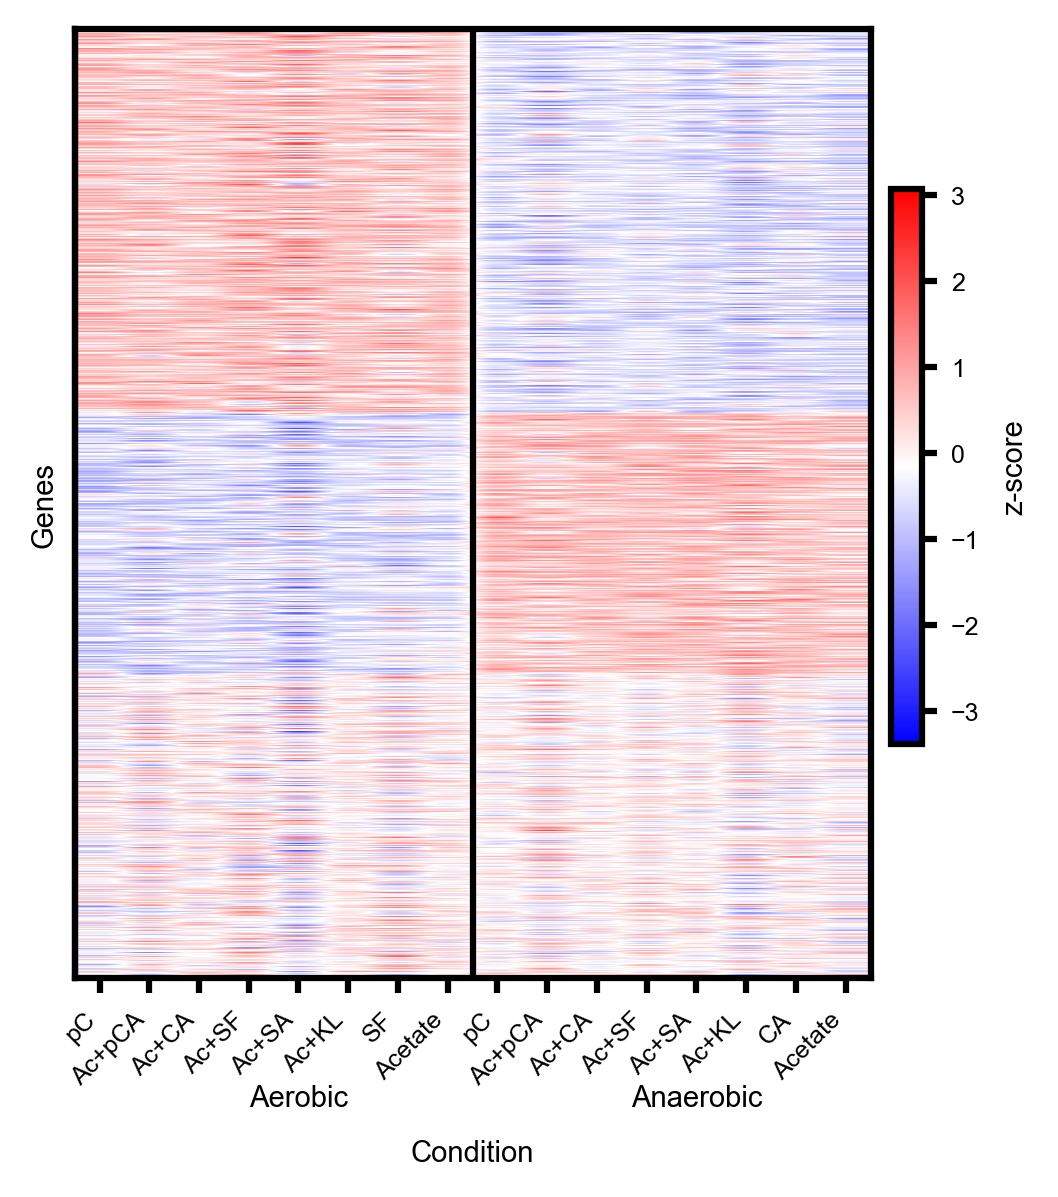

[PAN_ContextModulators] Heatmap for 225 genes.
Saved heatmap for PAN_ContextModulators to: figures/Hubs/Main_Heatmap_zscore_expression_PAN_ContextModulators.png


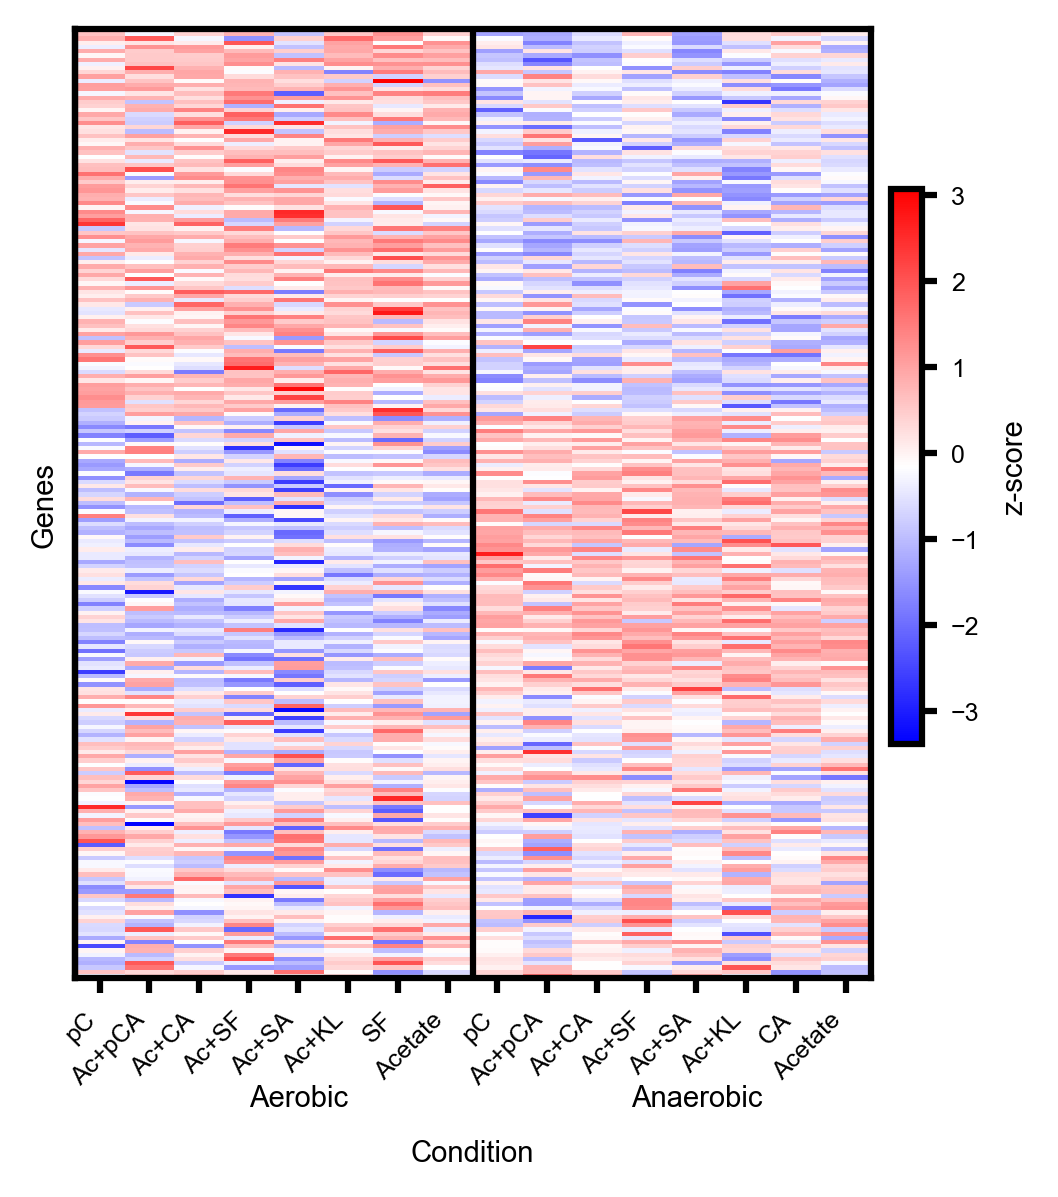

[PAN_Intermediate] Heatmap for 464 genes.
Saved heatmap for PAN_Intermediate to: figures/Hubs/Main_Heatmap_zscore_expression_PAN_Intermediate.png


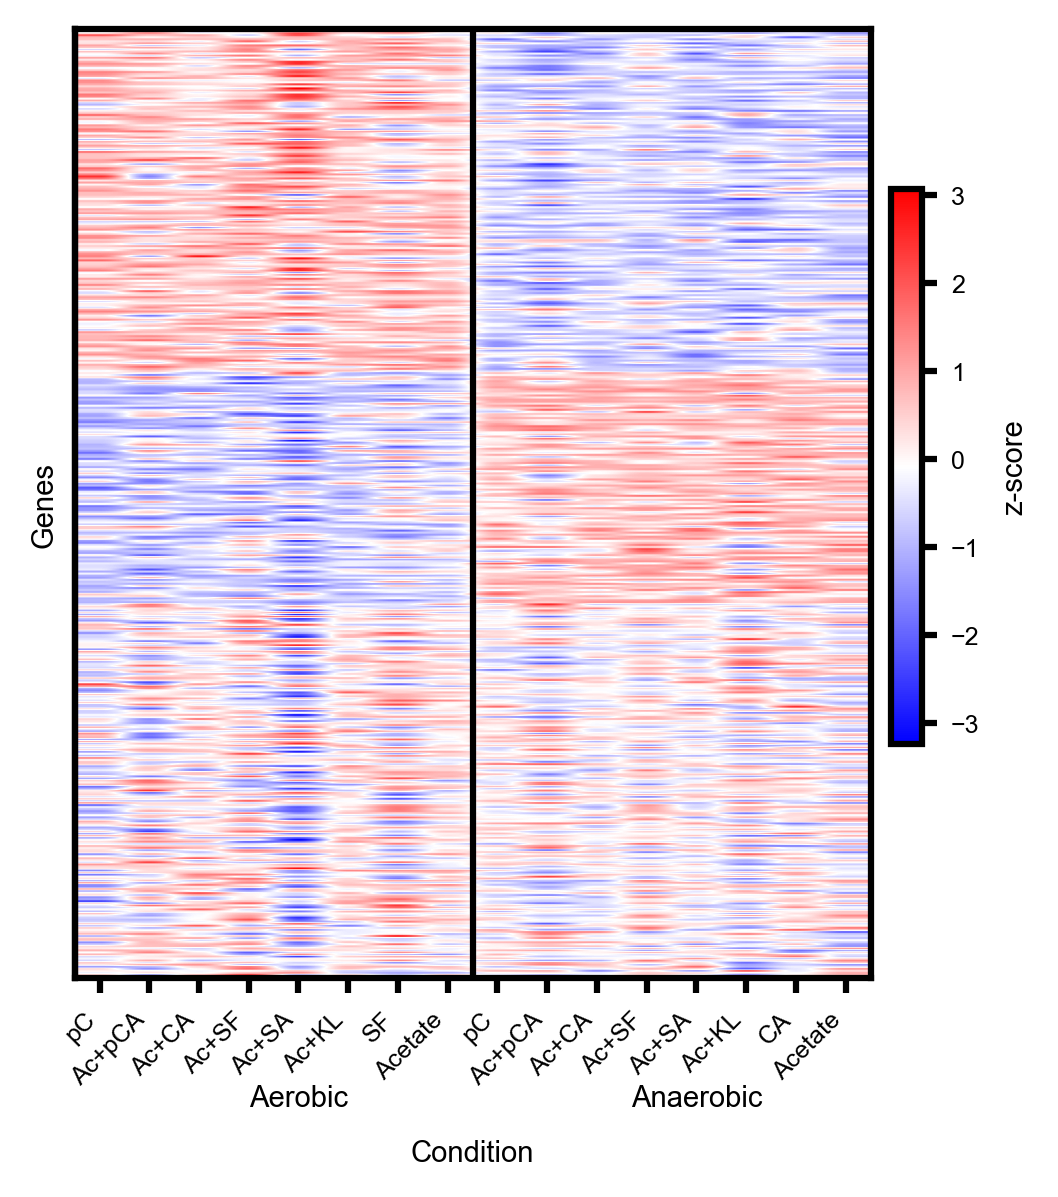

[PAN_Background] Heatmap for 928 genes.
Saved heatmap for PAN_Background to: figures/Hubs/Main_Heatmap_zscore_expression_PAN_Background.png


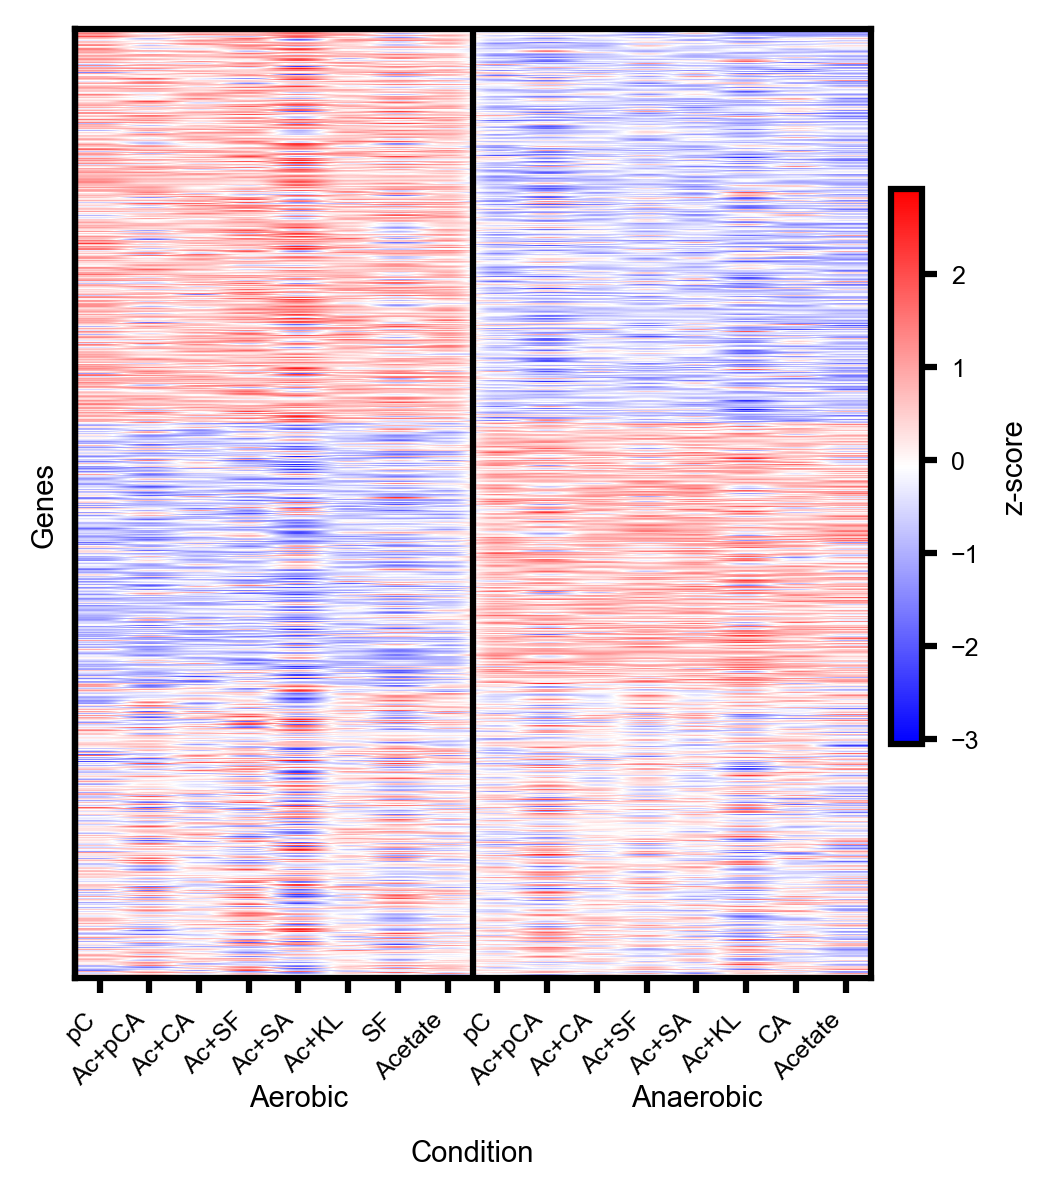

[HH_consensus] Heatmap for 118 genes.
Saved heatmap for HH_consensus to: figures/Hubs/Main_Heatmap_zscore_expression_HH_consensus.png


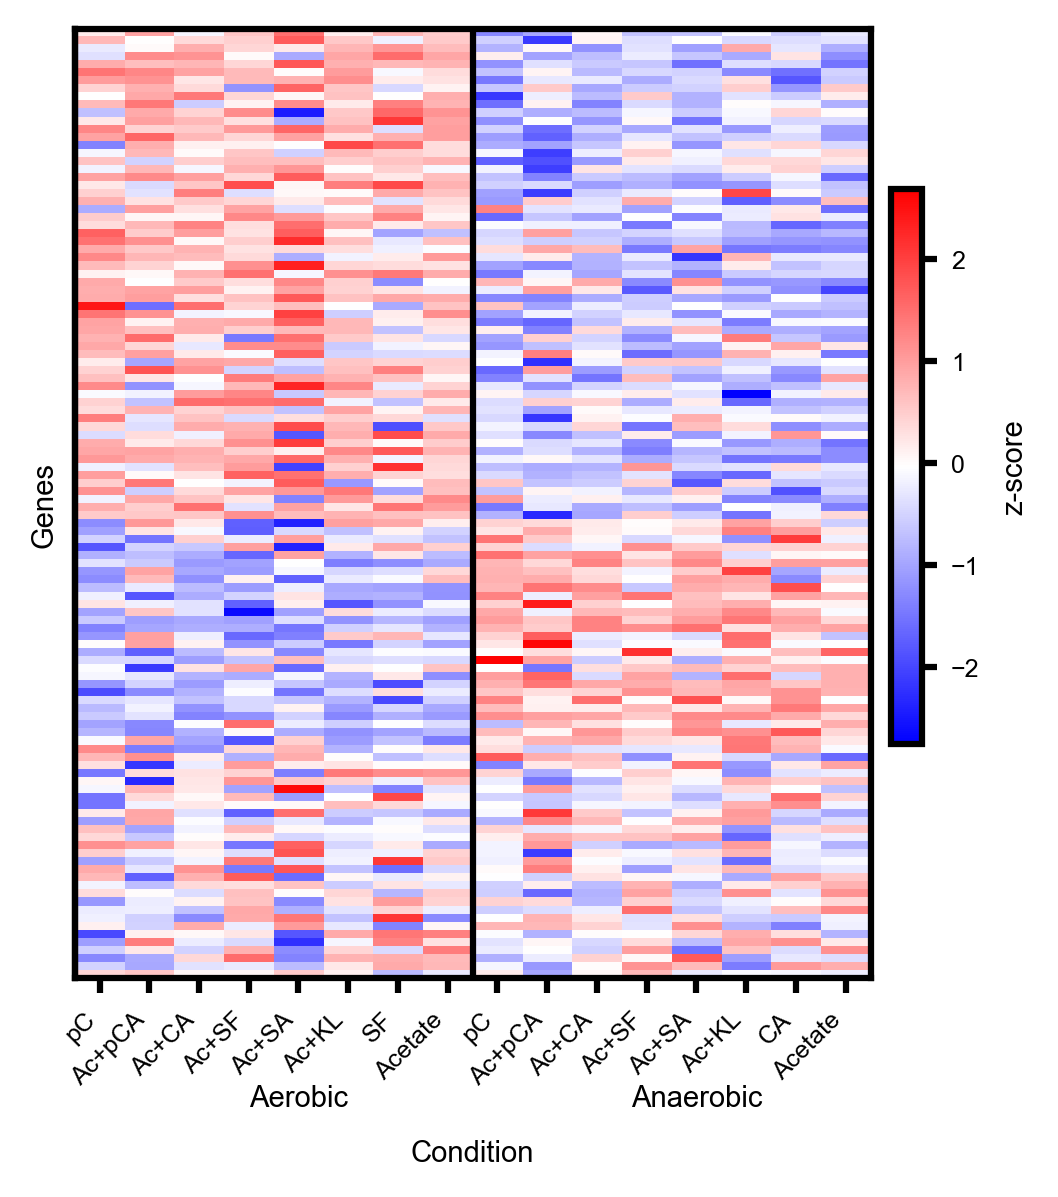

[HH_context_pan] Heatmap for 96 genes.
Saved heatmap for HH_context_pan to: figures/Hubs/Main_Heatmap_zscore_expression_HH_context_pan.png


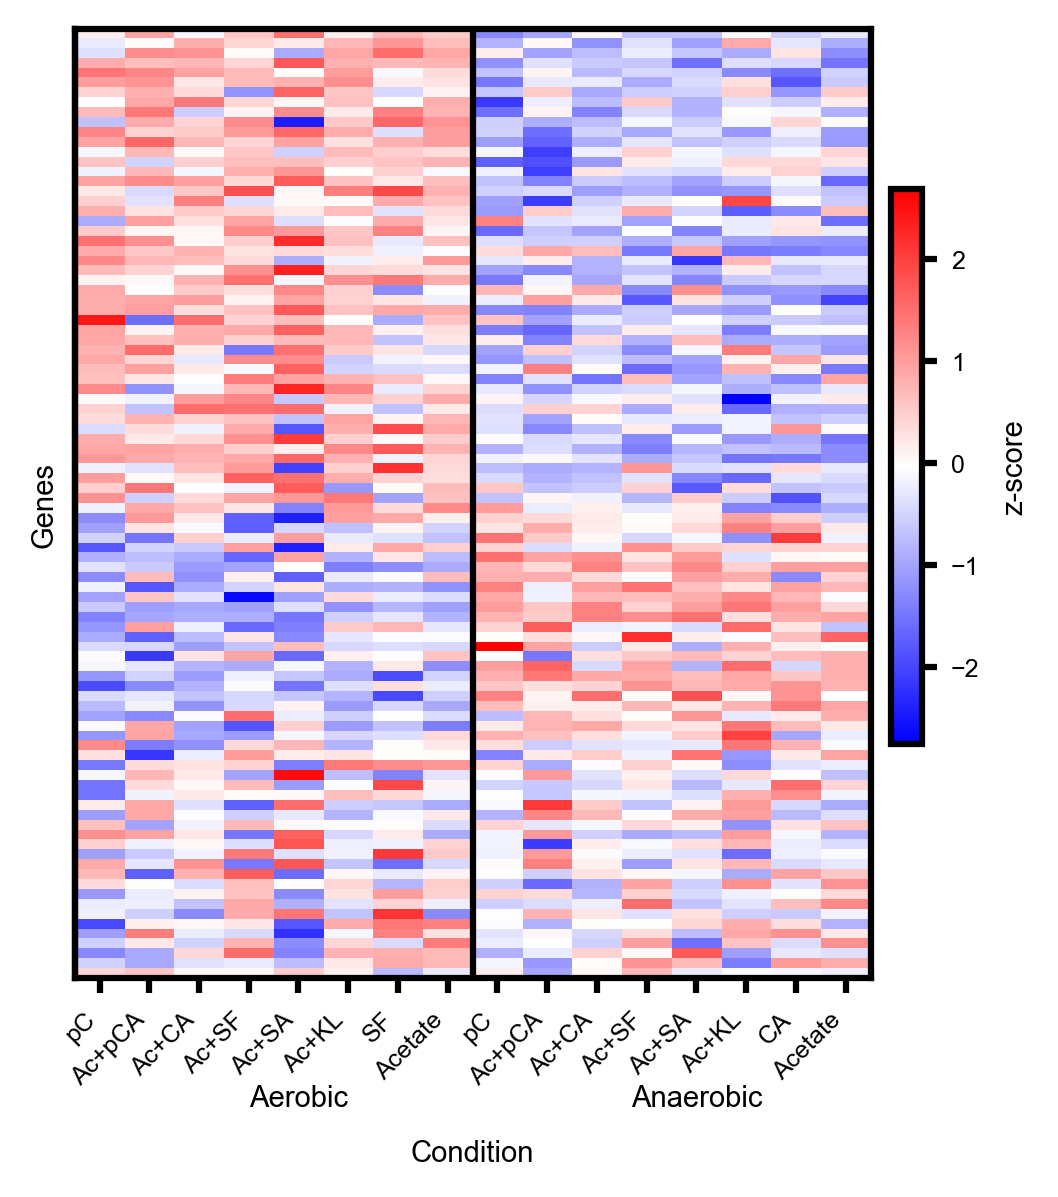

[Tier1_UniversalCore_HH] Heatmap for 22 genes.
Saved heatmap for Tier1_UniversalCore_HH to: figures/Hubs/Main_Heatmap_zscore_expression_Tier1_UniversalCore_HH.png


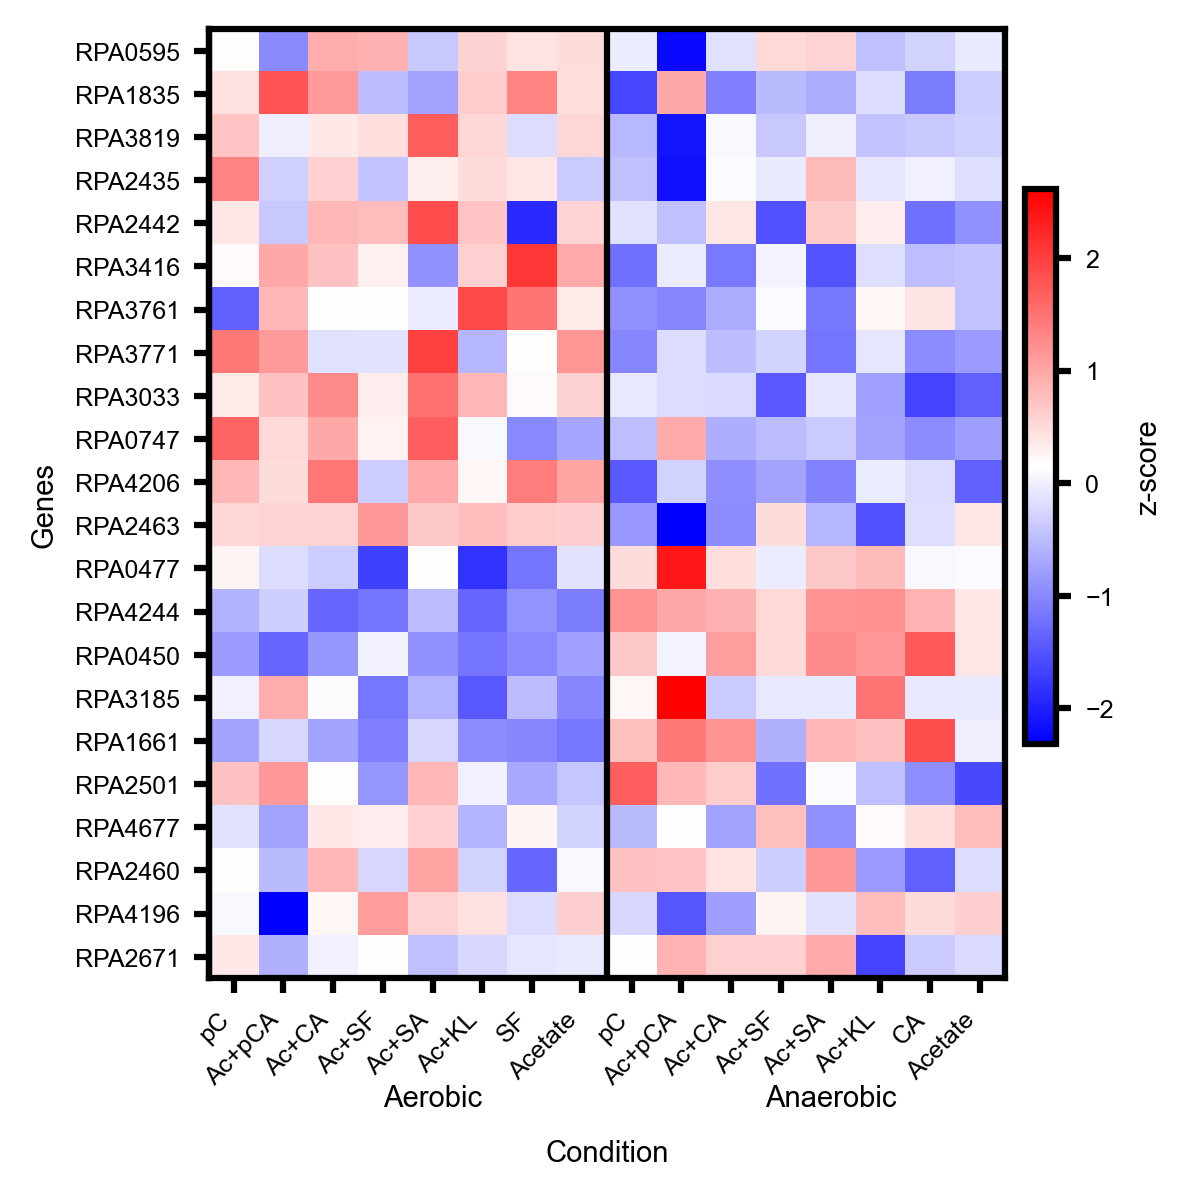

[Tier2_AdaptiveGeneralist_HH] Heatmap for 22 genes.
Saved heatmap for Tier2_AdaptiveGeneralist_HH to: figures/Hubs/Main_Heatmap_zscore_expression_Tier2_AdaptiveGeneralist_HH.png


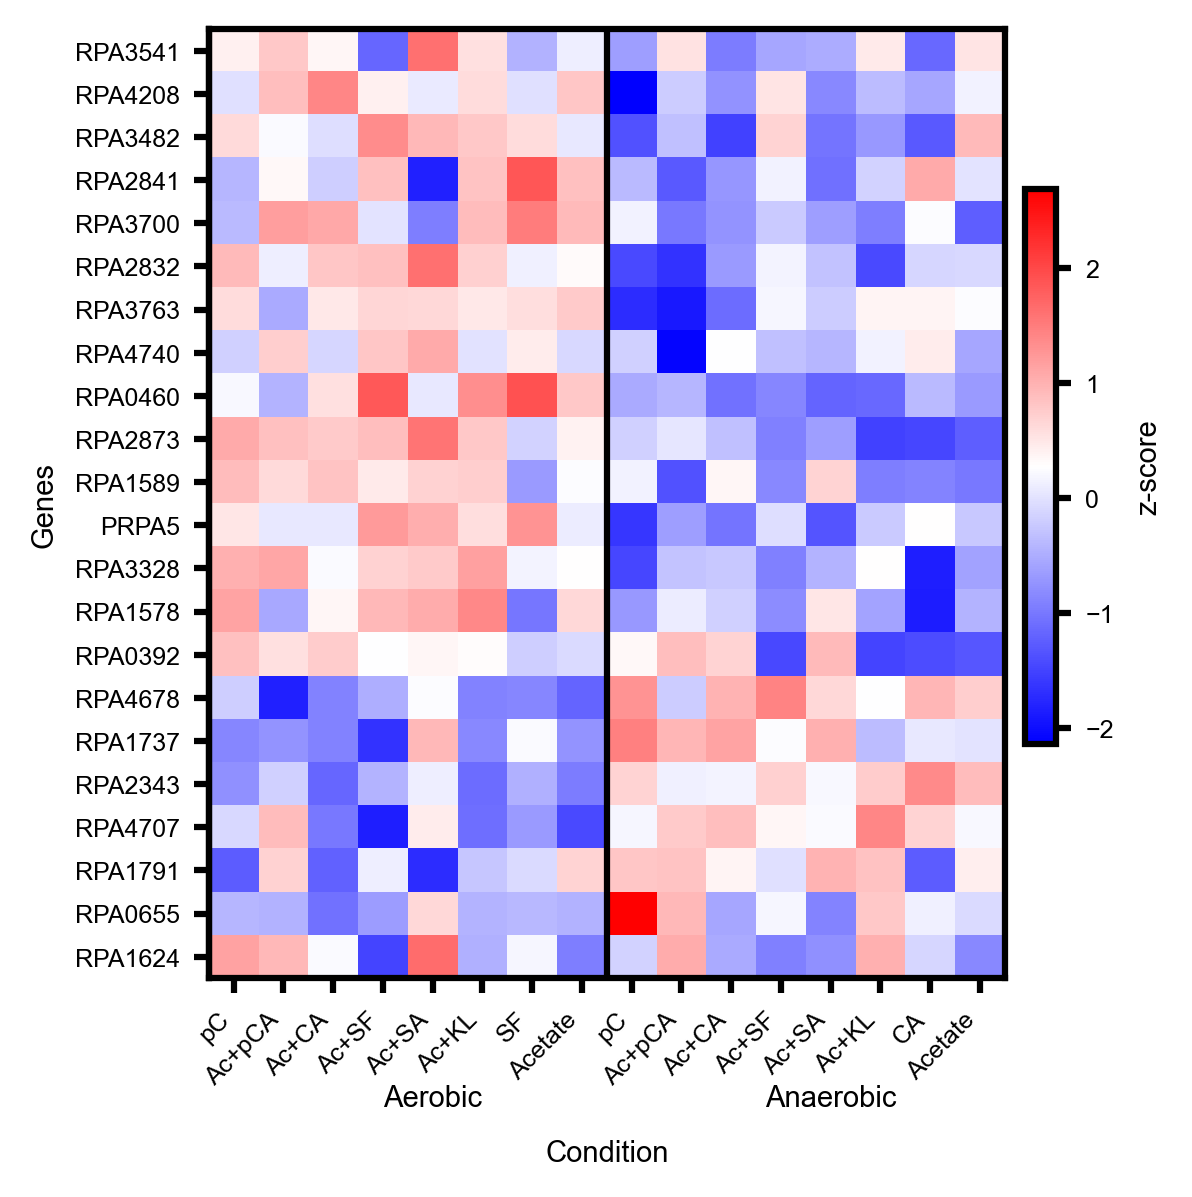

[Tier3_AdaptiveSpecialist_HH] Heatmap for 31 genes.
Saved heatmap for Tier3_AdaptiveSpecialist_HH to: figures/Hubs/Main_Heatmap_zscore_expression_Tier3_AdaptiveSpecialist_HH.png


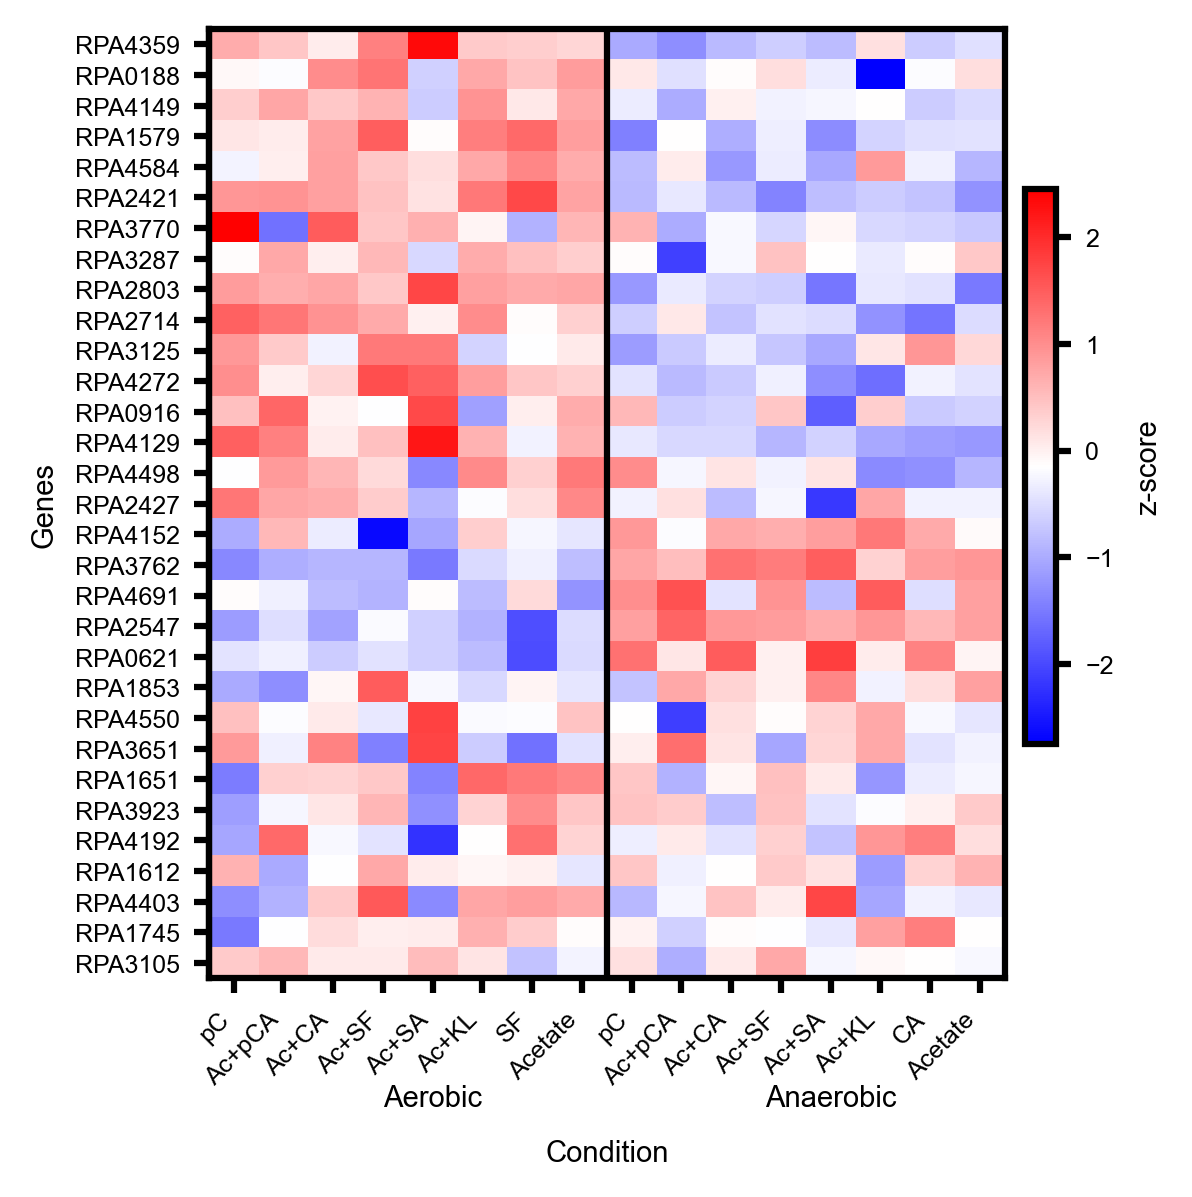

[Tier4_ConditionalBackground_HH] Heatmap for 43 genes.
Saved heatmap for Tier4_ConditionalBackground_HH to: figures/Hubs/Main_Heatmap_zscore_expression_Tier4_ConditionalBackground_HH.png


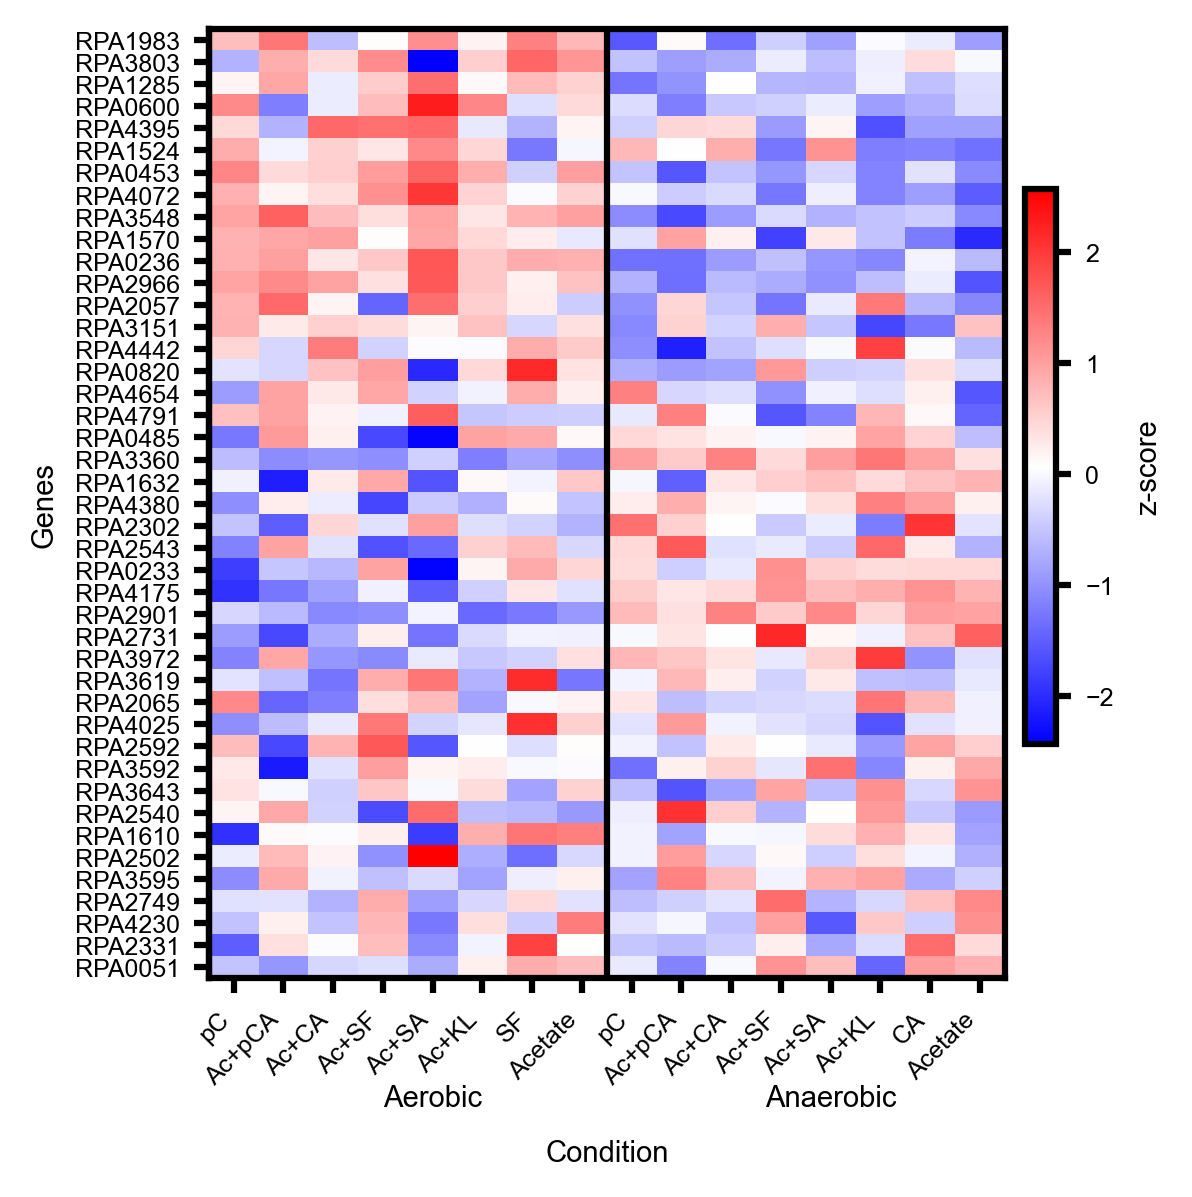

In [75]:

# =====================================================================
#  Load HH / core gene sets
# =====================================================================
hh_excel_path = "results/output.xlsx" 
groupname_sheetname_maps = {
    "FULL": "pan_condition",
    "pan_Top": "PANo2BridgingCore",
    "PAN_ContextModulators": "PAN_ContextModulators",
    "PAN_Intermediate": "PAN_Intermediate",
    "PAN_Background": "PAN_Background",

    "HH_consensus": "HH_consensus",
    "HH_context_pan": "HH_context_pan",

    "Tier1_UniversalCore_HH": "Tier1_UniversalCore_HH",
    "Tier2_AdaptiveGeneralist_HH": "Tier2_AdaptiveGeneralist_HH",
    "Tier3_AdaptiveSpecialist_HH": "Tier3_AdaptiveSpecialist_HH",
    "Tier4_ConditionalBackground_HH": "Tier4_ConditionalBackground_HH",

}
hh_excel_path = "pan_condition_scores_merged_Interp_1a_ANOVAstyle.xlsx"

group_feature_sets = load_group_feature_sets(
    hh_excel_path,
    groupname_sheetname_maps,
    key_col="feature"
)




# (replicate-level normalization inside each condition)
feat_df_z_cond = feat_df.groupby(y_meta["Condition_key"]).transform(lambda g: (g - g.mean()) / g.std(ddof=0))
# (each sample normalized across its own features)
feat_df_z_sample = feat_df.sub(feat_df.mean(axis=1), axis=0).div(feat_df.std(axis=1, ddof=0), axis=0)
# (standard feature scaling across the whole dataset)
feat_df_z_global = feat_df.sub(feat_df.mean(axis=0), axis=1).div(feat_df.std(axis=0, ddof=0), axis=1)
# X_df = feat_df
# X_df = feat_df
# X_df = feat_df_z_cond 
# X_df = feat_df_z_sample 
X_df = feat_df_z_global

aean_stats = compute_ae_an_diff(X_df, y_meta, oxygen_col="Oxygen", alpha=0.05)
ae_up_genes = set(aean_stats.loc[aean_stats["direction"] == "Ae_up", "Gene"])
an_up_genes = set(aean_stats.loc[aean_stats["direction"] == "An_up", "Gene"])
print("Ae_up genes:", len(ae_up_genes))
print("An_up genes:", len(an_up_genes))

# Now generate heatmaps per subset
for group_name, id_set in group_feature_sets.items():
    # You can filter which ones to plot if needed
    # e.g., only tiers:
    # if not group_name.startswith("Tier"): 
    #     continue
    # make_subset_heatmap(X_df, group_name, id_set, ae_up_genes, an_up_genes, fig_scale=1.0)
    make_subset_heatmap(X_df, group_name, id_set, ae_up_genes, an_up_genes, fig_scale=0.7)




## plot heatmaps for some genes

Proteomics loaded: (80, 1857) metadata: (80, 5)
Gene label map size: 2212
Example RPA4668 -> coxM
Saved heatmap for Markers_with_Status to: figures/Hubs/Main_Heatmap_Markers_with_Status.png


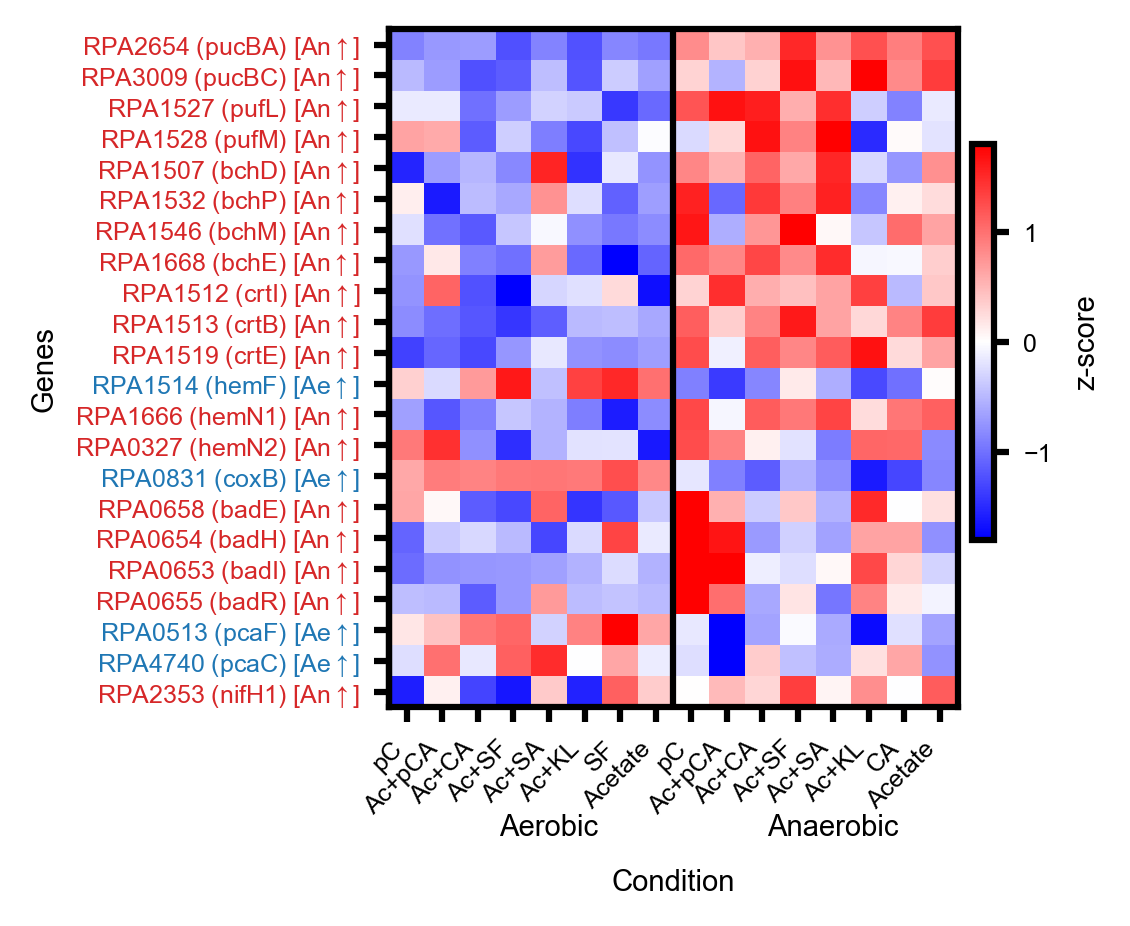

In [118]:
# ============================================================
# Full script: Heatmap for a custom gene list with optional
# (1) gene label annotation: "RPA4668 (coxM)"
# (2) differential-status tag: [Ae] / [An] / [ns]
# (3) optional rearrangement by differential status
# (4) optional colored ytick labels + optional left status strip
# ============================================================

import os
import re
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager as fm
from pathlib import Path

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests


# ============================================================
# 0) Global plotting style
# ============================================================

arial_path = "data/arial.ttf"
if os.path.exists(arial_path):
    arial_font = fm.FontProperties(fname=arial_path)
    fm.fontManager.addfont(arial_path)
    rcParams["font.family"] = arial_font.get_name()

mpl.rcParams.update({
    "font.family": "Arial",
    "mathtext.default": "regular",
    "axes.linewidth": 1.5,
    "lines.linewidth": 1.5,
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "figure.dpi": 300,
})


# ============================================================
# 1) Condition metadata
# ============================================================

COND_META = {
    "pC_ae":      ("pC",      "Aerobic"),
    "Ac+pCA_ae":  ("Ac+pCA",  "Aerobic"),
    "Ac+CA_ae":   ("Ac+CA",   "Aerobic"),
    "Ac+SF_ae":   ("Ac+SF",   "Aerobic"),
    "Ac+SA_ae":   ("Ac+SA",   "Aerobic"),
    "Ac+KL_ae":   ("Ac+KL",   "Aerobic"),
    "SF_ae":      ("SF",      "Aerobic"),
    "Ac_ae":      ("Acetate", "Aerobic"),
    "pC_an":      ("pC",      "Anaerobic"),
    "Ac+pCA_an":  ("Ac+pCA",  "Anaerobic"),
    "Ac+CA_an":   ("Ac+CA",   "Anaerobic"),
    "Ac+SF_an":   ("Ac+SF",   "Anaerobic"),
    "Ac+SA_an":   ("Ac+SA",   "Anaerobic"),
    "Ac+KL_an":   ("Ac+KL",   "Anaerobic"),
    "CA_an":      ("CA",      "Anaerobic"),
    "Ac_an":      ("Acetate", "Anaerobic"),
}


# ============================================================
# 2) GN extraction + label-map builder
# ============================================================

_GN_RE = re.compile(r"\bGN=([A-Za-z0-9_.-]+)")

def extract_gn(desc: str):
    if desc is None:
        return None
    if isinstance(desc, float) and np.isnan(desc):
        return None
    m = _GN_RE.search(str(desc))
    return m.group(1) if m else None

def build_gene_label_map(annot_df: pd.DataFrame,
                         id_col: str = "feature",
                         desc_col: str = "Description") -> dict:
    tmp = annot_df.copy()
    tmp[id_col] = tmp[id_col].astype(str).str.upper().str.strip()
    tmp["GN"] = tmp[desc_col].apply(extract_gn)
    tmp = tmp.dropna(subset=["GN"]).drop_duplicates(subset=[id_col], keep="first")
    return dict(zip(tmp[id_col], tmp["GN"]))


# ============================================================
# 3) Differential Ae vs An function (FDR q-values)
# ============================================================

def compute_ae_an_diff(
    X_df: pd.DataFrame,
    y_meta: pd.DataFrame,
    oxygen_col: str = "Oxygen",
    alpha: float = 0.05
) -> pd.DataFrame:
    X_df = X_df.copy()
    X_df.columns = X_df.columns.astype(str).str.upper().str.strip()

    ae_mask = (y_meta[oxygen_col] == "Aerobic").to_numpy()
    an_mask = (y_meta[oxygen_col] == "Anaerobic").to_numpy()

    genes = X_df.columns
    pvals, mean_ae, mean_an, diff_an_ae = [], [], [], []

    for g in genes:
        ae_vals = X_df.loc[ae_mask, g].to_numpy(dtype=float)
        an_vals = X_df.loc[an_mask, g].to_numpy(dtype=float)

        m_ae = np.nanmean(ae_vals)
        m_an = np.nanmean(an_vals)

        mean_ae.append(m_ae)
        mean_an.append(m_an)
        diff_an_ae.append(m_an - m_ae)

        _, p = ttest_ind(ae_vals, an_vals, equal_var=False, nan_policy="omit")
        pvals.append(p)

    _, qvals, _, _ = multipletests(pvals, method="fdr_bh")

    res = pd.DataFrame({
        "Gene": genes,
        "mean_Ae": mean_ae,
        "mean_An": mean_an,
        "diff_An_minus_Ae": diff_an_ae,
        "p_raw": pvals,
        "q_value": qvals,
    })

    res["direction"] = "ns"
    sig_mask = res["q_value"] < alpha
    res.loc[sig_mask & (res["diff_An_minus_Ae"] > 0), "direction"] = "An_up"
    res.loc[sig_mask & (res["diff_An_minus_Ae"] < 0), "direction"] = "Ae_up"
    return res


# ============================================================
# 4) Heatmap function
# ============================================================

def make_subset_heatmap(
    X_df: pd.DataFrame,
    y_meta: pd.DataFrame,
    subset_name: str,
    subset_ids,
    gene_label_map: dict | None = None,
    diff_df: pd.DataFrame | None = None,
    fig_scale: float = 1.0,
    zscore_mode: str = "none",  #row     # "row", "col", "none"
    reorder_mode: str = "none",    # "none" | "ae_an_rest" | "an_ae_rest" | "input"
    color_yticks_by_status: bool = True,
    add_status_strip: bool = False,
    alpha: float = 0.05,           # used if diff_df provided but direction missing
):
    """
    reorder_mode:
      - "none": preserve heat.index ordering (which will follow subset ordering)
      - "input": preserve the order in subset_ids as provided
      - "ae_an_rest": Ae_up first, then An_up, then ns
      - "an_ae_rest": An_up first, then Ae_up, then ns
    """

    # --- sanitize X_df ---
    X_df = X_df.copy()
    X_df.columns = X_df.columns.astype(str).str.upper().str.strip()

    # --- sanitize subset_ids ---
    subset_ids_list = [str(g).upper().strip() for g in list(subset_ids)]
    subset_ids_set = set(subset_ids_list)

    # --- subset genes present ---
    present = [g for g in subset_ids_list if g in X_df.columns]
    if not present:
        print(f"[{subset_name}] No matching genes in proteomics. Skipping heatmap.")
        return

    missing = [g for g in subset_ids_list if g not in X_df.columns]
    if missing:
        print(f"[{subset_name}] WARN: {len(missing)} genes not found in proteomics columns (showing up to 15): {missing[:15]}")

    # --- build status maps if diff_df provided ---
    gene2status, gene2q = {}, {}
    if diff_df is not None and not diff_df.empty:
        d = diff_df.copy()
        d["Gene"] = d["Gene"].astype(str).str.upper().str.strip()

        # if direction not present, infer from q + diff
        if "direction" not in d.columns:
            if "q_value" in d.columns and "diff_An_minus_Ae" in d.columns:
                d["direction"] = "ns"
                sig = d["q_value"] < alpha
                d.loc[sig & (d["diff_An_minus_Ae"] > 0), "direction"] = "An_up"
                d.loc[sig & (d["diff_An_minus_Ae"] < 0), "direction"] = "Ae_up"
            else:
                d["direction"] = "ns"

        if "q_value" in d.columns:
            gene2q = dict(zip(d["Gene"], d["q_value"].to_numpy()))
        gene2status = dict(zip(d["Gene"], d["direction"]))

    # --- build plotting df ---
    plot_df = pd.concat([y_meta.reset_index(drop=True),
                         X_df[present].reset_index(drop=True)],
                        axis=1)

    # Rename controls
    rename_map = {"Ac_ae": "Control_ae", "Ac_an": "Control_an"}
    plot_df["Condition_key"] = plot_df["Condition_key"].replace(rename_map)
    plot_df["Condition"]     = plot_df["Condition"].replace(rename_map)

    # Mean per Gene x Condition_key
    summary = (
        plot_df.melt(
            id_vars=["Condition", "Oxygen", "Replicate",
                     "Condition_key", "Condition_key_rep"],
            value_vars=present,
            var_name="Gene",
            value_name="log2_Intensity",
        )
        .groupby(["Gene", "Condition_key"], as_index=False)["log2_Intensity"]
        .mean()
    )

    preferred_order = [
        "pC_ae", "Ac+pCA_ae", "Ac+CA_ae", "Ac+SF_ae",
        "Ac+SA_ae", "Ac+KL_ae", "SF_ae", "Control_ae",
        "pC_an", "Ac+pCA_an", "Ac+CA_an", "Ac+SF_an",
        "Ac+SA_an", "Ac+KL_an", "CA_an", "Control_an",
    ]
    all_conditions = list(summary["Condition_key"].unique())
    conditions = [c for c in preferred_order if c in all_conditions]

    heat = summary.pivot(index="Gene", columns="Condition_key", values="log2_Intensity")
    heat = heat.loc[[g for g in present if g in heat.index], conditions]

    # --- reorder genes ---
    genes_in_heat = list(heat.index)

    if reorder_mode == "input":
        # keep the input order
        desired = [g for g in subset_ids_list if g in genes_in_heat]
        heat = heat.loc[desired, :]
        genes_in_heat = desired

    elif reorder_mode in ("ae_an_rest", "an_ae_rest"):
        ae = [g for g in genes_in_heat if gene2status.get(g, "ns") == "Ae_up"]
        an = [g for g in genes_in_heat if gene2status.get(g, "ns") == "An_up"]
        ns = [g for g in genes_in_heat if gene2status.get(g, "ns") not in ("Ae_up", "An_up")]

        if reorder_mode == "ae_an_rest":
            order = ae + an + ns
        else:
            order = an + ae + ns

        heat = heat.loc[order, :]
        genes_in_heat = order

    # reorder_mode == "none": do nothing (keeps current order)

    # --- z-scoring ---
    if zscore_mode == "row":
        heat_z = heat.sub(heat.mean(axis=1), axis=0).div(
            heat.std(axis=1).replace(0, np.nan), axis=0
        )
    elif zscore_mode == "col":
        heat_z = heat.sub(heat.mean(axis=0), axis=1).div(
            heat.std(axis=0).replace(0, np.nan), axis=1
        )
    else:
        heat_z = heat

    # --- label formatter ---
    gene_label_map = gene_label_map or {}

    def status_tag(g):
        s = gene2status.get(str(g).upper(), "ns")
        if s == "Ae_up":
            return r"$Ae\uparrow$"
        if s == "An_up":
            return r"$An\uparrow$"
        return r"$ns$"


    def format_gene_label(g):
        gU = str(g).upper()
        gn = gene_label_map.get(gU)

        base = f"{g} ({gn})" if isinstance(gn, str) and len(gn) > 0 else f"{g}"
        # optional q-value display: uncomment if you want
        # q = gene2q.get(gU, np.nan)
        # qtxt = f", q={q:.2g}" if np.isfinite(q) else ""
        # return f"{base}{qtxt} [{status_tag(gU)}]"
        return f"{base} [{status_tag(gU)}]"

    # --- plot ---
    n_genes, ncols = heat_z.shape
    fig_height = 5.87 * fig_scale
    fig_width  = 4.89 * fig_scale
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    H = heat_z.to_numpy(dtype=float)

    if zscore_mode in ("row", "col"):
        vmax = np.nanpercentile(np.abs(H), 97)
        im = ax.imshow(H, aspect="auto", cmap="bwr", vmin=-vmax, vmax=vmax)
        cbar_label = "z-score"
    else:
        im = ax.imshow(H, aspect="auto", cmap="bwr")
        cbar_label = "log2 intensity"

    # y labels
    if n_genes <= 120:
        ax.set_yticks(np.arange(n_genes))
        ax.set_yticklabels([format_gene_label(g) for g in heat_z.index], fontsize=6)
    else:
        ax.set_yticks([])

    # color ytick labels by status (optional)
    if color_yticks_by_status and n_genes <= 120:
        for tick in ax.get_yticklabels():
            t = tick.get_text()
            if "Ae" in t:
                tick.set_color("#1f77b4")
                tick.set_fontweight("bold")
            elif "An" in t:
                tick.set_color("#d62728")
                tick.set_fontweight("bold")
            else:
                tick.set_color("black")

    # x labels
    ax.set_xticks(np.arange(ncols))

    def _meta_key(cond):
        if cond == "Control_ae":
            return "Ac_ae"
        if cond == "Control_an":
            return "Ac_an"
        return cond

    short_labels = [COND_META.get(_meta_key(c), (c, ""))[0] for c in heat_z.columns]
    ax.set_xticklabels(short_labels, rotation=45, ha="right", fontsize=6)
    ax.set_xlabel("Condition", fontsize=7, labelpad=12)
    ax.set_ylabel("Genes", fontsize=7)

    # Aerobic/Anaerobic group titles + separator
    SHAP_COLS = list(heat_z.columns)
    aer_idx = [i for i, c in enumerate(SHAP_COLS) if COND_META.get(_meta_key(c), ("", ""))[1] == "Aerobic"]
    ana_idx = [i for i, c in enumerate(SHAP_COLS) if COND_META.get(_meta_key(c), ("", ""))[1] == "Anaerobic"]

    if aer_idx and ana_idx:
        groups = {
            "Aerobic":   {"mid": (min(aer_idx) + max(aer_idx) + 1) / 2.0, "end": max(aer_idx) + 1.0},
            "Anaerobic": {"mid": (min(ana_idx) + max(ana_idx) + 1) / 2.0, "end": max(ana_idx) + 1.0},
        }
        ordered = sorted(groups.keys(), key=lambda gname: groups[gname]["mid"])
        left_group, right_group = ordered[0], ordered[1]

        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks([groups[left_group]["mid"], groups[right_group]["mid"]])
        ax_top.set_xticklabels(ordered, fontsize=7, fontweight="bold")
        ax_top.xaxis.set_ticks_position("bottom")
        ax_top.xaxis.set_label_position("bottom")
        ax_top.spines["bottom"].set_position(("outward", 22))
        ax_top.tick_params(length=0)
        ax_top.spines["bottom"].set_visible(False)

        sep_pos = groups[left_group]["end"]
        ax.axvline(sep_pos - 0.5, color="k", linewidth=1.5, zorder=10)

    # Optional: status strip (left thin bar)
    if add_status_strip and diff_df is not None and not diff_df.empty:
        # encode: ns=0, Ae_up=1, An_up=2 (so bwr gives middle-ish vs extremes)
        status_vals = []
        for g in heat_z.index:
            s = gene2status.get(str(g).upper(), "ns")
            status_vals.append(1 if s == "Ae_up" else (2 if s == "An_up" else 0))
        status_strip = np.array(status_vals)[:, None]  # (n_genes, 1)

        ax_strip = ax.inset_axes([-0.04, 0.0, 0.02, 1.0], transform=ax.transAxes)
        ax_strip.imshow(status_strip, aspect="auto", cmap="bwr", vmin=0, vmax=2)
        ax_strip.set_xticks([])
        ax_strip.set_yticks([])
        for sp in ax_strip.spines.values():
            sp.set_visible(False)

    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(True)

    # colorbar
    cbar_ax = fig.add_axes([0.92, 0.30, 0.03, 0.45])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.set_ylabel(cbar_label, rotation=90, labelpad=5, fontsize=7)
    cbar.ax.tick_params(labelsize=6)

    out_dir = Path("figures/FigS2_S3")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"Main_Heatmap_{subset_name}.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print(f"Saved heatmap for {subset_name} to: {out_path}")

    plt.show()


# ============================================================
# 5) USER CONFIG
# ============================================================

ProteomicsDataFile = "data/proteomics_data.xlsx"
proteomics_sheet = "Sheet1"

# Annotation table (must contain ID + Description with GN=...)
ANNOT_FILE   = "data/Kegg2Accession_pathway.xlsx"
ANNOT_SHEET  = "MasterDict"
# ANNOT_ID_COL = "feature"
ANNOT_ID_COL = "KEGG"
ANNOT_DESC_COL = "Description"


# ============================================================
# 6) Load proteomics
# ============================================================

df = pd.read_excel(ProteomicsDataFile, sheet_name=proteomics_sheet)

feat_df = df.iloc[:, 5:1862].copy()
feat_df.columns = feat_df.columns.astype(str).str.upper().str.strip()
feat_df = feat_df.apply(pd.to_numeric, errors="coerce")

y_meta = df[["Condition", "Oxygen", "Replicate", "Condition_key", "Condition_key_rep"]].copy()

# standardize oxygen labels
y_meta["Oxygen"] = (
    y_meta["Oxygen"]
    .astype(str).str.strip()
    .replace({"Ae": "Aerobic", "An": "Anaerobic", "AE": "Aerobic", "AN": "Anaerobic"})
)

print("Proteomics loaded:", feat_df.shape, "metadata:", y_meta.shape)


# ============================================================
# 7) Load annotation + build label map
# ============================================================

annot_df = pd.read_excel(ANNOT_FILE, sheet_name=ANNOT_SHEET)

missing_cols = [c for c in [ANNOT_ID_COL, ANNOT_DESC_COL] if c not in annot_df.columns]
if missing_cols:
    raise ValueError(f"Annotation table missing columns: {missing_cols}. Found: {list(annot_df.columns)}")

gene_label_map = build_gene_label_map(
    annot_df,
    id_col=ANNOT_ID_COL,
    desc_col=ANNOT_DESC_COL
)

print("Gene label map size:", len(gene_label_map))
print("Example RPA4668 ->", gene_label_map.get("RPA4668"))


# ============================================================
# Your gene list (paste as-is; comments are fine)
# ============================================================

genes_of_interest = [
  # --- 1. Anaerobic Photosynthesis Markers (Light Switch) ---
    # Light-Harvesting Complexes
    "RPA2654", # pucBA (Light-harvesting protein B-800-850 beta chain A)
    "RPA3009", # pucBC (Light-harvesting protein B-800-850 beta chain C)
    # Reaction Center
    "RPA1527", # pufL (Reaction center protein L chain)
    "RPA1528", # pufM (Reaction center protein M chain)
    # Bacteriochlorophyll Biosynthesis
    "RPA1507", # bchD
    "RPA1532", # bchP
    "RPA1546", # bchM
    "RPA1668", # bchE (Anaerobic marker)
    # Carotenoid Biosynthesis
    "RPA1512", # crtI
    "RPA1513", # crtB
    "RPA1519", # crtE
    # --- 2. Oxygen-Sensing Switch Markers ---
    # Heme Biosynthesis
    "RPA1514", # hemF (Aerobic marker)
    "RPA1666", # hemN1 (Anaerobic marker)
    "RPA0327", # hemN2 (Anaerobic marker)
    # --- 3. Respiratory Markers (Aerobic Conditions) ---
    "RPA0831", # coxB (Cytochrome c oxidase subunit 2 - High Oxygen)
    # --- 4. Aromatic Degradation Markers ---
    # Anaerobic Benzoate Pathway (bad genes)
    "RPA0658", # badE (Benzoyl-CoA reductase - Strict Anaerobic Marker)
    "RPA0654", # badH
    "RPA0653", # badI
    "RPA0655", # badR (Regulator)
    # Aerobic Protocatechuate Pathway (pca genes)
    "RPA0513", # pcaF
    "RPA4740", # pcaC
    # --- 5. Nitrogen Fixation Markers (Strict Anaerobic) ---
    # Structural
    "RPA2353", # nifH1 (Nitrogenase iron protein)
]


# ============================================================
# 8) Differential abundance Ae vs An (for status tags + ordering)
# ============================================================

diff_df = compute_ae_an_diff(
    X_df=feat_df,
    y_meta=y_meta,
    oxygen_col="Oxygen",
    alpha=0.05
)

# ============================================================
# 9) Plot (choose reorder_mode)
# ============================================================
# reorder_mode options:
#   "none"        -> keep current ordering
#   "input"       -> keep the order you listed genes_of_interest
#   "ae_an_rest"  -> Ae_up, then An_up, then ns
#   "an_ae_rest"  -> An_up, then Ae_up, then ns

make_subset_heatmap(
    # X_df=feat_df,
    X_df,
    y_meta=y_meta,
    subset_name="Markers_with_Status",
    subset_ids=genes_of_interest,
    gene_label_map=gene_label_map,
    diff_df=diff_df,
    fig_scale=0.5,
    zscore_mode="row",
    # reorder_mode="ae_an_rest",          # <---- CHANGE THIS as needed
    color_yticks_by_status=True,
    add_status_strip=False              # set True if you want a left mini-bar
)



# Plot the SHAP importance per Tiers 1-4

Saved: figures/Hubs/Tier_SHAP_barplot_Tier1_UniversalCore_HH.png


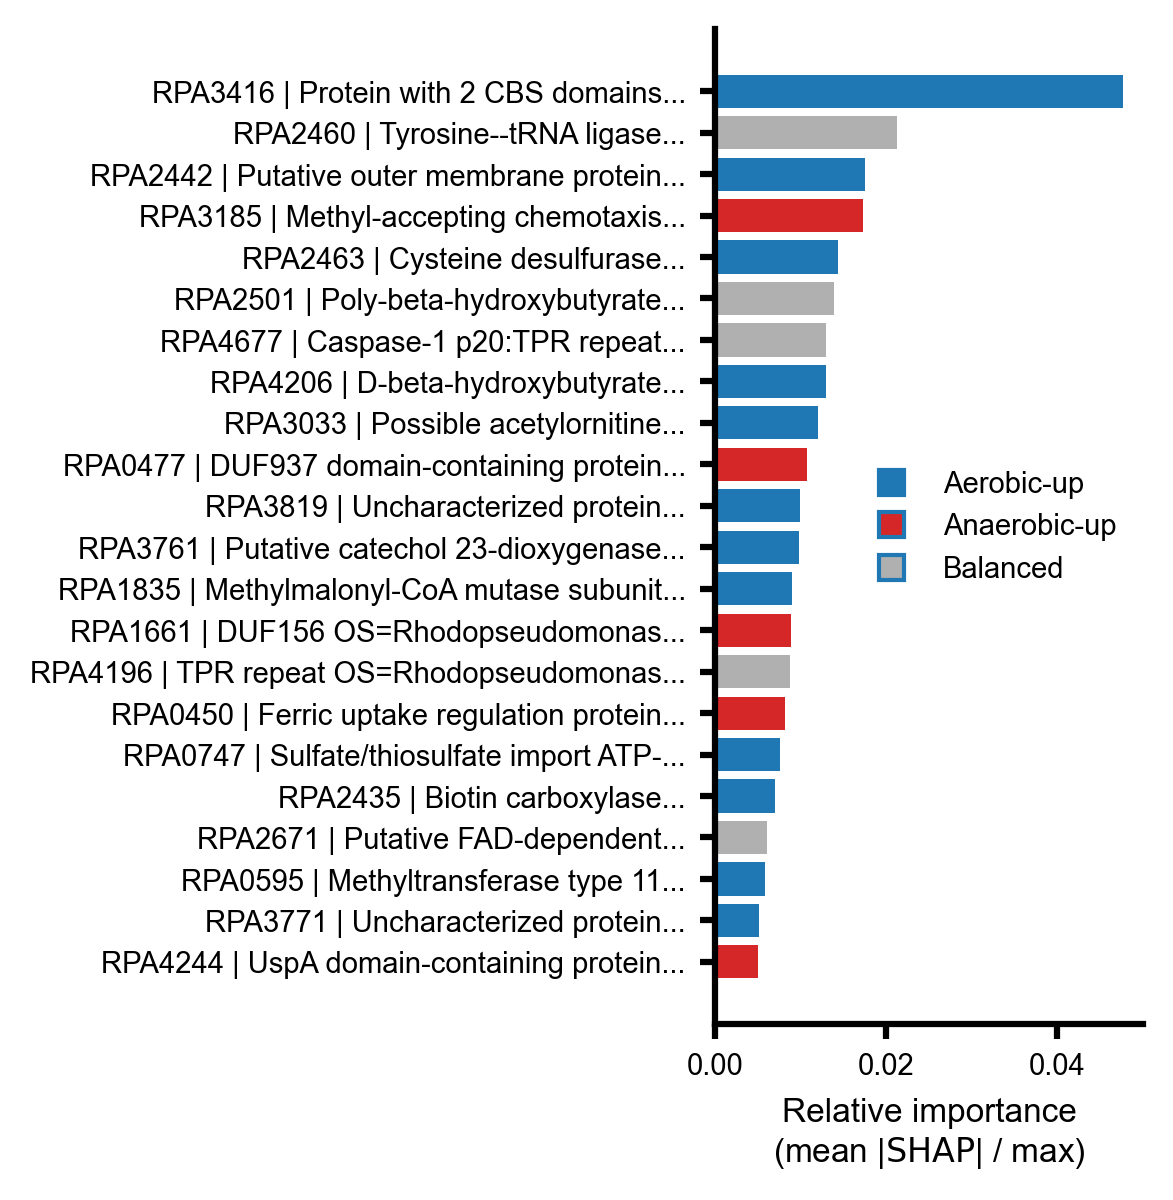

Saved: figures/Hubs/Tier_SHAP_barplot_Tier2_AdaptiveGeneralist_HH.png


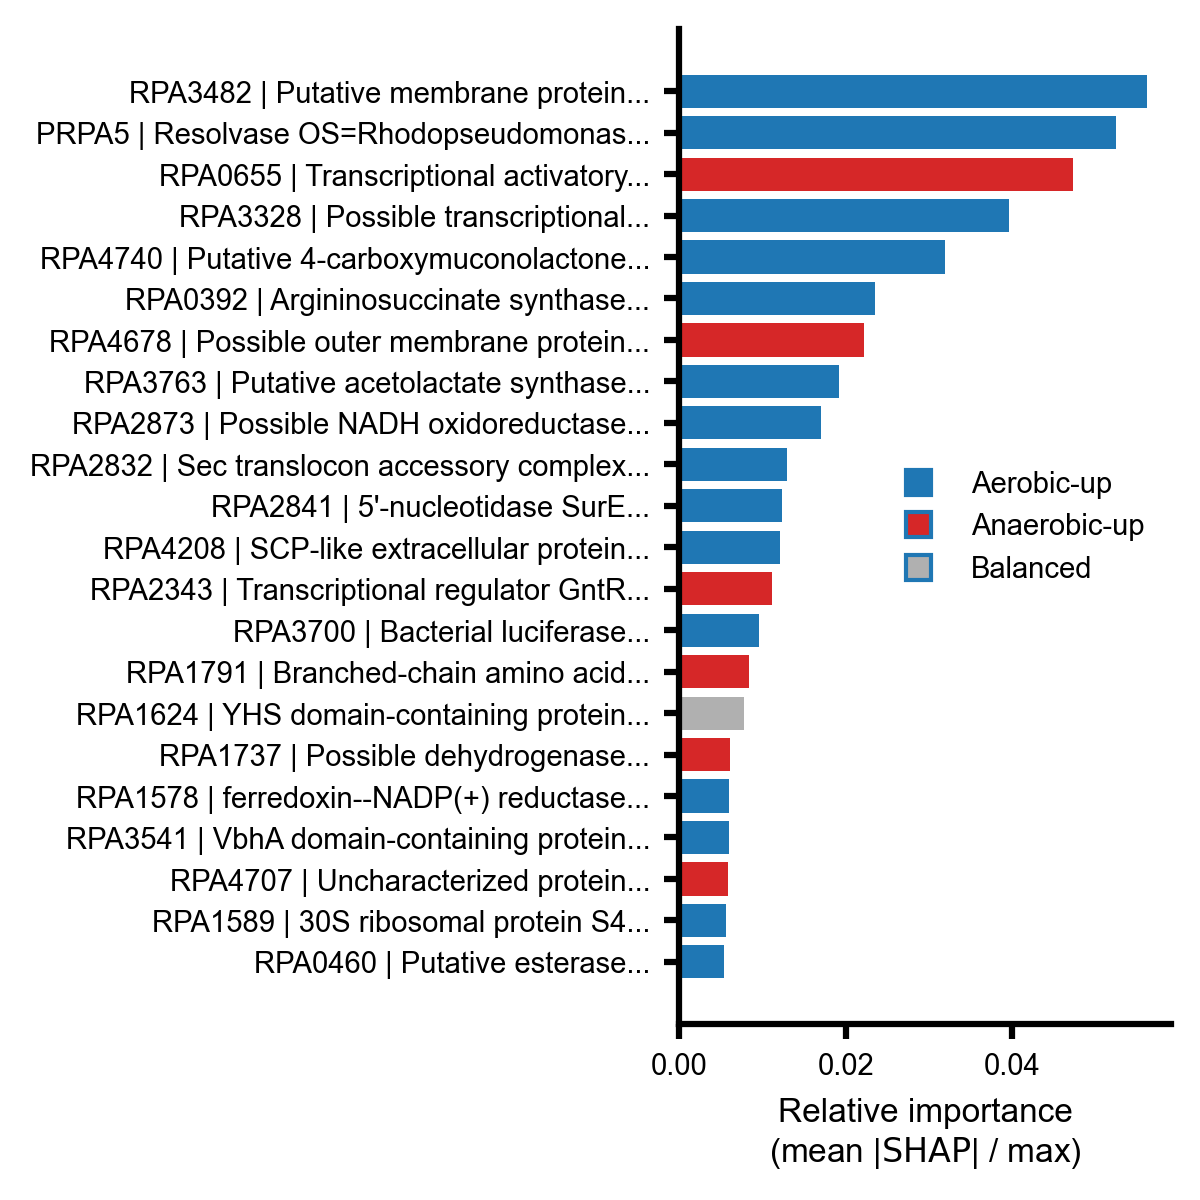

Saved: figures/Hubs/Tier_SHAP_barplot_Tier3_AdaptiveSpecialist_HH.png


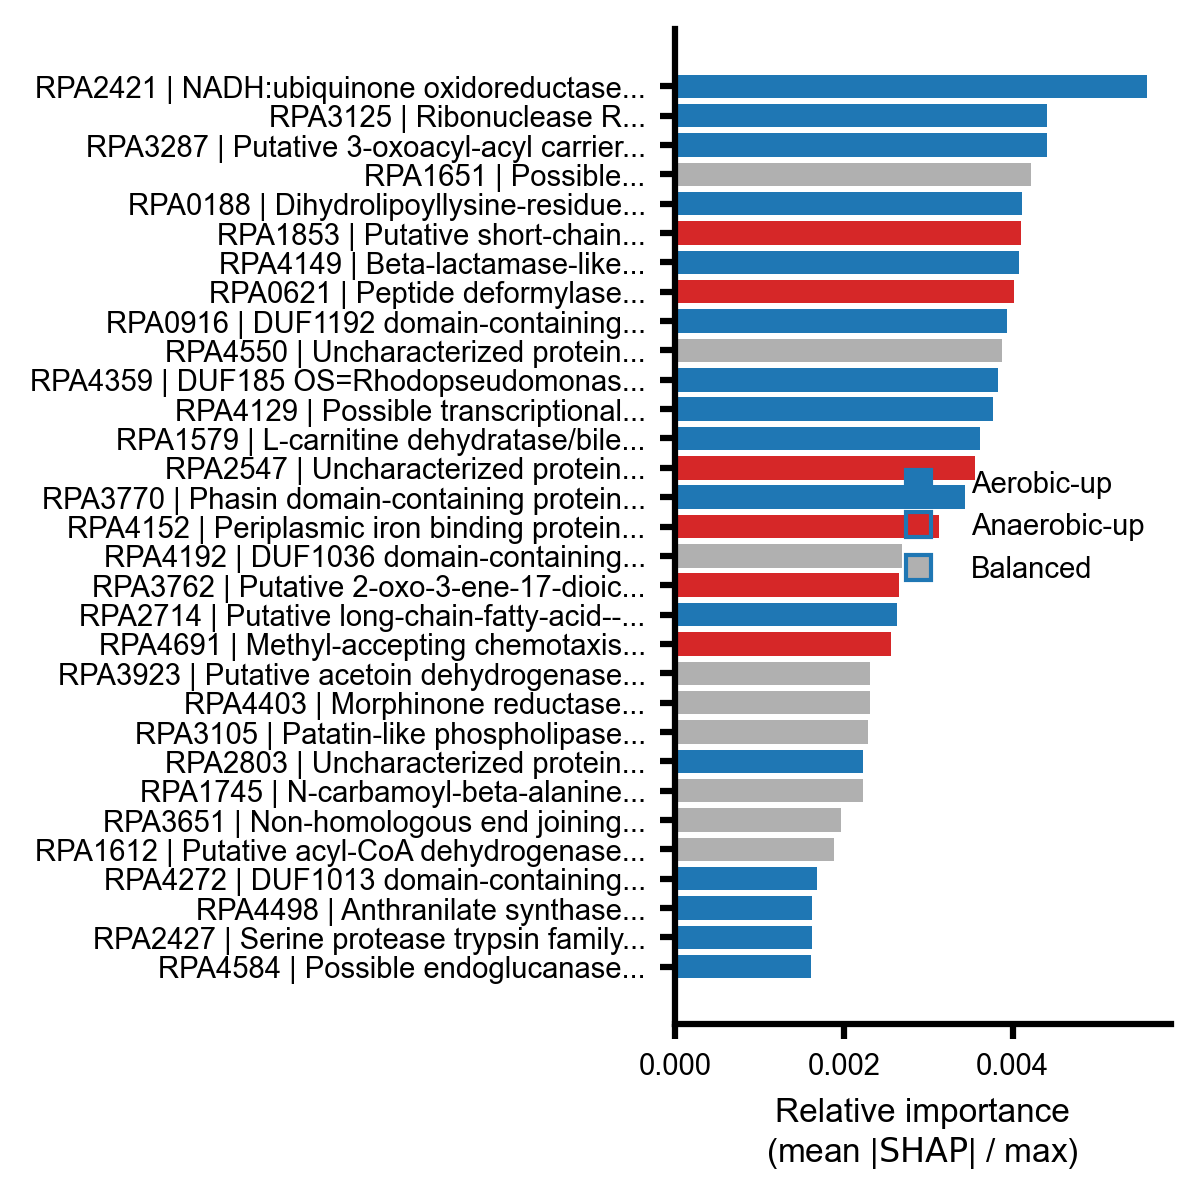

Saved: figures/Hubs/Tier_SHAP_barplot_Tier4_ConditionalBackground_HH.png


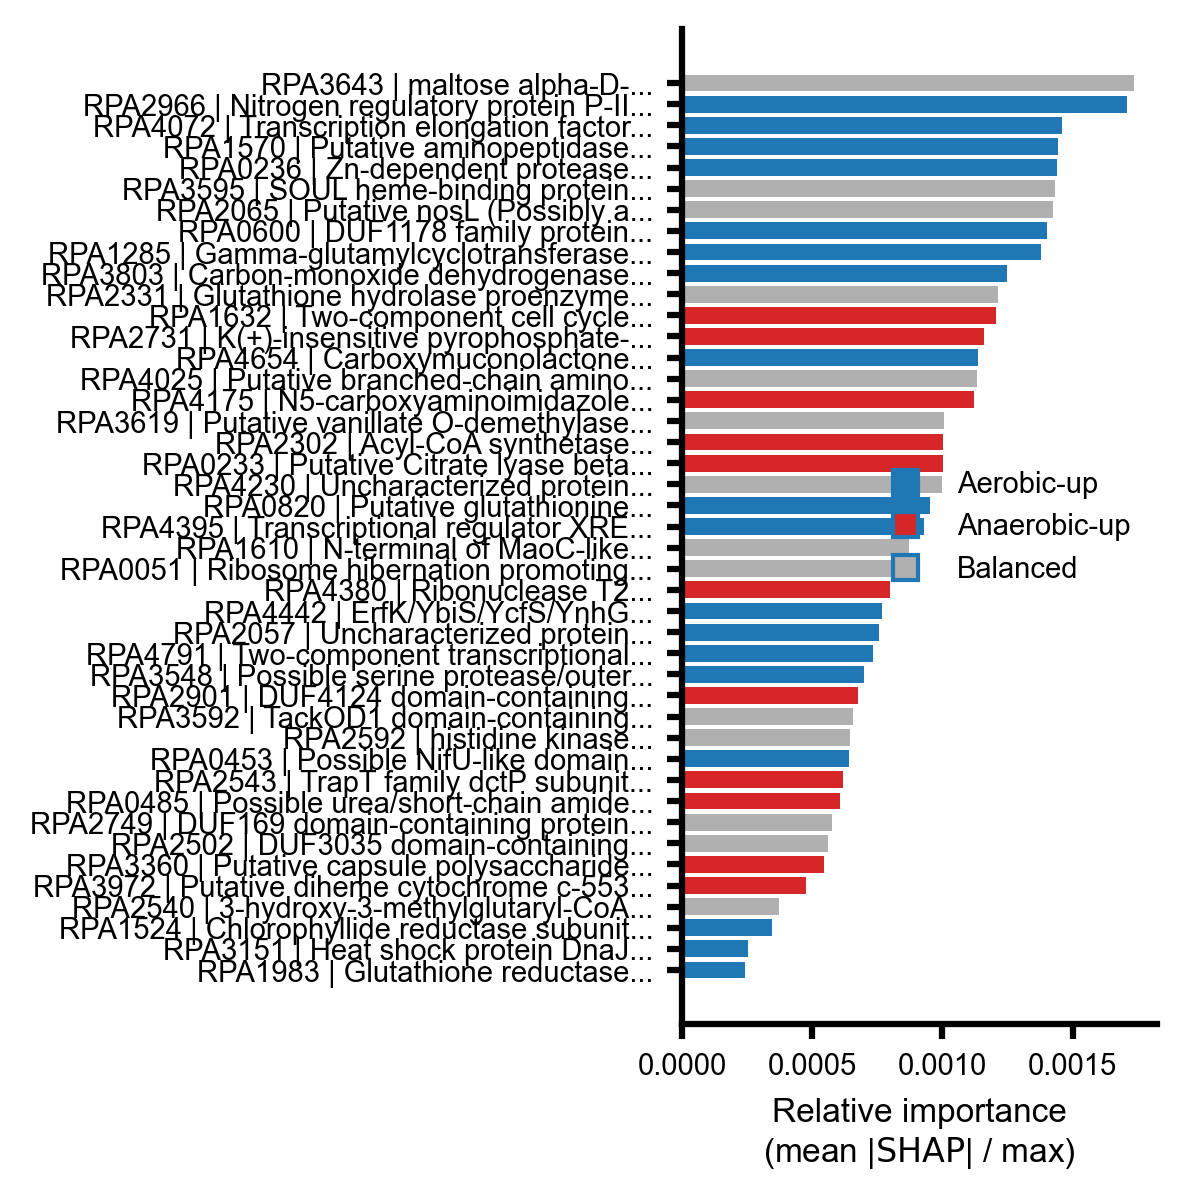

In [74]:
from textwrap import shorten
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({
    "figure.dpi": 300,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.labelsize": 9,
    "axes.titlesize": 10,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
})

def _journal_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")

DIR_COLORS = {
    "Ae_up": "#1f77b4",  # Aerobic-up
    "An_up": "#d62728",  # Anaerobic-up
    "ns":    "#b0b0b0",  # not significant
}

def plot_tier_barplot(excel_path, sheet_name, tier_label=None, max_genes=30):
    if tier_label is None:
        tier_label = sheet_name

    df = pd.read_excel(excel_path, sheet_name=sheet_name)

    required_cols = ["feature", "Description", "mean_abs_shap", "AeAn_direction"]
    for c in required_cols:
        if c not in df.columns:
            raise ValueError(f"Missing required column '{c}' in sheet '{sheet_name}'.")

    # Label: FEATURE | short description
    def make_label(row, max_len=35):
        desc = str(row["Description"])
        short_desc = shorten(desc, width=max_len, placeholder="...")
        return f"{row['feature']} | {short_desc}"

    df["display_label"] = df.apply(make_label, axis=1)

    # Sort by importance, take top N
    df_sorted = (
        df.sort_values("mean_abs_shap", ascending=False)
          .head(max_genes)
          .reset_index(drop=True)
    )

    # Normalize importance to [0, 1]
    # max_shap = df_sorted["mean_abs_shap"].max()
    max_shap = 0.00440436260893598
    # max_shap = 0.000547869503215437
    df_sorted["mean_abs_shap_rel"] = df_sorted["mean_abs_shap"] / max_shap

    # Map Ae/An direction to colors
    df_sorted["bar_color"] = df_sorted["AeAn_direction"].map(DIR_COLORS).fillna("#b0b0b0")

    # Plot
    fig_scale=0.7
    fig, ax = plt.subplots(figsize=(5.86*fig_scale, 5.86*fig_scale))
    y_pos = range(len(df_sorted))

    ax.barh(
        y_pos,
        df_sorted["mean_abs_shap_rel"],
        color=df_sorted["bar_color"],
    )

    ax.set_yticks(list(y_pos))
    ax.set_yticklabels(df_sorted["display_label"], fontsize=7)
    ax.invert_yaxis()

    ax.set_xlabel(
            # r"Relative importance\n(mean $|\mathrm{SHAP}|$ / max)",
            "Relative importance\n(mean $|\\mathrm{SHAP}|$ / max)",
            fontsize=8
                )
    # ax.set_title(tier_label, fontsize=9)

    _journal_axes(ax)

    # Legend for Ae_up / An_up / ns
    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0], [0], marker="s", linestyle="none",
               markersize=6, markerfacecolor=DIR_COLORS["Ae_up"],
               label=r"Aerobic-up"),
        Line2D([0], [0], marker="s", linestyle="none",
               markersize=6, markerfacecolor=DIR_COLORS["An_up"],
               label=r"Anaerobic-up"),
        Line2D([0], [0], marker="s", linestyle="none",
               markersize=6, markerfacecolor=DIR_COLORS["ns"],
               label=r"Balanced"),
    ]
    ax.legend(handles=legend_elems, fontsize=7, loc="center right", frameon=False)

    plt.tight_layout()

    out_dir = Path("figures/FigS2_S3")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"Tier_SHAP_barplot_{sheet_name}.png"
    fig.savefig(out_path, bbox_inches="tight")
    print(f"Saved: {out_path}")

    plt.show()

# --------------------------------------------------
# Use it for your Tier sheets
# --------------------------------------------------
hh_excel_path = "results/output.xlsx"   

groupname_sheetname_maps = {
    "Tier1_UniversalCore_HH":        "Tier1_UniversalCore_HH",
    "Tier2_AdaptiveGeneralist_HH":   "Tier2_AdaptiveGeneralist_HH",
    "Tier3_AdaptiveSpecialist_HH":   "Tier3_AdaptiveSpecialist_HH",
    "Tier4_ConditionalBackground_HH":"Tier4_ConditionalBackground_HH",
}

# Loop over tiers and plot
for tier_name, sheet in groupname_sheetname_maps.items():
    plot_tier_barplot(
        excel_path=hh_excel_path,
        sheet_name=sheet,
        tier_label=tier_name.replace("_", " "),
        max_genes=50,          # you can lower this to 20 for cleaner panels
    )


# KEGG ID to Pathways Mapping

## Non reference

In [ ]:
import re
from pathlib import Path
import pandas as pd

# --------------------------------------------------------
# 0. Read KEGG Mapper text file
# --------------------------------------------------------
txt_file = Path("data/kegg_mapper_result.txt")   # 

with txt_file.open("r", encoding="utf-8") as f:
    lines = f.readlines()

# --------------------------------------------------------
# 1. Parse: pathway headers + gene lines
# --------------------------------------------------------
path_id_to_name: dict[str, str] = {}
gene_to_ko: dict[str, str] = {}
gene_to_paths: dict[str, set[str]] = {}

current_path_id = None
current_path_name = None

for raw in lines:
    line = raw.rstrip("\n")

    # --- pathway header line, e.g.
    # rpa01100 Metabolic pathways (366)
    m_path = re.match(r'^(rpa\d{5})\s+(.+?)\s+\(\d+\)', line)
    if m_path:
        current_path_id = m_path.group(1)              # e.g. rpa01100
        current_path_name = m_path.group(2).strip()    # e.g. Metabolic pathways
        path_id_to_name[current_path_id] = current_path_name
        continue

    # --- gene line, e.g.
    #   rpa:TX73_000085 K00406 ccoP; cytochrome-...
    #   (lines start with spaces, then gene ID, KO_ID, description...)
    if current_path_id and line.lstrip().startswith("rpa:"):
        parts = line.strip().split(maxsplit=3)
        if len(parts) < 2:
            continue

        gene_id = parts[0]        # rpa:TX73_000085
        ko_id = parts[1]          # K00406

        # store KO (assume consistent; ignore if seen before)
        gene_to_ko.setdefault(gene_id, ko_id)

        # add this pathway to the gene's set
        gene_to_paths.setdefault(gene_id, set()).add(current_path_id)

# --------------------------------------------------------
# 2. Build flat table: KEGGID, KO_ID, Pathway_IDs, Pathway_Names
# --------------------------------------------------------
records = []
for gene_id, paths in gene_to_paths.items():
    # sort for reproducibility
    path_list = sorted(paths)
    path_names = [path_id_to_name.get(p, "") for p in path_list]

    records.append({
        "KEGGID": gene_id,
        "KO_ID": gene_to_ko.get(gene_id, ""),
        "Pathway_IDs": ",".join(path_list),
        "Pathway_Names": ", ".join(path_names),
    })

df_kegg_mapper = pd.DataFrame(records)

# Optional: sort by KEGGID
df_kegg_mapper = df_kegg_mapper.sort_values("KEGGID").reset_index(drop=True)

# --------------------------------------------------------
# 3. Save to CSV / inspect
# --------------------------------------------------------
df_kegg_mapper.to_csv("data/kegg_mapper_parsed.csv", index=False)
print(df_kegg_mapper.head())




In [ ]:
import pandas as pd

# df_kegg_mapper has: ["KEGGID", "KO_ID", "Pathway_IDs", "Pathway_Names"]
# path_id_to_name is the dict built during parsing:
#   e.g. {"rpa01100": "Metabolic pathways", "rpa02020": "Two-component system", ...}

# 1. Explode comma-separated Pathway_IDs to one row per (gene, pathway)
tmp = df_kegg_mapper.copy()
tmp["Pathway_IDs"] = tmp["Pathway_IDs"].fillna("")
tmp = tmp[tmp["Pathway_IDs"] != ""]   # drop genes with no mapped pathways

tmp = tmp.assign(Pathway_ID=tmp["Pathway_IDs"].str.split(",")) \
         .explode("Pathway_ID")

tmp["Pathway_ID"] = tmp["Pathway_ID"].str.strip()

# 2. Count unique genes per Pathway_ID
path_counts = (
    tmp.groupby("Pathway_ID")["KEGGID"]
       .nunique()
       .rename("n_genes")
       .reset_index()
)

# 3. Attach correct pathway names from the original dict
path_counts["Pathway_Name"] = path_counts["Pathway_ID"].map(path_id_to_name)

# 4. Sort for inspection
path_counts = path_counts.sort_values("n_genes", ascending=False)

print(path_counts)

In [ ]:
import pandas as pd

# ------------------------------------------------------------------
# 0. Load entire original workbook
# ------------------------------------------------------------------
kegg_file = "data/Kegg2Accession_pathway.xlsx "
all_sheets = pd.read_excel(kegg_file, sheet_name=None)   # dictionary of sheet_name  df

# Extract MasterDict
kegg_df = all_sheets["MasterDict"].copy()

# ------------------------------------------------------------------
# 1. Clean IDs
# ------------------------------------------------------------------
kegg_df["KEGGID"] = kegg_df["KEGGID"].astype(str).str.strip()
df_kegg_mapper["KEGGID"] = df_kegg_mapper["KEGGID"].astype(str).str.strip()

# ------------------------------------------------------------------
# 2. Merge KEGG annotations
# ------------------------------------------------------------------
kegg_df_annot = kegg_df.merge(
    df_kegg_mapper[["KEGGID", "KO_ID", "Pathway_IDs", "Pathway_Names"]],
    on="KEGGID",
    how="left"
)

print("\nPreview of annotated KEGG MasterDict:")
print(kegg_df_annot.head())

# Replace old sheet with annotated version
all_sheets["MasterDict"] = kegg_df_annot

# ------------------------------------------------------------------
# 3. Write ALL sheets to a NEW workbook (duplicate)
# ------------------------------------------------------------------
kegg_file2 = "data/Kegg2Accession_pathway.xlsx"

with pd.ExcelWriter(kegg_file2, engine="openpyxl", mode="w") as writer:
    for sheet_name, sheet_df in all_sheets.items():
        sheet_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"\nUpdated workbook written to: {kegg_file2}")

format_excel_with_filters_and_freeze(kegg_file2)
